# To What Extent can machine learning algorithms predict bike hire patterns based off weather patterns

# Introduction


As computational power and AI only advance and the advent of large public domain data sets on a wide range of metrics, it is possible to use these tools predict quantitatively the relationship between certain events and others, in a way that was not possible before due to the complex and dynamical nature of systems. Since material advances have led to new possibilities there is an emerging field of machine learning and city modelling. Chen, L, 2016 have investigated the effects of weather and other spatial-temporal data on bike hire schemes using clustering techniques. There has been a wide range of research looking into the effects of weather on traffic demand. Li, Y. 2015 uses a Gradient-Boosting-Regression-Tree to predict demand in Washington and New York City.  This paper aims to explore the limitations of some machine learning models with respect to micro-modelling to better understand the pitfalls of some approaches, and to what extent machine learning algorithms can predict behaviour, in this case Santander bike hires in London, with respect to weather. 

Bike sharing schemes need vehicles to actively rebalance demand for bikes at certain stations, to do this is useful to be able to pre-empt demand for bike sharing schemes based on weather variability. Walsh, D., 2021 uses Random forests and clustering methods to predict the need for bike rebalancing in Dublin. (Walsh, D., 2021),( Lainjo, B., 2022.), (Li, Y. 2015), (Chen, L, 2016).

Furthermore there is a growing field of other pre-empetive demand based modelling from bus routes and scheduling to, train delay forecasting and large event dispersal. All of the models need to understand the predictive power of the weather, and how that can influence demand and prediction capabilities (Walsh, D., 2021), (Lainjo, B., 2022..), (Li, Y. 2015), (Chen, L, 2016).


# Methodology

The data was collected from two robust primary sources with provenance being of upmost importance. 

An open API implementation of Meto Stats historical weather data was implemented, this collected data on 9 weather related variables humidity (%), temperature (Celius), precipitation (mm), snow depth (Meters), wind speed (KPH), cloud cover (%), sunshine duration (seconds), apparent temperature (Celsius), and weather code (WMO).  More information can be found at https://open-meteo.com/en/docs/historical-weather-api. 
    
This data has a precision of 3km, and 1 hour which meant that instantaneous granularity on the level of individual stations was not quite achieved, however due to the laws of large numbers, once aggregated this would become less significant. 

The data was checked for missing and extreme values and was found to be extremely high quality.

The bike data was taken from TFL’s https://cycling.data.tfl.gov.uk/, it contained all the individual hire entries for London over a two-year period. The Data is in two files called 2015TripData.zip and 2016TripData.zip . The data is not included as it is so large. 
    
The data was cleaned and processed for null, and logistical inconsistent entries, these were dropped, again affecting performance on the micro level, but due to comparative size of the data set and lack of erroneous data, was assumed to make little impact. 

The Bike entries were aggregated onto the station level each hour, as that was the minimum level of precision for which we had information on the weather. 

Due to processing limitations two modes of enquiry were decided on. The data set was originally on the order 20 million rows. Covering 837 unique stations every hour of the day for two years. The data was either taken at the station level, reducing the data point by order of 1000, or consolidated as an average across the whole of London. Simple means were taken as there assumed to be no spatial dependencies dependent on weather. Again, reducing the data by an order of 1000. 

A generalised normalised demand curve was added to reduce the dependency on temporal demand from non-weather-related variables. This was used as the mode of comparison later.

The non-temporal based demand fluctuation was categorised into 5 discrete categories, Very low, low, little change, high and very high. These just represent the percentile split of every 20th percentile. 

Two Extra metrics which were the rainfall in the previous four hours and the rainfall for the twelve hours before and after. The former was added to account for both the previous experience of rain and the current state of wetness. And the latter for the generalised anticipation of more rain to come, whether that materialised that hour or not, which may affect travel plans. Both of these were necessary due to the lack of minutely precision of the data, as well as the psychological impact of prior rain or the anticipation of rain to come at some unspecified future near time. 

There is obviously limitations here as other variables such as pressure, cloud cover and wind speed also serve as proxy for incoming rain, and these were not factored into this approximate psychological modelling. 

Four machine learning algorithms of different types were picked, to represent different modes of approaches for prediction. Linear Regression, Naïve bayes, Perceptron and Decision Tree. 

The data was split into training and test sets for both the London wide data sets and station 154’s data set. 

The machine learning models were ran. 


# Imports

In [2]:
import openmeteo_requests
import seaborn as sns
import os
import zipfile
import shutil
import requests_cache
import pandas as pd
from retry_requests import retry 
import numpy as np


from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression  
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import time 
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay 
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plt


from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

from datetime import datetime

import requests_cache
from retry_requests import retry
import time
from sklearn import linear_model

from sklearn.model_selection import train_test_split

# Read in Weather Data 

In [1]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

In [2]:
### this is partly based off the API implementation from https://open-meteo.com/en/docs/historical-weather-api

def get_weather_data(latitude, longitude, station_id):
    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
    openmeteo = openmeteo_requests.Client(session = retry_session)

    #Import the required variables 
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": '2015-01-04',
        "end_date": '2017-01-04',
        "hourly": ["temperature_2m","precipitation","relative_humidity_2m","apparent_temperature","cloud_cover","sunshine_duration","wind_speed_10m","weather_code","snow_depth"],
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]
    print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")

    # Process hourly data.
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()
    hourly_relative_humidity_2m =  hourly.Variables(2).ValuesAsNumpy()
    hourly_apparent_temperature =  hourly.Variables(3).ValuesAsNumpy()
    hourly_cloud_cover =  hourly.Variables(4).ValuesAsNumpy()
    hourly_sunshine_duration =  hourly.Variables(5).ValuesAsNumpy()
    hourly_wind_speed_10m =  hourly.Variables(6).ValuesAsNumpy()
    hourly_weather_code =  hourly.Variables(7).ValuesAsNumpy()
    hourly_snow_depth =  hourly.Variables(8).ValuesAsNumpy()
    
    hourly_data = {"date": pd.date_range(
        start = pd.to_datetime(hourly.Time(), unit = "s"),
        end = pd.to_datetime(hourly.TimeEnd(), unit = "s"),
        freq = pd.Timedelta(seconds = hourly.Interval()),
        inclusive = "left"
    )}
    hourly_data["temperature_2m"] = hourly_temperature_2m
    hourly_data["precipitation"] = hourly_precipitation
    hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
    hourly_data["apparent_temperature"] = hourly_apparent_temperature
    hourly_data["cloud_cover"] = hourly_cloud_cover
    hourly_data["sunshine_duration"] = hourly_sunshine_duration
    hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
    hourly_data["weather_code"] = hourly_weather_code
    hourly_data["snow_depth"] = hourly_snow_depth
    hourly_data["latitude"] =latitude
    hourly_data["longitude"] =longitude
    hourly_data["station_id"] =station_id
    


    hourly_dataframe = pd.DataFrame(data = hourly_data)
    hourly_dataframe
    return  hourly_dataframe



# Specify the encoding while reading the CSV file
station_info = pd.read_csv("Docking Station Info.csv", encoding='latin1')

# Initialize an empty DataFrame to store the merged results
#Weather = pd.DataFrame()

Weather = pd.read_csv("WeatherData.csv")

# Initialize the last processed index
last_processed_index = 837
delay = 2


In [ ]:
last_processed_index = 837

In [ ]:
# Iterate through locations and concatenate weather data into merged_df
for index, row in station_info.iterrows():
    # Skip locations before the last processed index
    if index < last_processed_index:
        continue
    if index == 837:
        break
    
    latitude = row['Latitude']
    longitude = row['Longitude']
    station_id = row["Docking station ID"]
    
    #This code is used so as to not exceed API limits 
    max_retries = 100
    retry_count = 0
    breakdelay = 61 
    while retry_count < max_retries:
        try:
            location_data = get_weather_data(latitude, longitude, station_id)
            
            if not location_data.empty:
                merged_df = pd.concat([merged_df, location_data], ignore_index=True)
            else:
                print(f"No data for station {station_id}")
            
            # Break out of the retry loop if successful
            break
        except Exception as e:
            print(f"Error retrieving data for station {station_id}: {e}")
            
            # Increment retry count and wait before the next attempt
            retry_count += 1
            time.sleep(breakdelay * retry_count)  # Increasing delay for each retry

    # Update the last processed index after each iteration
    last_processed_index = index + 1


In [ ]:
# Save the data 
csv_file_path = r"C:\Users\23510\Data Science for Urban Systems Course Work\Big Data Science Project\WeatherData.csv"

# Save the DataFrame to a CSV file
#Weather.to_csv(csv_file_path, index=False)

In [ ]:
print(last_processed_index)

In [ ]:
# Drop the columns with no value 

columns_to_drop = ["latitude","longitude"]

# Drop the columns
Weather = Weather.drop(columns=columns_to_drop)

# Read in Bike Data 

The bike data was taken from TFL’s https://cycling.data.tfl.gov.uk/, it contained all the individual hire entries for London over a two-year period. The Data is in two files called 2015TripData.zip and 2016TripData.zip . The data is not included as it is so large.

In [14]:
#This is code for reading in the zipped files and merging them into a DataFrame 
# Zip File Path
zip_directory = r"C:\Users\23510\Data Science for Urban Systems Course Work\Big Data Science Project\Bike data 2"

# List of all zip files in the directory
zip_files = [file for file in os.listdir(zip_directory) if file.endswith('.zip')]

# create an empty DataFrame to store the merged data
TFL = pd.DataFrame()

# Iterate through each zip file, extract CSV and merge into the DataFrame
for zip_file in zip_files:
    print(f"Processing zip file: {zip_file}")
    
    # Create the file path for the zip file
    zip_file_path = os.path.join(zip_directory, zip_file)
    
    # Create a temporary directory to extract contents
    temp_dir = os.path.join(zip_directory, 'temp')
    os.makedirs(temp_dir, exist_ok=True)
    
    # Extract the contents of the zip file to the temporary directory
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)
    
    # List all CSV files in the temporary directory
    csv_files = [file for file in os.listdir(temp_dir) if file.endswith('.csv')]
    
    print(f"Found CSV files in temp directory: {csv_files}")
    
    # Iterate through each CSV file and merge into the DataFrame
    for csv_file in csv_files:
        # Create the file path for the CSV file
        csv_file_path = os.path.join(temp_dir, csv_file)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_file_path)
        
        # Merge the current DataFrame with the existing merged DataFrame
        TFL = pd.concat([TFL, df], ignore_index=True)
    
    # Remove the temporary directory and its contents
    shutil.rmtree(temp_dir)
    print(f"Temporary directory '{temp_dir}' removed\n")

Processing zip file: 2015TripDatazip.zip
Found CSV files in temp directory: ['10a Journey Data Extract 20Sep15-03Oct15.csv', '10b Journey Data Extract 04Oct15-17Oct15.csv', '11a Journey Data Extract 18Oct15-31Oct15.csv', '11b Journey Data Extract 01Nov15-14Nov15.csv', '12a Journey Data Extract 15Nov15-27Nov15.csv', '12b Journey Data Extract 28Nov15-12Dec15.csv', '13a Journey Data Extract 13Dec15-24Dec15.csv', '13b Journey Data Extract 25Dec15-09Jan16.csv', '1a.JourneyDataExtract04Jan15-17Jan15.csv', '1b.JourneyDataExtract18Jan15-31Jan15.csv', '2a.JourneyDataExtract01Feb15-14Feb15.csv', '2b.JourneyDataExtract15Feb15-28Feb15.csv', '3a.JourneyDataExtract01Mar15-15Mar15.csv', '3b.JourneyDataExtract16Mar15-31Mar15.csv', '4a.JourneyDataExtract01Apr15-16Apr15.csv', '4b.JourneyDataExtract 17Apr15-02May15.csv', '5a.JourneyDataExtract03May15-16May15.csv', '5b.JourneyDataExtract17May15-30May15.csv', '6aJourneyDataExtract31May15-12Jun15.csv', '6bJourneyDataExtract13Jun15-27Jun15.csv', '7a.JourneyD

# Basic Preprocessing

In [15]:
# Convert the date columns to datetime format
TFL["Start Date"] = pd.to_datetime(TFL["Start Date"], format='%d/%m/%Y %H:%M', errors='coerce')
TFL["End Date"] = pd.to_datetime(TFL["End Date"], format='%d/%m/%Y %H:%M', errors='coerce')

In [16]:
TFL

Rental Id  Duration  Bike Id            End Date  EndStation Id  \
0          47984328     300.0   3115.0 2015-09-20 00:06:00          187.0   
1          47984315     300.0   1058.0 2015-09-20 00:06:00          723.0   
2          47984324     360.0   4446.0 2015-09-20 00:07:00          252.0   
3          47984341     300.0   4298.0 2015-09-20 00:07:00           63.0   
4          47984344     360.0   9520.0 2015-09-20 00:08:00          360.0   
...             ...       ...      ...                 ...            ...   
20124053   61435280     240.0   1708.0 2017-01-03 21:12:00          773.0   
20124054   61435285     300.0   8930.0 2017-01-03 21:13:00          633.0   
20124055   61435443     360.0   4956.0 2017-01-03 21:39:00          680.0   
20124056   61435445    7380.0   7005.0 2017-01-03 23:36:00          229.0   
20124057   61435448    7320.0   1383.0 2017-01-03 23:36:00          229.0   

                                 EndStation Name          Start Date  \
0         Queen's Gate (South), South Kensington 2015-09-20 00:01:00   
1                    Stephendale Road, Sands End 2015-09-20 00:01:00   
2                    Jubilee Gardens, South Bank 2015-09-20 00:01:00   
3                          Murray Grove , Hoxton 2015-09-20 00:02:00   
4                      Howick Place, Westminster 2015-09-20 00:02:00   
...                                          ...                 ...   
20124053                   Tallis Street, Temple 2017-01-03 21:08:00   
20124054     Vereker Road North, West Kensington 2017-01-03 21:08:00   
20124055              Westbridge Road, Battersea 2017-01-03 21:33:00   
20124056                 Whitehall Place, Strand 2017-01-03 21:33:00   
20124057                 Whitehall Place, Strand 2017-01-03 21:34:00   

          StartStation Id                    StartStation Name  Unnamed: 9  \
0                   220.0               Chelsea Green, Chelsea         NaN   
1                   621.0  Wandsworth Town Station, Wandsworth         NaN   
2                   100.0          Albert Embankment, Vauxhall         NaN   
3                   107.0  Finsbury Leisure Centre, St. Luke's         NaN   
4                   108.0    Abbey Orchard Street, Westminster         NaN   
...                   ...                                  ...         ...   
20124053            388.0           Southampton Street, Strand         NaN   
20124054            599.0             Manbre Road, Hammersmith         NaN   
20124055            701.0         Vicarage Crescent, Battersea         NaN   
20124056            111.0                Park Lane , Hyde Park         NaN   
20124057            111.0                Park Lane , Hyde Park         NaN   

          Unnamed: 10  Unnamed: 11  EndStation Logical Terminal  \
0                 NaN          NaN                          NaN   
1                 NaN          NaN                          NaN   
2                 NaN          NaN                          NaN   
3                 NaN          NaN                          NaN   
4                 NaN          NaN                          NaN   
...               ...          ...                          ...   
20124053          NaN          NaN                          NaN   
20124054          NaN          NaN                          NaN   
20124055          NaN          NaN                          NaN   
20124056          NaN          NaN                          NaN   
20124057          NaN          NaN                          NaN   

          endStationPriority_id  StartStation Logical Terminal  
0                           NaN                            NaN  
1                           NaN                            NaN  
2                           NaN                            NaN  
3                           NaN                            NaN  
4                           NaN                            NaN  
...                         ...                            ...  
20124053               

Dropping unessecary columns

In [17]:
columns_to_drop = TFL.columns[-6:]

# Drop the columns
TFL = TFL.drop(columns=columns_to_drop)

## data file was 2.7G
columns_to_drop = ["Rental Id", "Bike Id" , "EndStation Name", "StartStation Name"]

# Drop the columns
TFL = TFL.drop(columns=columns_to_drop)
## now only 1.1G

In [ ]:
#Saving the data file
csv_file_path = r"C:\Users\23510\Data Science for Urban Systems Course Work\Big Data Science Project\BikeData.csv"

# Save the DataFrame to a CSV file
merged_df.to_csv(csv_file_path, index=False)

In [3]:
#Reading in the data file 
BikeData =  pd.read_csv(
    r"C:\Users\23510\Data Science for Urban Systems Course Work\Big Data Science Project\BikeData.csv",
    
)


C:\Users\23510\AppData\Local\Temp\ipykernel_11968\3849892653.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  BikeData =  pd.read_csv(


In [8]:
BikeData

Duration             End Date  EndStation Id           Start Date  \
0            300.0  2015-09-20 00:06:00          187.0  2015-09-20 00:01:00   
1            300.0  2015-09-20 00:06:00          723.0  2015-09-20 00:01:00   
2            360.0  2015-09-20 00:07:00          252.0  2015-09-20 00:01:00   
3            300.0  2015-09-20 00:07:00           63.0  2015-09-20 00:02:00   
4            360.0  2015-09-20 00:08:00          360.0  2015-09-20 00:02:00   
...            ...                  ...            ...                  ...   
20124053     240.0  2017-01-03 21:12:00          773.0  2017-01-03 21:08:00   
20124054     300.0  2017-01-03 21:13:00          633.0  2017-01-03 21:08:00   
20124055     360.0  2017-01-03 21:39:00          680.0  2017-01-03 21:33:00   
20124056    7380.0  2017-01-03 23:36:00          229.0  2017-01-03 21:33:00   
20124057    7320.0  2017-01-03 23:36:00          229.0  2017-01-03 21:34:00   

          StartStation Id  
0                   220.0  
1                   621.0  
2                   100.0  
3                   107.0  
4                   108.0  
...                   ...  
20124053            388.0  
20124054            599.0  
20124055            701.0  
20124056            111.0  
20124057            111.0  

[20124058 rows x 5 columns]

# Clean Data

# Bike Data

In [5]:
BikeData["Start Date"].dtypes

dtype('O')

cleaning the data removing nan and infinite values

In [12]:
## Duration
# Identify NaN and inf values
nan_values = BikeData['Duration'].isna()
inf_values = ~np.isfinite(BikeData['Duration'])


# Display rows with non-finite values
print(BikeData[nan_values | inf_values])
## drop these values 
BikeData = BikeData.dropna(subset=['Duration'])
BikeData.loc[:, 'Duration'] = BikeData['Duration'].astype("int64")
nan_values = BikeData['Duration'].isna()

#--------------

##EndDate
# Identify NaN and inf values
nan_values = BikeData['End Date'].isna()


# Display rows with non-finite values
print(BikeData[nan_values])
## drop these values 
BikeData = BikeData.dropna(subset=['End Date'])
BikeData.loc[:, 'End Date'] = BikeData['End Date']
nan_values = BikeData['End Date'].isna()

#--------------

##EndStation Id
# Identify NaN and inf values
nan_values = BikeData['EndStation Id'].isna()
inf_values = ~np.isfinite(BikeData['EndStation Id'])


# Display rows with non-finite values
print(BikeData[nan_values | inf_values])
## drop these values 
BikeData = BikeData.dropna(subset=['EndStation Id'])
BikeData.loc[:, 'EndStation Id'] = BikeData['EndStation Id'].astype("int64")
nan_values = BikeData['EndStation Id'].isna()

#--------------

##Start Date
# Identify NaN and inf values
nan_values = BikeData['Start Date'].isna()


# Display rows with non-finite values
print(BikeData[nan_values])
## drop these values 
BikeData = BikeData.dropna(subset=['Start Date'])
BikeData.loc[:, 'Start Date'] = BikeData['Start Date']
nan_values = BikeData['Start Date'].isna()

#--------------

##StartStation Id
# Identify NaN and inf values
nan_values = BikeData['StartStation Id'].isna()
inf_values = ~np.isfinite(BikeData['StartStation Id'])


# Display rows with non-finite values
print(BikeData[nan_values | inf_values])
## drop these values 
BikeData = BikeData.dropna(subset=['StartStation Id'])
BikeData.loc[:, 'StartStation Id'] = BikeData['StartStation Id'].astype("int64")
nan_values = BikeData['StartStation Id'].isna()



Empty DataFrame
Columns: [Duration, End Date, EndStation Id, Start Date, StartStation Id]
Index: []
         Duration End Date  EndStation Id Start Date  StartStation Id
2174775     480.0      NaN           37.0        NaN            649.0
2174776     660.0      NaN          278.0        NaN            230.0
2174777     180.0      NaN          446.0        NaN            485.0
2174778    1800.0      NaN          626.0        NaN            602.0
2174779    2100.0      NaN          706.0        NaN            717.0
...           ...      ...            ...        ...              ...
2639166    5160.0      NaN          184.0        NaN            184.0
2639167     360.0      NaN           14.0        NaN            234.0
2639168    1320.0      NaN          708.0        NaN            166.0
2639169     480.0      NaN          667.0        NaN              2.0
2639170    1140.0      NaN          321.0        NaN            372.0

[464396 rows x 5 columns]
          Duration             En

Checking for missing values and abnormal values.

In [13]:
`## Cleaning and error checking 

## Check for missing values
print("Missing Values:")
print(BikeData.isnull().sum())
BikeData = BikeData.dropna()


Missing Values:
Duration           0
End Date           0
EndStation Id      0
Start Date         0
StartStation Id    0
dtype: int64


In [14]:
# Check for abnormal values
BikeData.describe()

Duration  EndStation Id  StartStation Id
count  1.932538e+07   1.932538e+07     1.932538e+07
mean   1.359578e+03   3.409580e+02     3.437352e+02
std    1.066762e+04   2.245635e+02     2.250237e+02
min   -3.540000e+03   1.000000e+00     1.000000e+00
25%    4.800000e+02   1.540000e+02     1.540000e+02
50%    8.400000e+02   3.070000e+02     3.090000e+02
75%    1.320000e+03   5.240000e+02     5.310000e+02
max    2.674020e+06   8.200000e+02     8.200000e+02

Basic sanity checking.

In [15]:
#'Start Date' is before 'End Date'
date_check = BikeData[BikeData['Start Date'] > BikeData['End Date']]
if not date_check.empty:
    print("Inconsistent Dates:", date_check)
bad_index = date_check.index
BikeData= BikeData.drop(bad_index)

Inconsistent Dates:           Duration             End Date  EndStation Id           Start Date  \
1028647    -2880.0  2015-10-25 01:00:00          464.0  2015-10-25 01:48:00   
1028652    -1500.0  2015-10-25 01:00:00          508.0  2015-10-25 01:25:00   
1028653    -2640.0  2015-10-25 01:00:00           37.0  2015-10-25 01:44:00   
1028656    -1200.0  2015-10-25 01:01:00          158.0  2015-10-25 01:21:00   
1028657    -1980.0  2015-10-25 01:01:00           62.0  2015-10-25 01:34:00   
...            ...                  ...            ...                  ...   
18701482   -2520.0  2016-10-30 01:04:00          568.0  2016-10-30 01:46:00   
18701483   -1320.0  2016-10-30 01:26:00          376.0  2016-10-30 01:48:00   
18701484   -3300.0  2016-10-30 01:02:00          491.0  2016-10-30 01:57:00   
18701485   -3300.0  2016-10-30 01:02:00          491.0  2016-10-30 01:57:00   
18701489   -3060.0  2016-10-30 01:06:00          517.0  2016-10-30 01:57:00   

          StartStation Id  
102

In [16]:
# Assuming "Start Date" is a string column, convert it to datetime
BikeData["Start Date"] = pd.to_datetime(BikeData["Start Date"])

# Now, create the "date_and_hour" column
BikeData["date_and_hour"] = BikeData["Start Date"].dt.strftime('%Y-%m-%d %H')


# Weather Data 

Weather data was found to have no null values.

In [10]:
## Check for null values 

## Check for missing values
print("Missing Values:")
print(Weather.isnull().sum())
Weather= Weather.dropna()

Missing Values:
date                    0
temperature_2m          0
precipitation           0
relative_humidity_2m    0
apparent_temperature    0
cloud_cover             0
sunshine_duration       0
wind_speed_10m          0
weather_code            0
snow_depth              0
latitude                0
longitude               0
station_id              0
dtype: int64


 Weather data was found to have sensible maxium and minimum values. Data set is of a very high quality.

In [11]:
Weather.describe()

temperature_2m  precipitation  relative_humidity_2m  \
count    1.468685e+07   1.468685e+07          1.468685e+07   
mean     1.091522e+01   6.878797e-02          7.949806e+01   
std      5.769054e+00   2.840862e-01          1.374984e+01   
min     -4.395000e+00   0.000000e+00          3.175529e+01   
25%      6.735000e+00   0.000000e+00          7.013005e+01   
50%      1.098500e+01   0.000000e+00          8.254290e+01   
75%      1.498050e+01   0.000000e+00          9.077278e+01   
max      3.293000e+01   9.200000e+00          1.000000e+02   

       apparent_temperature   cloud_cover  sunshine_duration  wind_speed_10m  \
count          1.468685e+07  1.468685e+07       1.468685e+07    1.468685e+07   
mean           8.252396e+00  5.908642e+01       1.049135e+03    1.483818e+01   
std            6.939449e+00  3.615001e+01       1.563166e+03    7.117405e+00   
min           -8.648465e+00  0.000000e+00       0.000000e+00    0.000000e+00   
25%            2.970571e+00  2.670000e+01       0.000000e+00    9.585739e+00   
50%            8.002548e+00  6.390000e+01       0.000000e+00    1.384948e+01   
75%            1.330648e+01  1.000000e+02       3.300856e+03    1.900855e+01   
max            3.433253e+01  1.000000e+02       3.600000e+03    5.443980e+01   

       weather_code    snow_depth      latitude     longitude    station_id  
count  1.468685e+07  1.468685e+07  1.468685e+07  1.468685e+07  1.468685e+07  
mean   8.136749e+00  2.270685e-04  5.150552e+01 -1.275153e-01  4.199055e+02  
std    1.717829e+01  1.715278e-03  2.182907e-02  5.527847e-02  2.455727e+02  
min    0.000000e+00  0.000000e+00  5.133410e+01 -2.367700e-01  1.000000e+00  
25%    1.000000e+00  0.000000e+00  5.149318e+01 -1.711032e-01  2.055000e+02  
50%    2.000000e+00  0.000000e+00  5.150920e+01 -1.298120e-01  4.250000e+02  
75%    3.000000e+00  0.000000e+00  5.152063e+01 -9.207575e-02  6.342500e+02  
max    7.300000e+01  3.000000e-02  5.154940e+01 -2.275000e-03  8.450000e+02

# Aggregate Data

The data is aggregated to ensure that both data sets have the same level of precision and units.

In [17]:

# Define aggregation functions
agg_funcs = {
    'Duration': 'sum'
}

# Group by both date and start station ID and perform aggregation
daily_station_summary = BikeData.groupby(['date_and_hour', 'StartStation Id'], as_index=False).agg(agg_funcs)
# Count the number of entries per day for each station_id
daily_station_summary['total_entries'] = BikeData.groupby(['date_and_hour', 'StartStation Id']).size().reset_index(name='total_entries')['total_entries']


# Create a new DataFrame if needed
## this is of aggregated data 
AggBike = pd.DataFrame(daily_station_summary)


In [18]:
AggBike

date_and_hour  StartStation Id  Duration  total_entries
0        2015-01-04 00              5.0     480.0              1
1        2015-01-04 00             24.0     600.0              1
2        2015-01-04 00             28.0     540.0              1
3        2015-01-04 00             32.0     240.0              1
4        2015-01-04 00             39.0    6240.0              7
...                ...              ...       ...            ...
6074459  2017-01-03 23            761.0     420.0              1
6074460  2017-01-03 23            769.0     240.0              1
6074461  2017-01-03 23            774.0     300.0              1
6074462  2017-01-03 23            792.0     180.0              1
6074463  2017-01-03 23            811.0     240.0              1

[6074464 rows x 4 columns]

In [ ]:
## Save Aggregated/ Cleaned Bike Data
csv_file_path = r"C:\Users\23510\Data Science for Urban Systems Course Work\Big Data Science Project\AggBikeData.csv"

# Save the DataFrame to a CSV file
AggBike.to_csv(csv_file_path, index=False)

In [2]:
## Load in weather data 
Weather =  pd.read_csv(
    r"C:\Users\23510\Data Science for Urban Systems Course Work\Big Data Science Project\WeatherData.csv",
    
)


In [21]:
#Changing this column to the write format
Weather["date_and_hour"] = pd.to_datetime(Weather["date"])

In [22]:
Weather

date  temperature_2m  precipitation  \
0         2015-01-04 00:00:00          3.3025            0.0   
1         2015-01-04 01:00:00          2.7025            0.0   
2         2015-01-04 02:00:00          2.0525            0.0   
3         2015-01-04 03:00:00          1.4025            0.0   
4         2015-01-04 04:00:00          0.8025            0.0   
...                       ...             ...            ...   
14686843  2017-01-04 19:00:00          1.7740            0.0   
14686844  2017-01-04 20:00:00          1.3740            0.0   
14686845  2017-01-04 21:00:00          0.8740            0.0   
14686846  2017-01-04 22:00:00          0.4740            0.0   
14686847  2017-01-04 23:00:00          0.2740            0.0   

          relative_humidity_2m  apparent_temperature  cloud_cover  \
0                    94.156944              0.430821    83.700000   
1                    95.823360             -0.125485    73.799995   
2                    96.836300             -0.706412    62.100000   
3                    97.168594             -1.497768    52.199997   
4                    97.506510             -2.100156    45.899998   
...                        ...                   ...          ...   
14686843             76.452278             -2.443406     0.000000   
14686844             78.095383             -2.905790     0.000000   
14686845             80.061020             -3.395471     0.000000   
14686846             82.404198             -3.774372     0.000000   
14686847             82.989075             -4.173145     0.000000   

          sunshine_duration  wind_speed_10m  weather_code  snow_depth  \
0                       0.0        7.928177           3.0         0.0   
1                       0.0        7.200000           2.0         0.0   
2                       0.0        6.130579           2.0         0.0   
3                       0.0        6.409617           2.0         0.0   
4                       0.0        5.815978           1.0         0.0   
...                     ...             ...           ...         ...   
14686843                0.0       12.434340           0.0         0.0   
14686844                0.0       12.768586           0.0         0.0   
14686845                0.0       12.558790           0.0         0.0   
14686846                0.0       12.413477           0.0         0.0   
14686847                0.0       13.684735           0.0         0.0   

          latitude  longitude  station_id       date_and_hour  
0         51.52920  -0.109971           1 2015-01-04 00:00:00  
1         51.52920  -0.109971           1 2015-01-04 01:00:00  
2         51.52920  -0.109971           1 2015-01-04 02:00:00  
3         51.52920  -0.109971           1 2015-01-04 03:00:00  
4         51.52920  -0.109971           1 2015-01-04 04:00:00  
...            ...        ...         ...                 ...  
14686843  51.54119  -0.058826         614 2017-01-04 19:00:00  
14686844  51.54119  -0.058826         614 2017-01-04 20:00:00  
14686845  51.54119  -0.058826         614 2017-01-04 21:00:00  
14686846  51.54119  -0.058826         614 2017-01-04 22:00:00  
14686847  51.54119  -0.058826         614 2017-01-04 23:00:00  

[14686848 rows x 14 columns]

In [23]:
AggBike = AggBike.rename(columns= {"StartStation Id":"station_id"})

In [24]:
AggBike

date_and_hour  station_id  Duration  total_entries
0        2015-01-04 00         5.0     480.0              1
1        2015-01-04 00        24.0     600.0              1
2        2015-01-04 00        28.0     540.0              1
3        2015-01-04 00        32.0     240.0              1
4        2015-01-04 00        39.0    6240.0              7
...                ...         ...       ...            ...
6074459  2017-01-03 23       761.0     420.0              1
6074460  2017-01-03 23       769.0     240.0              1
6074461  2017-01-03 23       774.0     300.0              1
6074462  2017-01-03 23       792.0     180.0              1
6074463  2017-01-03 23       811.0     240.0              1

[6074464 rows x 4 columns]

In [25]:
#converting this column to the right format
AggBike['date_and_hour'] = pd.to_datetime(AggBike['date_and_hour'])

In [26]:
# Merge the DataFrames based on 'date_and_hour' and 'station_id'
merged_df = pd.merge(Weather, AggBike, on=['date_and_hour', 'station_id'], how='left')

In [27]:
merged_df

date  temperature_2m  precipitation  \
0         2015-01-04 00:00:00          3.3025            0.0   
1         2015-01-04 01:00:00          2.7025            0.0   
2         2015-01-04 02:00:00          2.0525            0.0   
3         2015-01-04 03:00:00          1.4025            0.0   
4         2015-01-04 04:00:00          0.8025            0.0   
...                       ...             ...            ...   
14686843  2017-01-04 19:00:00          1.7740            0.0   
14686844  2017-01-04 20:00:00          1.3740            0.0   
14686845  2017-01-04 21:00:00          0.8740            0.0   
14686846  2017-01-04 22:00:00          0.4740            0.0   
14686847  2017-01-04 23:00:00          0.2740            0.0   

          relative_humidity_2m  apparent_temperature  cloud_cover  \
0                    94.156944              0.430821    83.700000   
1                    95.823360             -0.125485    73.799995   
2                    96.836300             -0.706412    62.100000   
3                    97.168594             -1.497768    52.199997   
4                    97.506510             -2.100156    45.899998   
...                        ...                   ...          ...   
14686843             76.452278             -2.443406     0.000000   
14686844             78.095383             -2.905790     0.000000   
14686845             80.061020             -3.395471     0.000000   
14686846             82.404198             -3.774372     0.000000   
14686847             82.989075             -4.173145     0.000000   

          sunshine_duration  wind_speed_10m  weather_code  snow_depth  \
0                       0.0        7.928177           3.0         0.0   
1                       0.0        7.200000           2.0         0.0   
2                       0.0        6.130579           2.0         0.0   
3                       0.0        6.409617           2.0         0.0   
4                       0.0        5.815978           1.0         0.0   
...                     ...             ...           ...         ...   
14686843                0.0       12.434340           0.0         0.0   
14686844                0.0       12.768586           0.0         0.0   
14686845                0.0       12.558790           0.0         0.0   
14686846                0.0       12.413477           0.0         0.0   
14686847                0.0       13.684735           0.0         0.0   

          latitude  longitude  station_id       date_and_hour  Duration  \
0         51.52920  -0.109971           1 2015-01-04 00:00:00       NaN   
1         51.52920  -0.109971           1 2015-01-04 01:00:00       NaN   
2         51.52920  -0.109971           1 2015-01-04 02:00:00       NaN   
3         51.52920  -0.109971           1 2015-01-04 03:00:00     300.0   
4         51.52920  -0.109971           1 2015-01-04 04:00:00       NaN   
...            ...        ...         ...                 ...       ...   
14686843  51.54119  -0.058826         614 2017-01-04 19:00:00       NaN   
14686844  51.54119  -0.058826         614 2017-01-04 20:00:00       NaN   
14686845  51.54119  -0.058826         614 2017-01-04 21:00:00       NaN   
14686846  51.54119  -0.058826         614 2017-01-04 22:00:00       NaN   
14686847  51.54119  -0.058826         614 2017-01-04 23:00:00       NaN   

          total_entries  
0                   NaN  
1                   NaN  
2                   NaN  
3                   2.0  
4                   NaN  
...                 ...  
14686843            NaN  
14686844            NaN  
14686845            NaN  
14686846            NaN  
14686847            NaN  

[14686848 rows x 16 columns]

In [28]:
i =merged_df["total_entries"].idxmax()
merged_df.loc[i]

date                    2015-01-23 08:00:00
temperature_2m                      -2.7915
precipitation                           0.0
relative_humidity_2m              96.709465
apparent_temperature              -6.068515
cloud_cover                            78.3
sunshine_duration                       0.0
wind_speed_10m                     4.802999
weather_code                            2.0
snow_depth                              0.0
latitude                             51.504
longitude                         -0.113864
station_id                              154
date_and_hour           2015-01-23 08:00:00
Duration                           146640.0
total_entries                         191.0
Name: 2547824, dtype: object

Filling nan values where there was no recorded entry as 0.

In [29]:
merged_df["Duration"] = merged_df["Duration"].fillna(0)
merged_df["total_entries"]= merged_df["total_entries"].fillna(0)

In [30]:
merged_df

date  temperature_2m  precipitation  \
0         2015-01-04 00:00:00          3.3025            0.0   
1         2015-01-04 01:00:00          2.7025            0.0   
2         2015-01-04 02:00:00          2.0525            0.0   
3         2015-01-04 03:00:00          1.4025            0.0   
4         2015-01-04 04:00:00          0.8025            0.0   
...                       ...             ...            ...   
14686843  2017-01-04 19:00:00          1.7740            0.0   
14686844  2017-01-04 20:00:00          1.3740            0.0   
14686845  2017-01-04 21:00:00          0.8740            0.0   
14686846  2017-01-04 22:00:00          0.4740            0.0   
14686847  2017-01-04 23:00:00          0.2740            0.0   

          relative_humidity_2m  apparent_temperature  cloud_cover  \
0                    94.156944              0.430821    83.700000   
1                    95.823360             -0.125485    73.799995   
2                    96.836300             -0.706412    62.100000   
3                    97.168594             -1.497768    52.199997   
4                    97.506510             -2.100156    45.899998   
...                        ...                   ...          ...   
14686843             76.452278             -2.443406     0.000000   
14686844             78.095383             -2.905790     0.000000   
14686845             80.061020             -3.395471     0.000000   
14686846             82.404198             -3.774372     0.000000   
14686847             82.989075             -4.173145     0.000000   

          sunshine_duration  wind_speed_10m  weather_code  snow_depth  \
0                       0.0        7.928177           3.0         0.0   
1                       0.0        7.200000           2.0         0.0   
2                       0.0        6.130579           2.0         0.0   
3                       0.0        6.409617           2.0         0.0   
4                       0.0        5.815978           1.0         0.0   
...                     ...             ...           ...         ...   
14686843                0.0       12.434340           0.0         0.0   
14686844                0.0       12.768586           0.0         0.0   
14686845                0.0       12.558790           0.0         0.0   
14686846                0.0       12.413477           0.0         0.0   
14686847                0.0       13.684735           0.0         0.0   

          latitude  longitude  station_id       date_and_hour  Duration  \
0         51.52920  -0.109971           1 2015-01-04 00:00:00       0.0   
1         51.52920  -0.109971           1 2015-01-04 01:00:00       0.0   
2         51.52920  -0.109971           1 2015-01-04 02:00:00       0.0   
3         51.52920  -0.109971           1 2015-01-04 03:00:00     300.0   
4         51.52920  -0.109971           1 2015-01-04 04:00:00       0.0   
...            ...        ...         ...                 ...       ...   
14686843  51.54119  -0.058826         614 2017-01-04 19:00:00       0.0   
14686844  51.54119  -0.058826         614 2017-01-04 20:00:00       0.0   
14686845  51.54119  -0.058826         614 2017-01-04 21:00:00       0.0   
14686846  51.54119  -0.058826         614 2017-01-04 22:00:00       0.0   
14686847  51.54119  -0.058826         614 2017-01-04 23:00:00       0.0   

          total_entries  
0                   0.0  
1                   0.0  
2                   0.0  
3                   2.0  
4                   0.0  
...                 ...  
14686843            0.0  
14686844            0.0  
14686845            0.0  
14686846            0.0  
14686847            0.0  

[14686848 rows x 16 columns]

In [ ]:
## Save Aggregated/ Cleaned Bike Data
csv_file_path = r"C:\Users\23510\Data Science for Urban Systems Course Work\Big Data Science Project\AggBike-WeatherData.csv"

# Save the DataFrame to a CSV file
merged_df.to_csv(csv_file_path, index=False)

In [6]:
merged_df= pd.read_csv("AggBike-WeatherData.csv")

In [7]:
merged_df

date  temperature_2m  precipitation  \
0         2015-01-04 00:00:00          3.3025            0.0   
1         2015-01-04 01:00:00          2.7025            0.0   
2         2015-01-04 02:00:00          2.0525            0.0   
3         2015-01-04 03:00:00          1.4025            0.0   
4         2015-01-04 04:00:00          0.8025            0.0   
...                       ...             ...            ...   
14686843  2017-01-04 19:00:00          1.7740            0.0   
14686844  2017-01-04 20:00:00          1.3740            0.0   
14686845  2017-01-04 21:00:00          0.8740            0.0   
14686846  2017-01-04 22:00:00          0.4740            0.0   
14686847  2017-01-04 23:00:00          0.2740            0.0   

          relative_humidity_2m  apparent_temperature  cloud_cover  \
0                    94.156944              0.430821    83.700000   
1                    95.823360             -0.125485    73.799995   
2                    96.836300             -0.706412    62.100000   
3                    97.168594             -1.497768    52.199997   
4                    97.506510             -2.100156    45.899998   
...                        ...                   ...          ...   
14686843             76.452278             -2.443406     0.000000   
14686844             78.095383             -2.905790     0.000000   
14686845             80.061020             -3.395471     0.000000   
14686846             82.404198             -3.774372     0.000000   
14686847             82.989075             -4.173145     0.000000   

          sunshine_duration  wind_speed_10m  weather_code  snow_depth  \
0                       0.0        7.928177           3.0         0.0   
1                       0.0        7.200000           2.0         0.0   
2                       0.0        6.130579           2.0         0.0   
3                       0.0        6.409617           2.0         0.0   
4                       0.0        5.815978           1.0         0.0   
...                     ...             ...           ...         ...   
14686843                0.0       12.434340           0.0         0.0   
14686844                0.0       12.768586           0.0         0.0   
14686845                0.0       12.558790           0.0         0.0   
14686846                0.0       12.413477           0.0         0.0   
14686847                0.0       13.684735           0.0         0.0   

          latitude  longitude  station_id        date_and_hour  Duration  \
0         51.52920  -0.109971           1  2015-01-04 00:00:00       0.0   
1         51.52920  -0.109971           1  2015-01-04 01:00:00       0.0   
2         51.52920  -0.109971           1  2015-01-04 02:00:00       0.0   
3         51.52920  -0.109971           1  2015-01-04 03:00:00     300.0   
4         51.52920  -0.109971           1  2015-01-04 04:00:00       0.0   
...            ...        ...         ...                  ...       ...   
14686843  51.54119  -0.058826         614  2017-01-04 19:00:00       0.0   
14686844  51.54119  -0.058826         614  2017-01-04 20:00:00       0.0   
14686845  51.54119  -0.058826         614  2017-01-04 21:00:00       0.0   
14686846  51.54119  -0.058826         614  2017-01-04 22:00:00       0.0   
14686847  51.54119  -0.058826         614  2017-01-04 23:00:00       0.0   

          total_entries  
0                   0.0  
1                   0.0  
2                   0.0  
3                   2.0  
4                   0.0  
...                 ...  
14686843            0.0  
14686844            0.0  
14686845            0.0  
14686846            0.0  
14686847            0.0  

[14686848 rows x 16 columns]

Aggregating the station by station variables into one big data set for the whole of London, the limitations of this approach will be discussed later. It was a necessary requirment due to RAM limitations.

In [8]:
#Function to aggregate the data 
def aggregate(df):
    # Define aggregation functions
    agg_funcs = {
        'Duration': 'sum',
        'temperature_2m': 'mean',
        'precipitation': 'mean',
        'relative_humidity_2m': 'mean',
        'apparent_temperature': 'mean',
        'cloud_cover': 'mean',
        'sunshine_duration': 'mean',
        'wind_speed_10m': 'mean',  
        'snow_depth': 'mean',
        'total_entries': 'sum'
    }

    # Group by both date and start station ID and perform the aggregation
    hourly_london_summary = df.groupby(['date_and_hour'], as_index=False).agg(agg_funcs)

    # Create a new DataFrame with the aggregated values
    new_df1 = pd.DataFrame(hourly_london_summary)
    
    return new_df1


In [9]:
new_df1= aggregate(merged_df)

In [10]:
new_df1

date_and_hour  Duration  temperature_2m  precipitation  \
0      2015-01-04 00:00:00  580260.0        3.425099            0.0   
1      2015-01-04 01:00:00  287220.0        2.825937            0.0   
2      2015-01-04 02:00:00  182760.0        2.212659            0.0   
3      2015-01-04 03:00:00  102660.0        1.580961            0.0   
4      2015-01-04 04:00:00   46260.0        0.968341            0.0   
...                    ...       ...             ...            ...   
17563  2017-01-04 19:00:00       0.0        1.190347            0.0   
17564  2017-01-04 20:00:00       0.0        0.667380            0.0   
17565  2017-01-04 21:00:00       0.0        0.170730            0.0   
17566  2017-01-04 22:00:00       0.0       -0.160490            0.0   
17567  2017-01-04 23:00:00       0.0       -0.307022            0.0   

       relative_humidity_2m  apparent_temperature  cloud_cover  \
0                 94.160986              0.585618    85.129661   
1                 95.827460              0.015906    79.497126   
2                 96.715603             -0.558608    64.033491   
3                 97.084124             -1.268527    55.535166   
4                 97.548201             -1.880928    47.822726   
...                     ...                   ...          ...   
17563             78.844312             -2.794447     0.000000   
17564             80.885053             -3.276594     0.006459   
17565             82.277571             -3.754583     0.000000   
17566             83.350202             -4.130639     0.000000   
17567             83.761803             -4.335891     0.062440   

       sunshine_duration  wind_speed_10m  snow_depth  total_entries  
0                    0.0        7.859584         0.0          190.0  
1                    0.0        7.227020         0.0          138.0  
2                    0.0        6.382877         0.0          135.0  
3                    0.0        6.249710         0.0           73.0  
4                    0.0        5.637840         0.0           46.0  
...                  ...             ...         ...            ...  
17563                0.0       10.698666         0.0            0.0  
17564                0.0       10.267690         0.0            0.0  
17565                0.0        9.909599         0.0            0.0  
17566                0.0       10.083413         0.0            0.0  
17567                0.0       10.416876         0.0            0.0  

[17568 rows x 11 columns]

In [21]:
#Making sure the dataframe has a coherent end date.
datetime = pd.to_datetime("2017-01-04 00:00:00")
new_df1["date_and_hour"]= pd.to_datetime(new_df1["date_and_hour"])
new_df2= new_df1[new_df1["date_and_hour"]< datetime]

In [41]:
new_df2 ## corrected dateframe 

date_and_hour  Duration  temperature_2m  precipitation  \
0     2015-01-04 00:00:00  580260.0        3.425099            0.0   
1     2015-01-04 01:00:00  287220.0        2.825937            0.0   
2     2015-01-04 02:00:00  182760.0        2.212659            0.0   
3     2015-01-04 03:00:00  102660.0        1.580961            0.0   
4     2015-01-04 04:00:00   46260.0        0.968341            0.0   
...                   ...       ...             ...            ...   
17539 2017-01-03 19:00:00  827100.0        1.719713            0.0   
17540 2017-01-03 20:00:00  413940.0        2.014031            0.0   
17541 2017-01-03 21:00:00  313380.0        1.911399            0.0   
17542 2017-01-03 22:00:00  187560.0        2.381675            0.0   
17543 2017-01-03 23:00:00  136860.0        2.652069            0.0   

       relative_humidity_2m  apparent_temperature  cloud_cover  \
0                 94.160986              0.585618    85.129661   
1                 95.827460              0.015906    79.497126   
2                 96.715603             -0.558608    64.033491   
3                 97.084124             -1.268527    55.535166   
4                 97.548201             -1.880928    47.822726   
...                     ...                   ...          ...   
17539             92.010973             -2.685429    37.199283   
17540             91.665202             -2.326640    54.617583   
17541             92.258830             -2.425880    78.288156   
17542             91.625479             -2.076911    88.309807   
17543             90.217964             -1.948537    90.000000   

       sunshine_duration  wind_speed_10m  snow_depth  total_entries  
0                    0.0        7.859584         0.0          190.0  
1                    0.0        7.227020         0.0          138.0  
2                    0.0        6.382877         0.0          135.0  
3                    0.0        6.249710         0.0           73.0  
4                    0.0        5.637840         0.0           46.0  
...                  ...             ...         ...            ...  
17539                0.0       16.239235         0.0         1064.0  
17540                0.0       16.061611         0.0          544.0  
17541                0.0       16.024641         0.0          338.0  
17542                0.0       17.273016         0.0          233.0  
17543                0.0       18.306430         0.0          146.0  

[17544 rows x 11 columns]

# Demand Curve 

This was to create a function to compute an average demand against time and day of the week.
This was done to reduce computational complexity and focus just on the weather related events, however as discussed later has limitations with non-linear interactions.

In [11]:
# A function to compute the demand based of the time and day of the week.
def Demand_Curve(new_df2, return_demand_curve):
    days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    for index, row in new_df2.iterrows():
    
        k = row["date_and_hour"].weekday()
    
        # Assign the corresponding day of the week to the "Weekday" column
        new_df2.at[index, "Weekday"] = days[k]
    
    
    for i, row in new_df2.iterrows():
        new_df2.at[i, "d/c time"] = row["Weekday"] +  " " +str(row["date_and_hour"].hour)

        
    ## demand curve
    # Define aggregation functions
    agg_funcs = {
        'Duration': 'mean',
        'total_entries': 'mean'
    }

    # Group by both date and start station ID and perform aggregation
    demandcurve = new_df2.groupby(['d/c time'], as_index=False).agg(agg_funcs)

    # Create a new DataFrame with the aggregated values
    demandcurvedf = pd.DataFrame(demandcurve)
    demandcurvedf.rename(columns={"Duration":"Duration DC", "total_entries" :"Total Entries DC"})
    
    
    # Merge the DataFrames based on 'date_and_hour' and 'station_id'
    Df_DC = pd.merge(new_df2, demandcurvedf, on=['d/c time'], how='left')
    
    if return_demand_curve == True:
        return demandcurvedf
    if return_demand_curve == False:
        return Df_DC

In [46]:
new_df4=Demand_Curve(new_df2, False)
demandcurvedf=Demand_Curve(new_df2, True)

C:\Users\23510\AppData\Local\Temp\ipykernel_11968\232587888.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df2.at[index, "Weekday"] = days[k]
C:\Users\23510\AppData\Local\Temp\ipykernel_11968\232587888.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Sunday' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  new_df2.at[index, "Weekday"] = days[k]
C:\Users\23510\AppData\Local\Temp\ipykernel_11968\232587888.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [57]:
new_df4

date_and_hour  Duration_x  temperature_2m  precipitation  \
0     2015-01-04 00:00:00    580260.0        3.425099            0.0   
1     2015-01-04 01:00:00    287220.0        2.825937            0.0   
2     2015-01-04 02:00:00    182760.0        2.212659            0.0   
3     2015-01-04 03:00:00    102660.0        1.580961            0.0   
4     2015-01-04 04:00:00     46260.0        0.968341            0.0   
...                   ...         ...             ...            ...   
17539 2017-01-03 19:00:00    827100.0        1.719713            0.0   
17540 2017-01-03 20:00:00    413940.0        2.014031            0.0   
17541 2017-01-03 21:00:00    313380.0        1.911399            0.0   
17542 2017-01-03 22:00:00    187560.0        2.381675            0.0   
17543 2017-01-03 23:00:00    136860.0        2.652069            0.0   

       relative_humidity_2m  apparent_temperature  cloud_cover  \
0                 94.160986              0.585618    85.129661   
1                 95.827460              0.015906    79.497126   
2                 96.715603             -0.558608    64.033491   
3                 97.084124             -1.268527    55.535166   
4                 97.548201             -1.880928    47.822726   
...                     ...                   ...          ...   
17539             92.010973             -2.685429    37.199283   
17540             91.665202             -2.326640    54.617583   
17541             92.258830             -2.425880    78.288156   
17542             91.625479             -2.076911    88.309807   
17543             90.217964             -1.948537    90.000000   

       sunshine_duration  wind_speed_10m  snow_depth  total_entries_x  \
0                    0.0        7.859584         0.0            190.0   
1                    0.0        7.227020         0.0            138.0   
2                    0.0        6.382877         0.0            135.0   
3                    0.0        6.249710         0.0             73.0   
4                    0.0        5.637840         0.0             46.0   
...                  ...             ...         ...              ...   
17539                0.0       16.239235         0.0           1064.0   
17540                0.0       16.061611         0.0            544.0   
17541                0.0       16.024641         0.0            338.0   
17542                0.0       17.273016         0.0            233.0   
17543                0.0       18.306430         0.0            146.0   

       Weekday    d/c time    Duration_y  total_entries_y  Normalised Total  \
0       Sunday    Sunday 0  1.014780e+06       490.104762       -300.104762   
1       Sunday    Sunday 1  8.877383e+05       394.923810       -256.923810   
2       Sunday    Sunday 2  7.174314e+05       288.676190       -153.676190   
3       Sunday    Sunday 3  5.403314e+05       206.038095       -133.038095   
4       Sunday    Sunday 4  3.142103e+05       126.904762        -80.904762   
...        ...         ...           ...              ...               ...   
17539  Tuesday  Tuesday 19  2.138541e+06      1890.076190       -826.076190   
17540  Tuesday  Tuesday 20  1.215193e+06      1153.657143       -609.657143   
17541  Tuesday  Tuesday 21  8.627297e+05       802.895238       -464.895238   
17542  Tuesday  Tuesday 22  6.391520e+05       590.190476       -357.190476   
17543  Tuesday  Tuesday 23  4.513669e+05       368.114286       -222.114286   

       Normalised Duration  
0            -4.345200e+05  
1            -6.005183e+05  
2            -5.346714e+05  
3            -4.376714e+05  
4            -2.679503e+05  
...                    ...  
17539        -1.311441e+06  
17540        -8.012526e+05  
17541        -5.493497e+05  
17542        -4.515920e+05  
17543        -3.145069e+05  

[17544 rows x 17 columns]

Demand curve plot

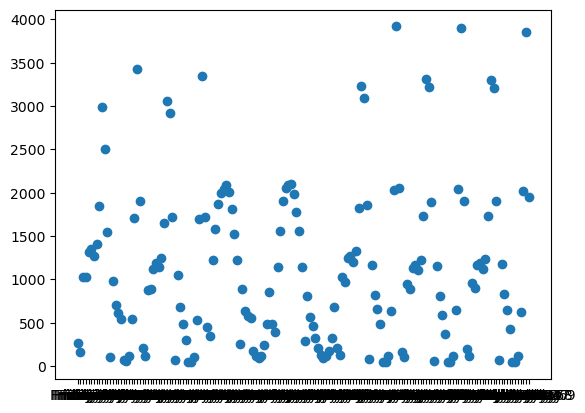

In [47]:
plt.scatter(demandcurvedf["d/c time"],demandcurvedf["total_entries"])
plt.show()

In [50]:
new_df4

date_and_hour  Duration_x  temperature_2m  precipitation  \
0     2015-01-04 00:00:00    580260.0        3.425099            0.0   
1     2015-01-04 01:00:00    287220.0        2.825937            0.0   
2     2015-01-04 02:00:00    182760.0        2.212659            0.0   
3     2015-01-04 03:00:00    102660.0        1.580961            0.0   
4     2015-01-04 04:00:00     46260.0        0.968341            0.0   
...                   ...         ...             ...            ...   
17539 2017-01-03 19:00:00    827100.0        1.719713            0.0   
17540 2017-01-03 20:00:00    413940.0        2.014031            0.0   
17541 2017-01-03 21:00:00    313380.0        1.911399            0.0   
17542 2017-01-03 22:00:00    187560.0        2.381675            0.0   
17543 2017-01-03 23:00:00    136860.0        2.652069            0.0   

       relative_humidity_2m  apparent_temperature  cloud_cover  \
0                 94.160986              0.585618    85.129661   
1                 95.827460              0.015906    79.497126   
2                 96.715603             -0.558608    64.033491   
3                 97.084124             -1.268527    55.535166   
4                 97.548201             -1.880928    47.822726   
...                     ...                   ...          ...   
17539             92.010973             -2.685429    37.199283   
17540             91.665202             -2.326640    54.617583   
17541             92.258830             -2.425880    78.288156   
17542             91.625479             -2.076911    88.309807   
17543             90.217964             -1.948537    90.000000   

       sunshine_duration  wind_speed_10m  snow_depth  total_entries_x  \
0                    0.0        7.859584         0.0            190.0   
1                    0.0        7.227020         0.0            138.0   
2                    0.0        6.382877         0.0            135.0   
3                    0.0        6.249710         0.0             73.0   
4                    0.0        5.637840         0.0             46.0   
...                  ...             ...         ...              ...   
17539                0.0       16.239235         0.0           1064.0   
17540                0.0       16.061611         0.0            544.0   
17541                0.0       16.024641         0.0            338.0   
17542                0.0       17.273016         0.0            233.0   
17543                0.0       18.306430         0.0            146.0   

       Weekday    d/c time    Duration_y  total_entries_y  Normalised Total  \
0       Sunday    Sunday 0  1.014780e+06       490.104762       -300.104762   
1       Sunday    Sunday 1  8.877383e+05       394.923810       -256.923810   
2       Sunday    Sunday 2  7.174314e+05       288.676190       -153.676190   
3       Sunday    Sunday 3  5.403314e+05       206.038095       -133.038095   
4       Sunday    Sunday 4  3.142103e+05       126.904762        -80.904762   
...        ...         ...           ...              ...               ...   
17539  Tuesday  Tuesday 19  2.138541e+06      1890.076190       -826.076190   
17540  Tuesday  Tuesday 20  1.215193e+06      1153.657143       -609.657143   
17541  Tuesday  Tuesday 21  8.627297e+05       802.895238       -464.895238   
17542  Tuesday  Tuesday 22  6.391520e+05       590.190476       -357.190476   
17543  Tuesday  Tuesday 23  4.513669e+05       368.114286       -222.114286   

       Normalised Duration  
0            -4.345200e+05  
1            -6.005183e+05  
2            -5.346714e+05  
3            -4.376714e+05  
4            -2.679503e+05  
...                    ...  
17539        -1.311441e+06  
17540        -8.012526e+05  
17541        -5.493497e+05  
17542        -4.515920e+05  
17543        -3.145069e+05  

[17544 rows x 17 columns]

# Data Transformation for Linear Regression and Machine Learning 

Below are two functions to transform the data frame into a mode that is useable for the machine learning algorithms.
The functions take in the data frame, apply the demand curve transformation. Add a additional rain variables to account for the pychological effects of rain anticipation and the physical effects of wetness. 
The function then transform the target variable "normalised number of bike hires" into discrete classes so the classification can work.
It then produces testing and training sets for both sets of variables.

In [33]:
##Function To Transform the Data Frame for linear regression and machine learning 

def Data_Frame_Transformation(DataFrame1,discrete_class):
    
    DataFrame1 =DataFrame1.reset_index()

    demandcurvedf = Demand_Curve(DataFrame1, True)
        
    DataFrame1['date_and_hour'] = pd.to_datetime(DataFrame1['date_and_hour'])
        
        
    new_df4 = Demand_Curve(DataFrame1, False)
    
    #fill blanks
    new_df4["total_entries_x"]=new_df4["total_entries_x"].fillna(0)
    new_df4["Duration_x"]=new_df4["Duration_x"].fillna(0)
    new_df4["Normalised Total"] = new_df4["total_entries_x"]-new_df4["total_entries_y"]
    new_df4["Normalised Duration"] = new_df4["Duration_x"]-new_df4["Duration_y"]
    
    new_df5= Compute_Rain_Metric(new_df4)    
    
    #create the variables for the machine learning 
    x=new_df5[["temperature_2m", "precipitation", "cloud_cover", "sunshine_duration", "wind_speed_10m", "rain_thatday","rain_last4hours"]]
       
    
    if discrete_class ==True:
        new_df5=Discrete_Class(new_df5)
        print("Hi")
        y=new_df5[["Normalised No Cat"]]
    if discrete_class ==False:
        y=new_df5[["Normalised Total"]]
    
    # split into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size= 0.3,random_state=0)
   
    return new_df5, x_train, x_test, y_train, y_test, x, y


This function computes two rain metrics. The "rain in the last 4 hours" adds up the precipitation from the last four hours, this is to account for the recent lived experiance of rain and its effects pschcologicaly on the anticipation of more rain in the next hour regardless of whether that rain materialises, and also the negative effects of a wet enviroment. "rain in that day" also does a similar thing, adding up the rain in the last 12 hours and the next 12. This gives a similar proxy but also concretises that anticipation for more rain.

In [12]:
## function to compute thte rain metrics
def Compute_Rain_Metric(Dataframe3):
    Dataframe3["rain_last4hours"] =0
    Dataframe3["rain_thatday"] = 0 
    length = len(Dataframe3["date_and_hour"])
    for i in range(12,length-12):
        Dataframe3["rain_last4hours"].loc[i] = Dataframe3["precipitation"].iloc[i-1]+Dataframe3["precipitation"].iloc[i-2]+Dataframe3["precipitation"].iloc[i-3]+Dataframe3["precipitation"].iloc[i-4]
    
        for j in range(-12,12):
            index_to_check = i + j
            if 0 <= index_to_check < length:
                Dataframe3["rain_thatday"].iloc[i] += Dataframe3["precipitation"].iloc[i+j]
            else:
                print("Index out of bounds:", index_to_check)
    shortened_dataframe = Dataframe3.iloc[12:-12]
    return  shortened_dataframe

In [44]:
new_df5, x_train, x_test, y_train, y_test,x , y = Data_Frame_Transformation(new_df2,True)

C:\Users\23510\AppData\Local\Temp\ipykernel_14060\2953066937.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Sunday' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  new_df2.at[index, "Weekday"] = days[k]
C:\Users\23510\AppData\Local\Temp\ipykernel_14060\2953066937.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Sunday 0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  new_df2.at[i, "d/c time"] = row["Weekday"] +  " " +str(row["date_and_hour"].hour)
C:\Users\23510\AppData\Local\Temp\ipykernel_14060\396795107.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataframe

C:\Users\23510\AppData\Local\Temp\ipykernel_14060\396795107.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataframe3["rain_thatday"].iloc[i] += Dataframe3["precipitation"].iloc[i+j]
C:\Users\23510\AppData\Local\Temp\ipykernel_14060\396795107.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataframe3["rain_thatday"].iloc[i] += Dataframe3["precipitation"].iloc[i+j]
C:\Users\23510\AppData\Local\Temp\ipykernel_14060\396795107.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\23510\AppData\Local\Temp\ipykernel_14060\702304576.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TrialTest["Normalised No Cat"] = 0


Hi


In [83]:
#Compute the transformation and get test and target variables.
new_df5, x_train, x_test, y_train, y_test,x , y = Data_Frame_Transformation(new_df2,False)

C:\Users\23510\AppData\Local\Temp\ipykernel_11968\396795107.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataframe3["rain_last4hours"].loc[i] = Dataframe3["precipitation"].iloc[i-1]+Dataframe3["precipitation"].iloc[i-2]+Dataframe3["precipitation"].iloc[i-3]+Dataframe3["precipitation"].iloc[i-4]
C:\Users\23510\AppData\Local\Temp\ipykernel_11968\396795107.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataframe3["rain_thatday"].iloc[i] += Dataframe3["precipitation"].iloc[i+j]
C:\Users\23510\AppData\Local\Temp\ipykernel_11968\396795107.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

C:\Users\23510\AppData\Local\Temp\ipykernel_11968\396795107.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataframe3["rain_thatday"].iloc[i] += Dataframe3["precipitation"].iloc[i+j]
C:\Users\23510\AppData\Local\Temp\ipykernel_11968\396795107.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataframe3["rain_thatday"].iloc[i] += Dataframe3["precipitation"].iloc[i+j]
C:\Users\23510\AppData\Local\Temp\ipykernel_11968\396795107.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\23510\AppData\Local\Temp\ipykernel_11968\396795107.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataframe3["rain_thatday"].iloc[i] += Dataframe3["precipitation"].iloc[i+j]
C:\Users\23510\AppData\Local\Temp\ipykernel_11968\396795107.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataframe3["rain_thatday"].iloc[i] += Dataframe3["precipitation"].iloc[i+j]
C:\Users\23510\AppData\Local\Temp\ipykernel_11968\396795107.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\23510\AppData\Local\Temp\ipykernel_11968\396795107.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataframe3["rain_thatday"].iloc[i] += Dataframe3["precipitation"].iloc[i+j]
C:\Users\23510\AppData\Local\Temp\ipykernel_11968\396795107.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataframe3["rain_thatday"].iloc[i] += Dataframe3["precipitation"].iloc[i+j]
C:\Users\23510\AppData\Local\Temp\ipykernel_11968\396795107.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [84]:
new_df5

index       date_and_hour  Duration_x  temperature_2m  precipitation  \
12        12 2015-01-04 12:00:00   1241880.0        2.862480            0.0   
13        13 2015-01-04 13:00:00   1080540.0        3.175697            0.0   
14        14 2015-01-04 14:00:00   1479780.0        3.325937            0.0   
15        15 2015-01-04 15:00:00   1837740.0        3.244477            0.0   
16        16 2015-01-04 16:00:00   1276260.0        2.789633            0.0   
...      ...                 ...         ...             ...            ...   
17527  17527 2017-01-03 07:00:00   1202700.0       -1.107620            0.0   
17528  17528 2017-01-03 08:00:00   2451600.0       -0.556304            0.0   
17529  17529 2017-01-03 09:00:00   1160460.0        0.479641            0.0   
17530  17530 2017-01-03 10:00:00    872880.0        1.988553            0.0   
17531  17531 2017-01-03 11:00:00    660720.0        3.142021            0.0   

       relative_humidity_2m  apparent_temperature  cloud_cover  \
12                81.384348             -0.581862    49.644975   
13                80.442839             -0.164712    70.599040   
14                81.154626              0.125592    82.925598   
15                83.521909             -0.042022    88.189233   
16                88.308280             -0.267143    92.626791   
...                     ...                   ...          ...   
17527             91.932925             -5.139015    25.166986   
17528             91.382158             -4.566321    35.892344   
17529             90.192339             -3.674356    13.760167   
17530             88.289781             -2.341264    36.263756   
17531             86.348720             -1.213071    32.366267   

       sunshine_duration  wind_speed_10m  snow_depth  total_entries_x  \
12           3600.000000        9.036700         0.0            877.0   
13           3600.000000        8.478598         0.0            923.0   
14           3600.000000        7.806909         0.0           1046.0   
15           3600.000000        8.746823         0.0            883.0   
16            400.595685        7.536681         0.0            749.0   
...                  ...             ...         ...              ...   
17527           0.000000       10.854292         0.0           1386.0   
17528           0.000000       11.139877         0.0           2848.0   
17529          76.353593       12.946472         0.0           1305.0   
17530        3600.000000       15.391253         0.0            684.0   
17531        3600.000000       16.479183         0.0            641.0   

       Weekday    d/c time    Duration_y  total_entries_y  Normalised Total  \
12      Sunday   Sunday 12  3.757553e+06      1901.914286      -1024.914286   
13      Sunday   Sunday 13  4.108193e+06      2055.752381      -1132.752381   
14      Sunday   Sunday 14  4.358057e+06      2091.161905      -1045.161905   
15      Sunday   Sunday 15  4.283337e+06      2096.733333      -1213.733333   
16      Sunday   Sunday 16  3.938705e+06      1988.971429      -1239.971429   
...        ...         ...           ...              ...               ...   
17527  Tuesday   Tuesday 7  1.861564e+06      2047.904762       -661.904762   
17528  Tuesday   Tuesday 8  3.606883e+06      3903.695238      -1055.695238   
17529  Tuesday   Tuesday 9  1.868095e+06      1906.447619       -601.447619   
17530  Tuesday  Tuesday 10  1.173142e+06       945.142857       -261.142857   
17531  Tuesday  Tuesday 11  1.303251e+06       886.142857       -245.142857   

       Normalised Duration  rain_last4hours  rain_thatday  
12           -2.515673e+06              0.0           0.0  
13           -3.027653e+06              0.0           0.0  
14           -2.878277e+06              0.0           0.0  
15           -2.445597e+06              0.0           0.0  
16           -2.662445e+06              0.0           0.0  
...                    ...              ...           ...  
17527        -6.588

# Correlation Analysis 

In [8]:
Correlation_Subset = new_df5[["temperature_2m","precipitation","relative_humidity_2m","apparent_temperature","cloud_cover","sunshine_duration", "wind_speed_10m","snow_depth","rain_last4hours","rain_thatday","Normalised Total","Normalised Duration"]]

In [9]:
Correlation_Subset.corr()

temperature_2m  precipitation  relative_humidity_2m  \
temperature_2m              1.000000       0.048930             -0.452974   
precipitation               0.048930       1.000000              0.151161   
relative_humidity_2m       -0.452974       0.151161              1.000000   
apparent_temperature        0.982470       0.048410             -0.351884   
cloud_cover                 0.092408       0.222139              0.159775   
sunshine_duration           0.350040      -0.081841             -0.615128   
wind_speed_10m              0.051285       0.112468             -0.161151   
snow_depth                 -0.221967      -0.022822              0.023524   
rain_last4hours             0.055605       0.585332              0.173109   
rain_thatday                0.074175       0.554108              0.204549   
Normalised Total            0.424602      -0.191670             -0.364657   
Normalised Duration         0.423454      -0.149977             -0.373630   

                      apparent_temperature  cloud_cover  sunshine_duration  \
temperature_2m                    0.982470     0.092408           0.350040   
precipitation                     0.048410     0.222139          -0.081841   
relative_humidity_2m             -0.351884     0.159775          -0.615128   
apparent_temperature              1.000000     0.072795           0.302176   
cloud_cover                       0.072795     1.000000          -0.210210   
sunshine_duration                 0.302176    -0.210210           1.000000   
wind_speed_10m                   -0.113458     0.207773           0.028480   
snow_depth                       -0.220976     0.003257          -0.017359   
rain_last4hours                   0.059080     0.204110          -0.087103   
rain_thatday                      0.077749     0.261104          -0.121711   
Normalised Total                  0.432571    -0.205665           0.309866   
Normalised Duration               0.427280    -0.201925           0.293626   

                      wind_speed_10m  snow_depth  rain_last4hours  \
temperature_2m              0.051285   -0.221967         0.055605   
precipitation               0.112468   -0.022822         0.585332   
relative_humidity_2m       -0.161151    0.023524         0.173109   
apparent_temperature       -0.113458   -0.220976         0.059080   
cloud_cover                 0.207773    0.003257         0.204110   
sunshine_duration           0.028480   -0.017359        -0.087103   
wind_speed_10m              1.000000    0.007851         0.103140   
snow_depth                  0.007851    1.000000        -0.024047   
rain_last4hours             0.103140   -0.024047         1.000000   
rain_thatday                0.130930   -0.046614         0.641600   
Normalised Total           -0.195728   -0.072330        -0.184392   
Normalised Duration        -0.177214   -0.068152        -0.152222   

                      rain_thatday  Normalised Total  Normalised Duration  
temperature_2m            0.074175          0.424602             0.423454  
precipitation             0.554108         -0.191670            -0.149977  
relative_humidity_2m      0.204549         -0.364657            -0.373630  
apparent_temperature      0.077749          0.432571             0.427280  
cloud_cover               0.261104         -0.205665            -0.201925  
sunshine_duration        -0.121711          0.309866             0.293626  
wind_speed_10m            0.130930         -0.195728            -0.177214  
snow_depth               -0.046614         -0.072330            -0.068152  
rain_last4hours           0.641600         -0.184392            -0.152222  
rain_thatday              1.000000         -0.205385            -0.163571  
Normalised Total         -0.205385          1.000000             0.843532  
Normalised Duration      -0.163571          0.843532             1.000000

The correlation analysis shows that tempreature has the biggest effect on cycling, and rain and wind also have large effects.

# Linear Regression Analysis

In [10]:
#re-intialising the vairables
x=new_df5[["temperature_2m","precipitation","relative_humidity_2m","apparent_temperature","cloud_cover","sunshine_duration", "wind_speed_10m","snow_depth","rain_last4hours","rain_thatday"]]
y=new_df5[["Normalised Total"]]

In [16]:
#processing the OLS regression
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:       Normalised Total   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     865.2
Date:                Thu, 25 Jan 2024   Prob (F-statistic):               0.00
Time:                        14:52:59   Log-Likelihood:            -1.3262e+05
No. Observations:               17520   AIC:                         2.653e+05
Df Residuals:                   17509   BIC:                         2.654e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -616.2897 

In [12]:
regr = linear_model.LinearRegression()
regr.fit(x, y)

LinearRegression()

In [86]:

csv_file_path = r"C:\Users\23510\Data Science for Urban Systems Course Work\Big Data Science Project\Pooled_data.csv"

# Save the DataFrame to a CSV file
new_df5.to_csv(csv_file_path, index=False)

In [2]:
new_df5= pd.read_csv("Pooled_data.csv")

In [88]:
print(regr.coef_)

[[ 4.15288897e+01 -1.50614380e+02 -2.13634492e+00  4.38258533e-02
  -1.34805629e+01 -1.59842299e+01 -3.07302608e+01]]


In [89]:
new_df5.describe()

index        date_and_hour    Duration_x  temperature_2m  \
count  17520.000000                17520  1.752000e+04    17520.000000   
mean    8771.500000  2016-01-04 11:30:00  1.500541e+06       10.936565   
min       12.000000  2015-01-04 12:00:00  0.000000e+00       -3.994099   
25%     4391.750000  2015-07-05 23:45:00  2.999700e+05        6.779974   
50%     8771.500000  2016-01-04 11:30:00  9.667800e+05       11.009100   
75%    13151.250000  2016-07-04 23:15:00  2.119485e+06       14.998933   
max    17531.000000  2017-01-03 11:00:00  2.250624e+07       32.423246   
std     5057.732694                  NaN  1.668260e+06        5.760477   

       precipitation  relative_humidity_2m  apparent_temperature  \
count   17520.000000          17520.000000          17520.000000   
mean        0.068975             79.477670              8.276885   
min         0.000000             32.424382             -8.260266   
25%         0.000000             70.042980              3.010923   
50%         0.000000             82.515138              8.031225   
75%         0.000000             90.753522             13.330849   
max         4.850239            100.000000             33.750704   
std         0.278352             13.752434              6.930912   

        cloud_cover  sunshine_duration  wind_speed_10m    snow_depth  \
count  17520.000000       17520.000000    17520.000000  17520.000000   
mean      59.106233        1050.285296       14.843449      0.000228   
min        0.000000           0.000000        0.268664      0.000000   
25%       26.798863           0.000000        9.566562      0.000000   
50%       64.101673           0.000000       13.844422      0.000000   
75%       97.634571        3148.782043       18.992819      0.000000   
max      100.000000        3600.000000       49.596883      0.020024   
std       35.936309        1555.379917        7.112380      0.001706   

       total_entries_x    Duration_y  total_entries_y  Normalised Total  \
count     17520.000000  1.752000e+04     17520.000000      17520.000000   
mean       1107.792865  1.499557e+06      1107.285335          0.507530   
min           0.000000  7.603371e+04        41.009524      -3917.769231   
25%         190.750000  4.624217e+05       300.019048       -160.762569   
50%         804.000000  1.303251e+06       962.182692          1.163462   
75%        1647.250000  2.049444e+06      1721.400000        204.692308   
max        8083.000000  4.358057e+06      3917.769231       4855.942308   
std        1097.283440  1.180648e+06       935.328432        573.463897   

       Normalised Duration  rain_last4hours  rain_thatday  
count         1.752000e+04     17520.000000  17520.000000  
mean          9.842620e+02         0.275902      1.655410  
min          -4.358057e+06         0.000000      0.000000  
25%          -4.248850e+05         0.000000      0.000000  
50%          -5.994143e+04         0.000000      0.199522  
75%           2.889382e+05         0.000478      1.742823  
max           2.008492e+07        16.603110     33.642823  
std           1.178272e+06         0.951248      3.293510

This next bit of work is a brief experiment to manually control variables to see how linear respones were. 

In [90]:

## limits to variables 
stdtemp = 4.266
tempmean = 11.72
stdhumid = 13.75
humidmean = 79.49
cloudstd = 10.92
cloudmean = 98.1
windstd = 8.11
windmean = 18.84
sunstd = 100
sunmean = 0

K = 0.3  # standard dev multiplier 

rainDF2 = new_df5[
    (new_df5["temperature_2m"] >= tempmean - (stdtemp * K)) & (new_df5["temperature_2m"] <= tempmean + (stdtemp * K)) &
    (new_df5["sunshine_duration"] >= sunmean - (sunstd * K)) & (new_df5["sunshine_duration"] <= sunmean + (sunstd * K)) &
    (new_df5["cloud_cover"] >= cloudmean - (cloudstd * K)) & (new_df5["cloud_cover"] <= cloudmean + (cloudstd * K)) & 
    (new_df5["wind_speed_10m"] >= windmean - (windstd * K)) & (new_df5["wind_speed_10m"] <= windmean + (windstd * K)) 
]


In [91]:
rainDF = new_df5[(new_df5["precipitation"] >= 0.5)]

In [92]:
rainDF.describe()

index                  date_and_hour    Duration_x  \
count    744.000000                            744  7.440000e+02   
mean    8308.264785  2015-12-16 04:15:53.225806592  8.024414e+05   
min      104.000000            2015-01-08 08:00:00  0.000000e+00   
25%     4884.750000            2015-07-26 12:45:00  1.611150e+05   
50%     8179.000000            2015-12-10 19:00:00  4.300200e+05   
75%    12012.750000            2016-05-18 12:45:00  1.093260e+06   
max    17493.000000            2017-01-01 21:00:00  5.963640e+06   
std     4585.875944                            NaN  9.903371e+05   

       temperature_2m  precipitation  relative_humidity_2m  \
count      744.000000     744.000000            744.000000   
mean        11.773610       1.153612             88.824345   
min          1.142922       0.500000             52.756769   
25%          8.365305       0.689145             86.063119   
50%         11.587061       0.942584             90.802005   
75%         15.301206       1.401495             93.449888   
max         23.030303       4.850239             99.670554   
std          4.254915       0.688943              7.203902   

       apparent_temperature  cloud_cover  sunshine_duration  wind_speed_10m  \
count            744.000000   744.000000         744.000000      744.000000   
mean               9.193605    92.959868         433.773555       18.633978   
min               -4.271484    16.700957           0.000000        0.773174   
25%                4.147842    99.846233           0.000000       13.129657   
50%                8.858995   100.000000           0.000000       17.860747   
75%               14.037457   100.000000           0.000000       23.259055   
max               25.416605   100.000000        3600.000000       48.114304   
std                5.947296    16.189843        1099.860883        8.496332   

       snow_depth  total_entries_x    Duration_y  total_entries_y  \
count  744.000000       744.000000  7.440000e+02       744.000000   
mean     0.000013       681.209677  1.624677e+06      1201.637317   
min      0.000000         0.000000  7.603371e+04        41.009524   
25%      0.000000       146.750000  6.384657e+05       484.314286   
50%      0.000000       421.500000  1.473245e+06      1125.180952   
75%      0.000000       926.500000  2.138541e+06      1731.682692   
max      0.010000      4133.000000  4.358057e+06      3917.769231   
std      0.000367       764.025671  1.140357e+06       911.842970   

       Normalised Total  Normalised Duration  rain_last4hours  rain_thatday  
count        744.000000         7.440000e+02       744.000000    744.000000  
mean        -520.427640        -8.222352e+05         2.554019      9.123766  
min        -3917.769231        -4.358057e+06         0.000000      0.589952  
25%         -836.576923        -1.306191e+06         0.705263      4.604545  
50%         -354.271429        -6.300398e+05         1.802632      7.191388  
75%          -61.292674        -1.523958e+05         3.631998     12.254067  
max         1022.788462         2.538157e+06        16.603110     33.642823  
std          672.766110         1.049086e+06         2.495419      6.310609

In [93]:
rainDF2

index       date_and_hour  Duration_x  temperature_2m  precipitation  \
101      101 2015-01-08 05:00:00     75480.0       10.880064       0.000478   
102      102 2015-01-08 06:00:00    413040.0       10.730183       0.000478   
1283    1283 2015-02-26 11:00:00    196740.0       10.511762       0.000000   
1526    1526 2015-03-08 14:00:00   4271460.0       11.500458       0.000000   
1527    1527 2015-03-08 15:00:00   2700660.0       11.513317       0.000000   
...      ...                 ...         ...             ...            ...   
16960  16960 2016-12-10 16:00:00   1252140.0       12.212719       0.152153   
16961  16961 2016-12-10 17:00:00    524160.0       11.880542       0.251914   
17220  17220 2016-12-21 12:00:00   1079400.0       10.588078       0.000000   
17221  17221 2016-12-21 13:00:00   1598640.0       10.862480       0.000000   
17222  17222 2016-12-21 14:00:00   1121100.0       10.604944       0.000000   

       relative_humidity_2m  apparent_temperature  cloud_cover  \
101               92.588152              7.908037   100.000000   
102               93.355426              8.220207   100.000000   
1283              91.131507              7.305217   100.000000   
1526              77.960283              8.010359    99.023687   
1527              79.102386              8.208348   100.000000   
...                     ...                   ...          ...   
16960             90.974336              9.816945   100.000000   
16961             90.620776              9.177349   100.000000   
17220             91.406666              7.332068   100.000000   
17221             89.777441              7.800251   100.000000   
17222             84.281623              7.532458   100.000000   

       sunshine_duration  wind_speed_10m  snow_depth  total_entries_x  \
101             0.000000       19.960759         0.0             90.0   
102             0.000000       16.743416         0.0            538.0   
1283            0.000000       20.432624         0.0            273.0   
1526            0.271483       19.989838         0.0           2029.0   
1527            0.000000       19.111626         0.0           1651.0   
...                  ...             ...         ...              ...   
16960           0.000000       18.106659         0.0            792.0   
16961           0.000000       19.431084         0.0            593.0   
17220           0.000000       20.996442         0.0           1135.0   
17221           0.000000       19.675080         0.0           1181.0   
17222           0.000000       17.599661         0.0           1148.0   

         Weekday      d/c time    Duration_y  total_entries_y  \
101     Thursday    Thursday 5  1.244469e+05       114.394231   
102     Thursday    Thursday 6  5.743713e+05       639.076923   
1283    Thursday   Thursday 11  1.334965e+06       965.990385   
1526      Sunday     Sunday 14  4.358057e+06      2091.161905   
1527      Sunday     Sunday 15  4.283337e+06      2096.733333   
...          ...           ...           ...              ...   
16960   Saturday   Saturday 16  3.761594e+06      2003.134615   
16961   Saturday   Saturday 17  3.139209e+06      1815.451923   
17220  Wednesday  Wednesday 12  1.463528e+06      1164.365385   
17221  Wednesday  Wednesday 13  1.589026e+06      1193.596154   
17222  Wednesday  Wednesday 14  1.665918e+06      1121.865385   

       Normalised Total  Normalised Duration  rain_last4hours  rain_thatday  
101          -24.394231        -4.896692e+04         0.000000     13.292584  
102         -101.076923        -1.613313e+05         0.000478     13.292584  
1283        -692.990385        -1.138225e+06         0.000000      3.944737  
1526         -62.161905        -8.659657e+04         0.000000      0.000000  
1527        -445.733333        -1.582677e+06         0.000000      0.000000  
...                 ...                  ...              ...           ...  
16960      -1211.134615        -2.509454e+06         0.760766

In [94]:
rainDF2["precipitation"].value_counts()

precipitation
0.000000    158
0.000478      2
0.246890      2
0.000239      2
0.152153      2
0.251914      2
1.293541      1
0.895215      1
0.547847      1
0.595694      1
0.248086      1
0.200239      1
0.652153      1
0.341627      1
0.942345      1
0.095215      1
0.247847      1
0.200957      1
0.656938      1
1.492584      1
0.252392      1
1.299761      1
1.547608      1
1.242823      1
0.394737      1
1.473206      1
0.603589      1
0.047847      1
0.100239      1
0.354067      1
0.500239      1
0.209569      1
1.100957      1
0.805263      1
0.147129      1
0.047368      1
0.353349      1
0.442105      1
0.853589      1
3.632775      1
2.172249      1
0.104785      1
0.404785      1
0.600000      1
0.548086      1
0.148325      1
0.452392      1
0.399522      1
0.853349      1
0.605263      1
0.605502      1
0.100478      1
1.300000      1
1.146651      1
1.567464      1
0.453110      1
0.346890      1
0.453349      1
0.157177      1
0.394019      1
Name: count, dtype: int64

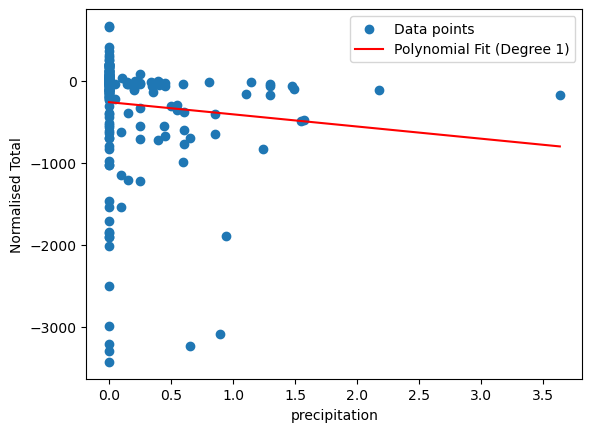

In [104]:
variable1 = 'precipitation'
variable2 = 'Normalised Total'

# Convert variables to numerical arrays
x_data = pd.to_numeric(rainDF2[variable1], errors='coerce')
y_data = pd.to_numeric(rainDF2[variable2], errors='coerce')

# Fit a polynomial regression model 
degree = 1
fit_params = np.polyfit(x_data, y_data, degree)
fit_curve = np.poly1d(fit_params)

# Create a scatter plot
plt.scatter(x_data, y_data, label='Data points')

# Plot the curve of best fit
x_fit = np.linspace(min(x_data), max(x_data), 100)  # Generate 100 points for smoother curve
plt.plot(x_fit, fit_curve(x_fit), color='red', label=f'Polynomial Fit (Degree {degree})')

# Add labels and legend
plt.xlabel(variable1)
plt.ylabel(variable2)
plt.legend()

# Show the plot
plt.show()


In [112]:
lr = LinearRegression()

In [113]:
lr.fit(x_train,y_train)

LinearRegression()

In [114]:
c= lr.intercept_
c

array([-126.80161352])

In [115]:
m = lr.coef_
m

array([[ 4.12704782e+01, -1.55176277e+02, -2.21914335e+00,
         4.41823749e-02, -1.30688407e+01, -1.57936943e+01,
        -3.18381658e+01]])

In [116]:
y_pred_train = lr.predict(x_train)
y_pred_train 

array([[-185.15241743],
       [-109.91126581],
       [ 397.07374   ],
       ...,
       [ 115.18835925],
       [ -18.31036817],
       [  66.22288821]])

Text(0, 0.5, 'Predicted Normalised No hires')

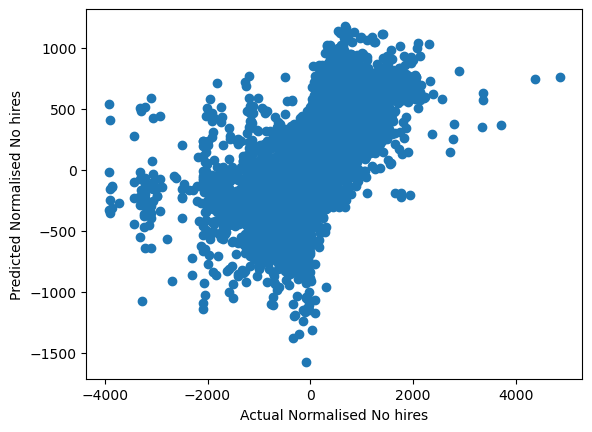

In [117]:
plt.scatter(y_train,y_pred_train)
plt.xlabel("Actual Normalised No hires")
plt.ylabel("Predicted Normalised No hires")

The plot shows clear correlation but with some definite variability thats not accounted for by the model.

In [118]:
r2_score(y_train, y_pred_train)

0.3143974640164209

This relatively low R2 scored showed that the current model can only account for a moderate amount of the behaviour.

Text(0, 0.5, 'Predicted Normalised No hires')

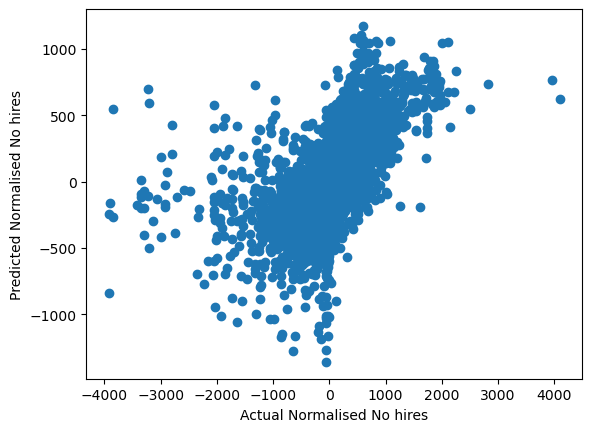

In [119]:
y_pred_test = lr.predict(x_test)
plt.scatter(y_test,y_pred_test)
plt.xlabel("Actual Normalised No hires")
plt.ylabel("Predicted Normalised No hires")

In [120]:
r2_score(y_test, y_pred_test)

0.32125673591377846

# Try other models

In [35]:
## in order to do classifier must turn dependent variable into discrete classes 
def Discrete_Class(TrialTest):
    TrialTest["Normalised No Cat"] = 0

    for index, row in TrialTest.iterrows():
        if row["Normalised Total"] > TrialTest["Normalised Total"].quantile(0.80):
            TrialTest.at[index, "Normalised No Cat"] = 2
        elif row["Normalised Total"] > TrialTest["Normalised Total"].quantile(0.60):
            TrialTest.at[index, "Normalised No Cat"] = 1
        elif row["Normalised Total"] > TrialTest["Normalised Total"].quantile(0.40):
            TrialTest.at[index, "Normalised No Cat"] = 0
        elif row["Normalised Total"] > TrialTest["Normalised Total"].quantile(0.20):
            TrialTest.at[index, "Normalised No Cat"] = -1
        elif row["Normalised Total"] > TrialTest["Normalised Total"].quantile(0.0):
            TrialTest.at[index, "Normalised No Cat"] = -2
    return TrialTest

In [36]:
new_df5, x_train, x_test, y_train, y_test,x , y = Data_Frame_Transformation(new_df2,True)

C:\Users\23510\AppData\Local\Temp\ipykernel_14060\2953066937.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Sunday' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  new_df2.at[index, "Weekday"] = days[k]
C:\Users\23510\AppData\Local\Temp\ipykernel_14060\2953066937.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Sunday 0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  new_df2.at[i, "d/c time"] = row["Weekday"] +  " " +str(row["date_and_hour"].hour)
C:\Users\23510\AppData\Local\Temp\ipykernel_14060\396795107.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataframe

C:\Users\23510\AppData\Local\Temp\ipykernel_14060\396795107.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataframe3["rain_last4hours"].loc[i] = Dataframe3["precipitation"].iloc[i-1]+Dataframe3["precipitation"].iloc[i-2]+Dataframe3["precipitation"].iloc[i-3]+Dataframe3["precipitation"].iloc[i-4]
C:\Users\23510\AppData\Local\Temp\ipykernel_14060\396795107.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataframe3["rain_last4hours"].loc[i] = Dataframe3["precipitation"].iloc[i-1]+Dataframe3["precipitation"].iloc[i-2]+Dataframe3["precipitation"].iloc[i-3]+Dataframe3["precipitation"].iloc[i-4]
C:\Users\23510\AppDa

Hi


In [38]:
def confusion_matrix_print(y_test, y_pred):
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    class_labels = ['Very Low', 'Low', 'Little Change', 'High', 'Very High']
    
    
    confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis] * 100

    plt.matshow(confusion_matrix)
    tick_marks = range(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
        
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    
    metrics_per_class = {}
    for i, label in enumerate(class_labels):
        precision = metrics.precision_score(y_test, y_pred, labels=[i], average='micro')
        recall = metrics.recall_score(y_test, y_pred, labels=[i], average='micro')
        f1 = metrics.f1_score(y_test, y_pred, labels=[i], average='micro')
        metrics_per_class[label] = {'Precision': precision, 'Recall': recall, 'F1-Score': f1}

    # Print metrics_per_class dictionary
    print("\nMetrics for each class:")
    for label, metrics_dict in metrics_per_class.items():
        print(f"\nClass: {label}")
        for metric_name, metric_value in metrics_dict.items():
            print(f"{metric_name}: {metric_value:.2f}")

    return
    

In [23]:
def Decision_Tree(x_train, y_train, x_test, y_test, Table, Print_Graphs, feature_names):
    ## The diffrent types of decision tree
    Criteria_Array= ["gini", "log_loss", "entropy"]
    average_option = 'weighted' 
    
    ## Looping through the diffrent types 
    for Depth in range (2,8):
        for i in range(0,3):
            ## Calculate execution time
            start = time.time();
    
            D_T = DecisionTreeClassifier(criterion = Criteria_Array[i], max_depth= Depth, random_state=0)
            D_T.fit(x_train, y_train)
            y_pred = D_T.predict(x_test)
            timeTaken = time.time() - start
        
            if Print_Graphs == True:
                
                print(Criteria_Array[i], "Max Depth: ", Depth)
                if Depth <5:
                    ## Visulation 
                    fig = plt.figure(figsize=(25,20))
                    tree.plot_tree(D_T, feature_names= feature_names, class_names=["Very Low","Low", "little change", "high", "very high"], filled=True);
        
            
                #Confusion Matrix 
                confusion_matrix_print(y_test, y_pred)
            
            ## Table of Results 
            new_row= pd.DataFrame({'Machine_Learning_Algorithm': Criteria_Array[i] + "Max Depth: " + str(Depth), 'Recall':recall_score(y_test,y_pred, average= average_option), 'Precision':precision_score(y_test,y_pred,average= average_option), 'F1_Score':f1_score(y_test,y_pred,average= average_option) ,"Run_time":timeTaken }, index=[0])
            Table = pd.concat([new_row,Table.loc[:]]).reset_index(drop=True)
       
        
    return Table

In [24]:
## intiate table
Table=pd.DataFrame(columns=['Machine_Learning_Algorithm',"Recall","Precision","F1_Score","Run_time"]) 

gini Max Depth:  2


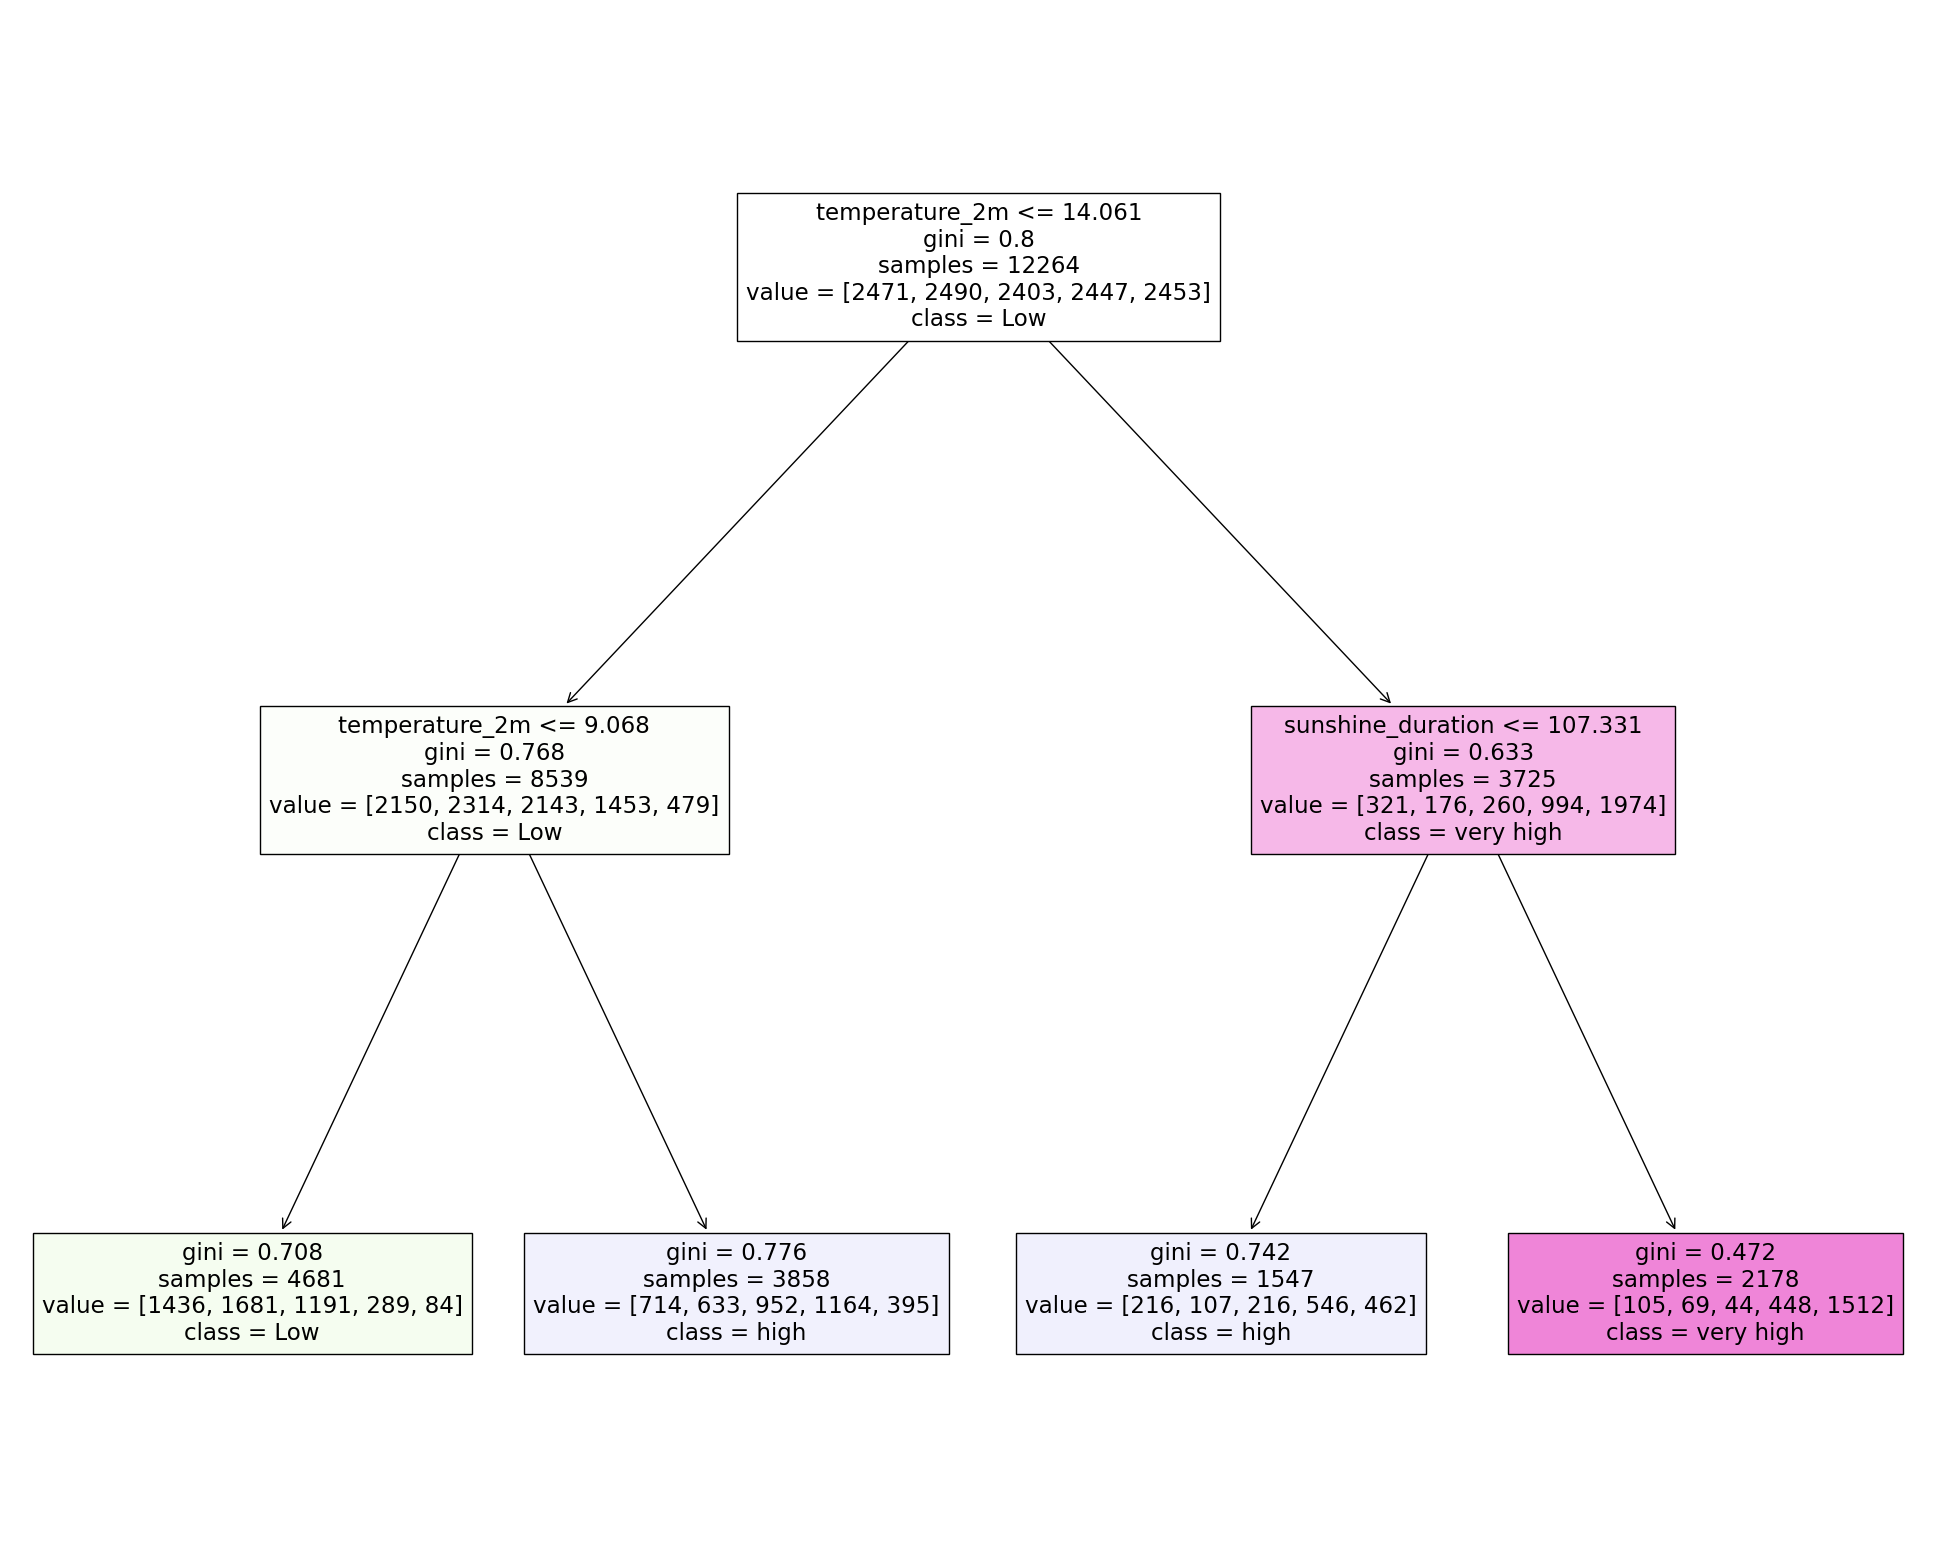

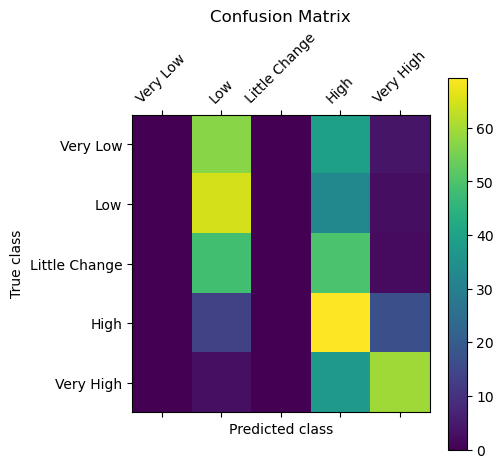

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-def


Metrics for each class:

Class: Very Low
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Class: Low
Precision: 0.30
Recall: 0.69
F1-Score: 0.42

Class: Little Change
Precision: 0.70
Recall: 0.60
F1-Score: 0.65

Class: High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Class: Very High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
log_loss Max Depth:  2


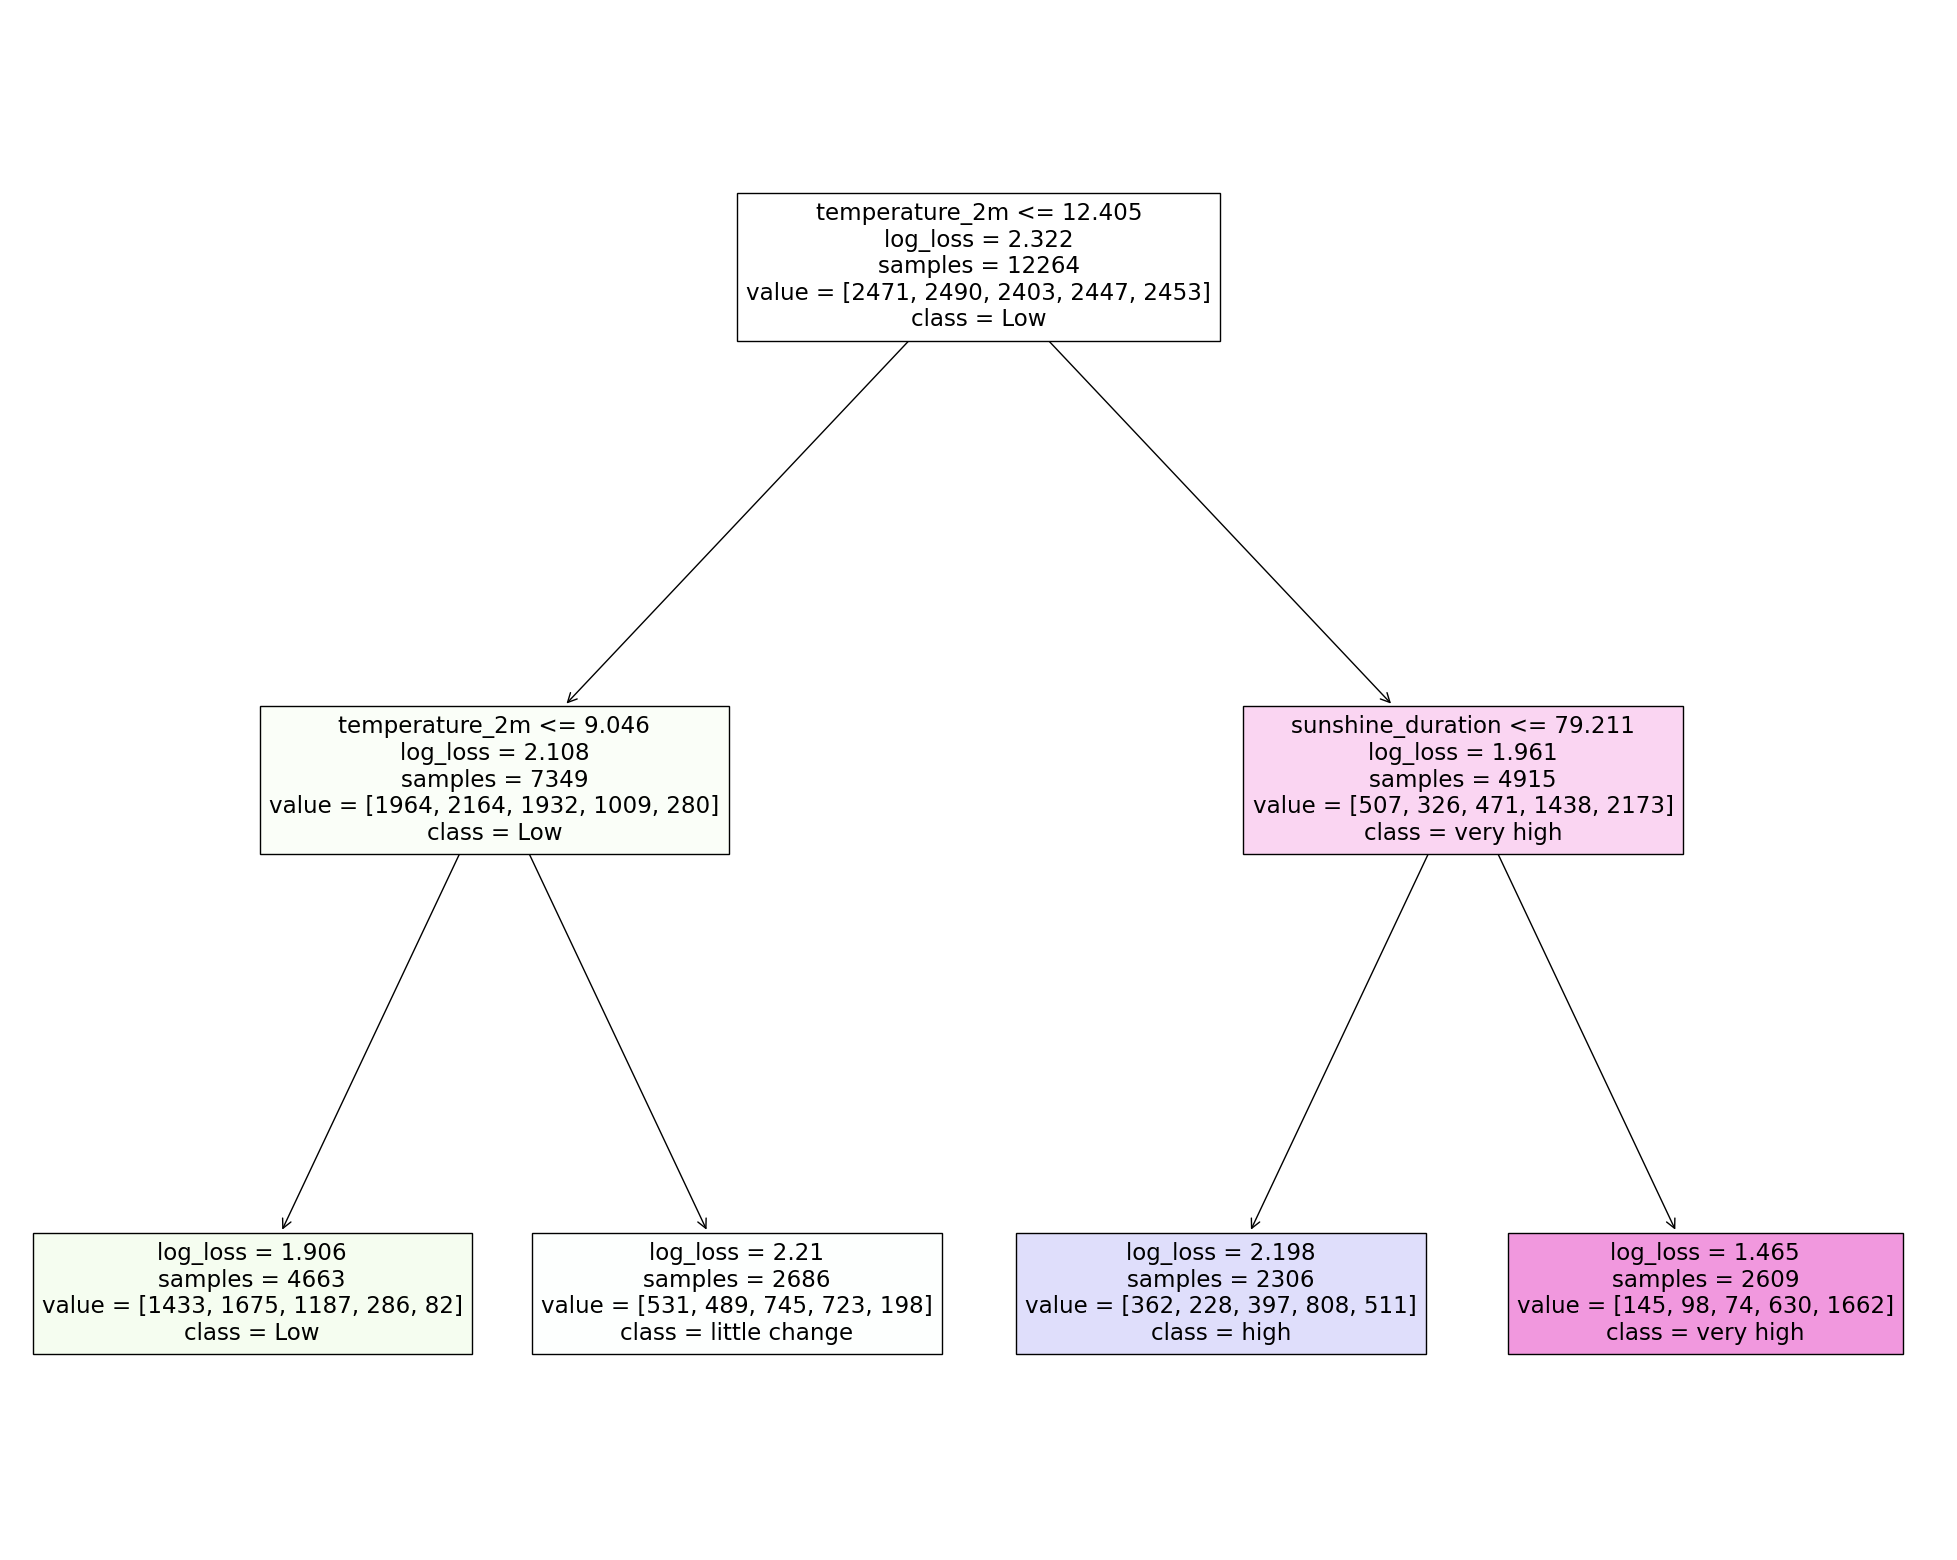

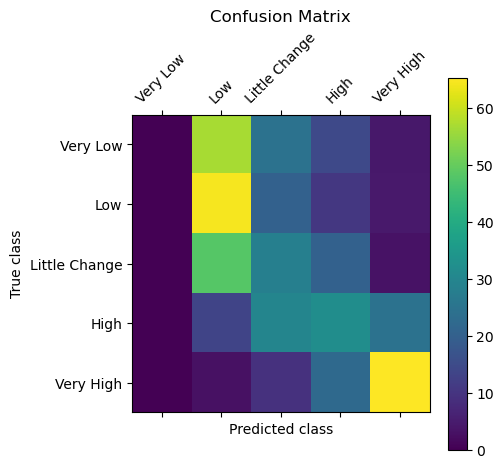

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWar


Metrics for each class:

Class: Very Low
Precision: 0.26
Recall: 0.28
F1-Score: 0.27

Class: Low
Precision: 0.32
Recall: 0.32
F1-Score: 0.32

Class: Little Change
Precision: 0.64
Recall: 0.65
F1-Score: 0.65

Class: High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Class: Very High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
entropy Max Depth:  2


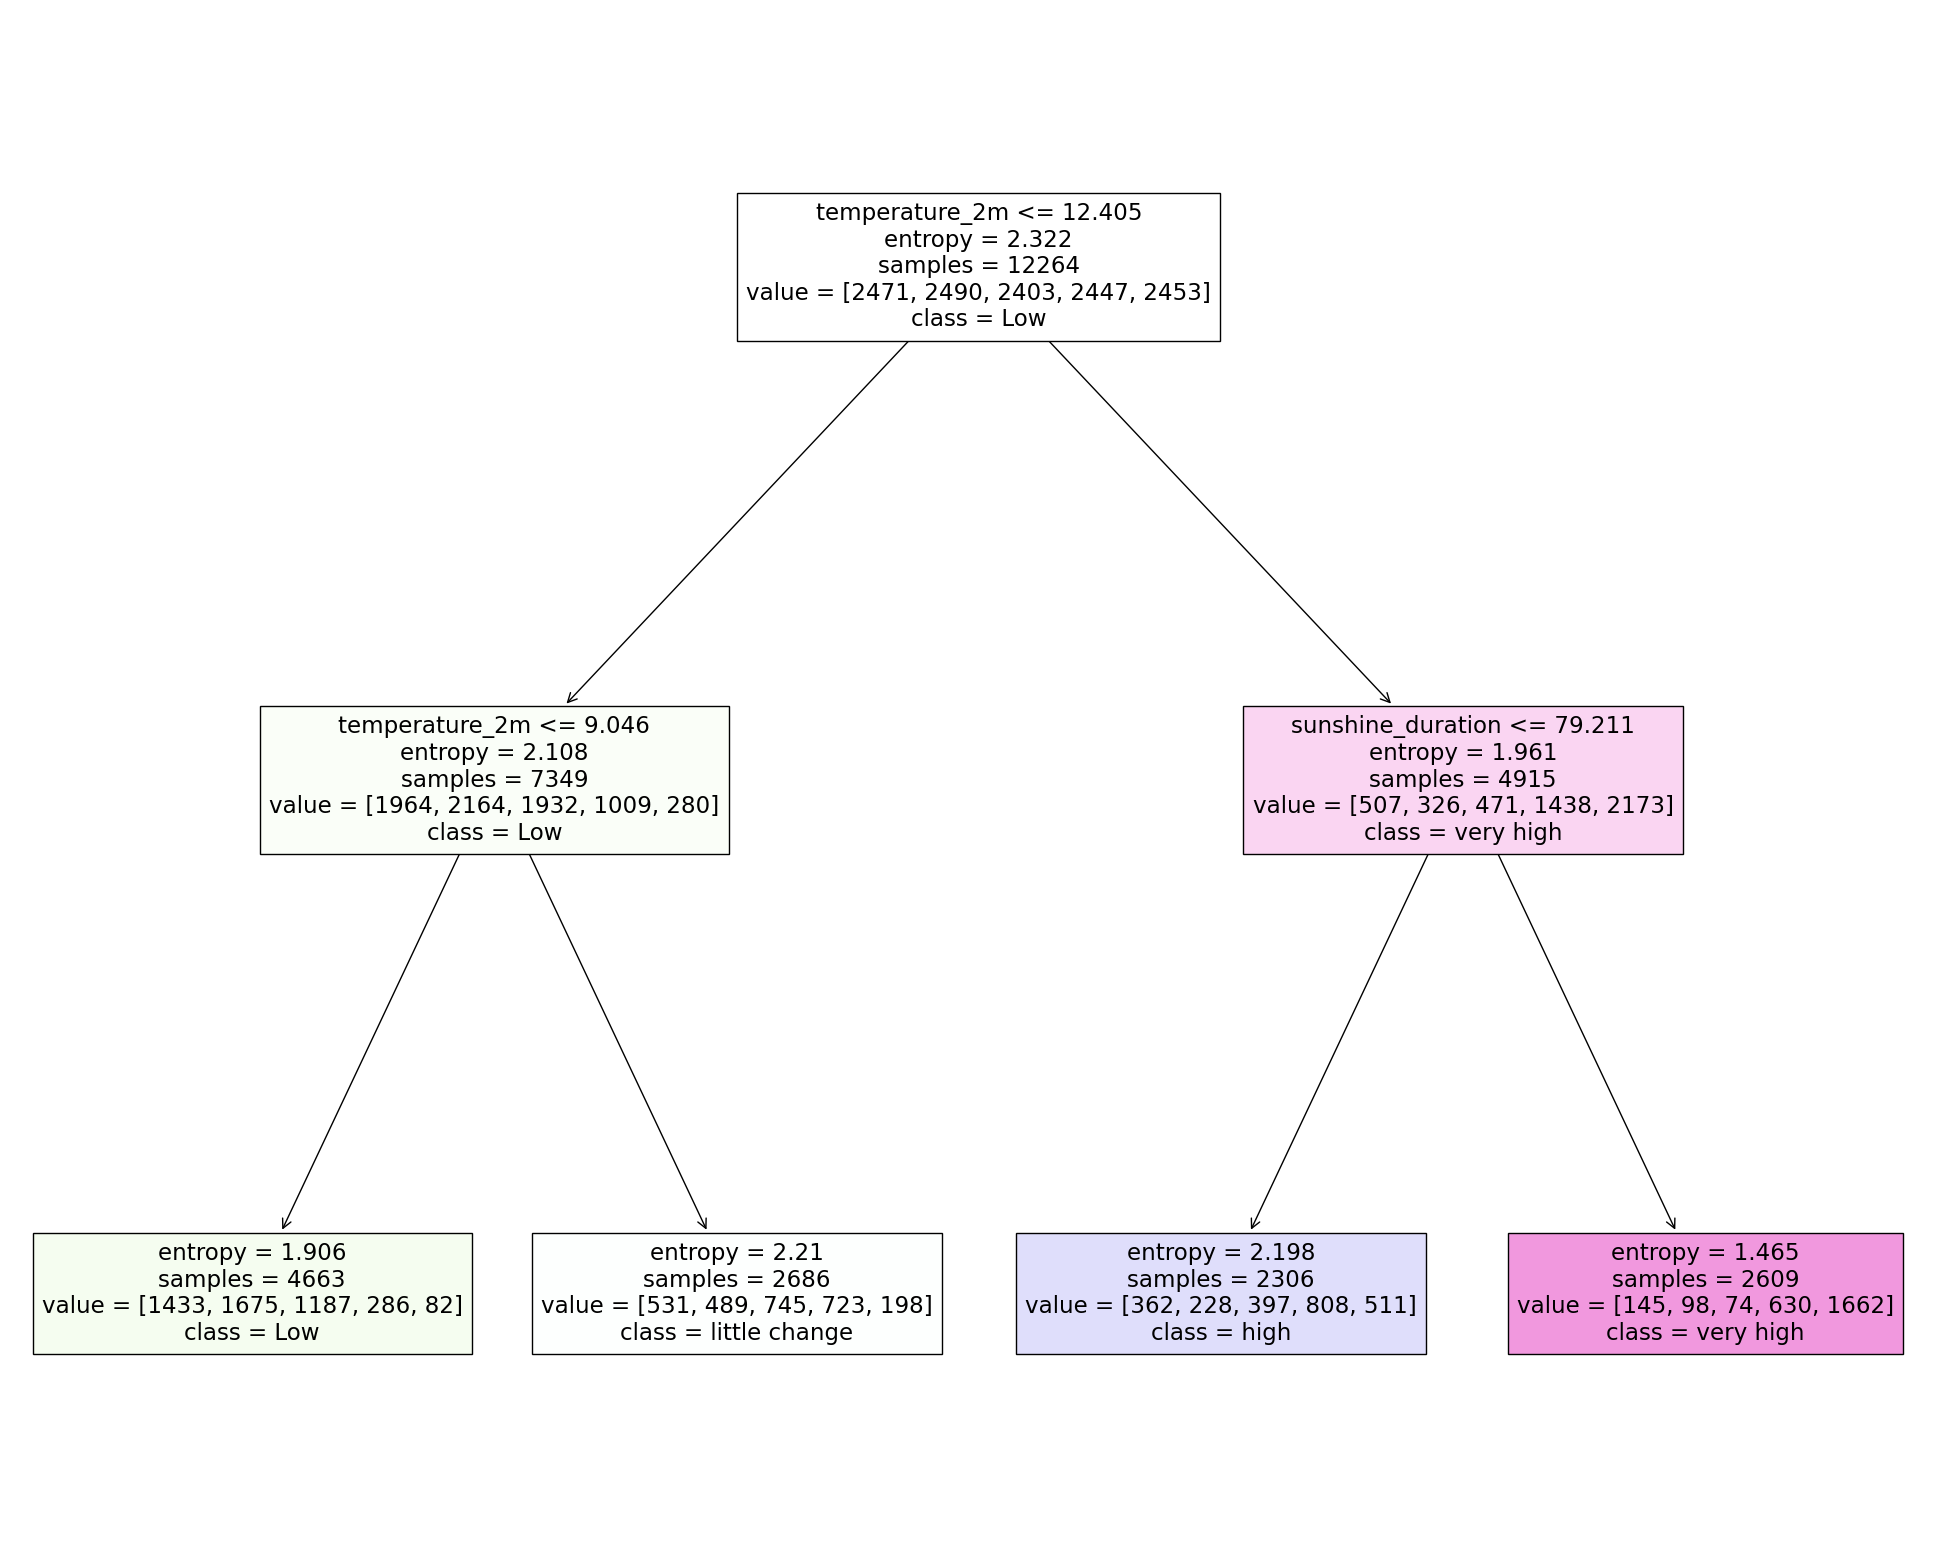

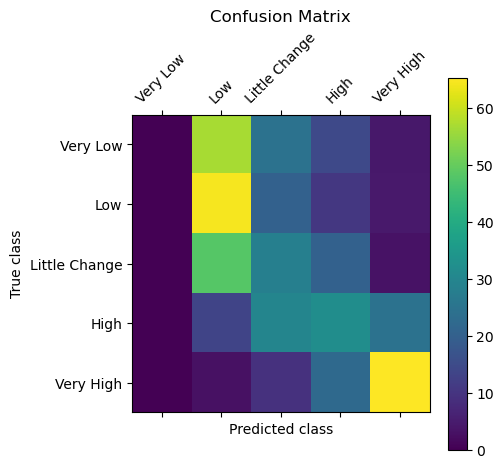

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWar


Metrics for each class:

Class: Very Low
Precision: 0.26
Recall: 0.28
F1-Score: 0.27

Class: Low
Precision: 0.32
Recall: 0.32
F1-Score: 0.32

Class: Little Change
Precision: 0.64
Recall: 0.65
F1-Score: 0.65

Class: High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Class: Very High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
gini Max Depth:  3


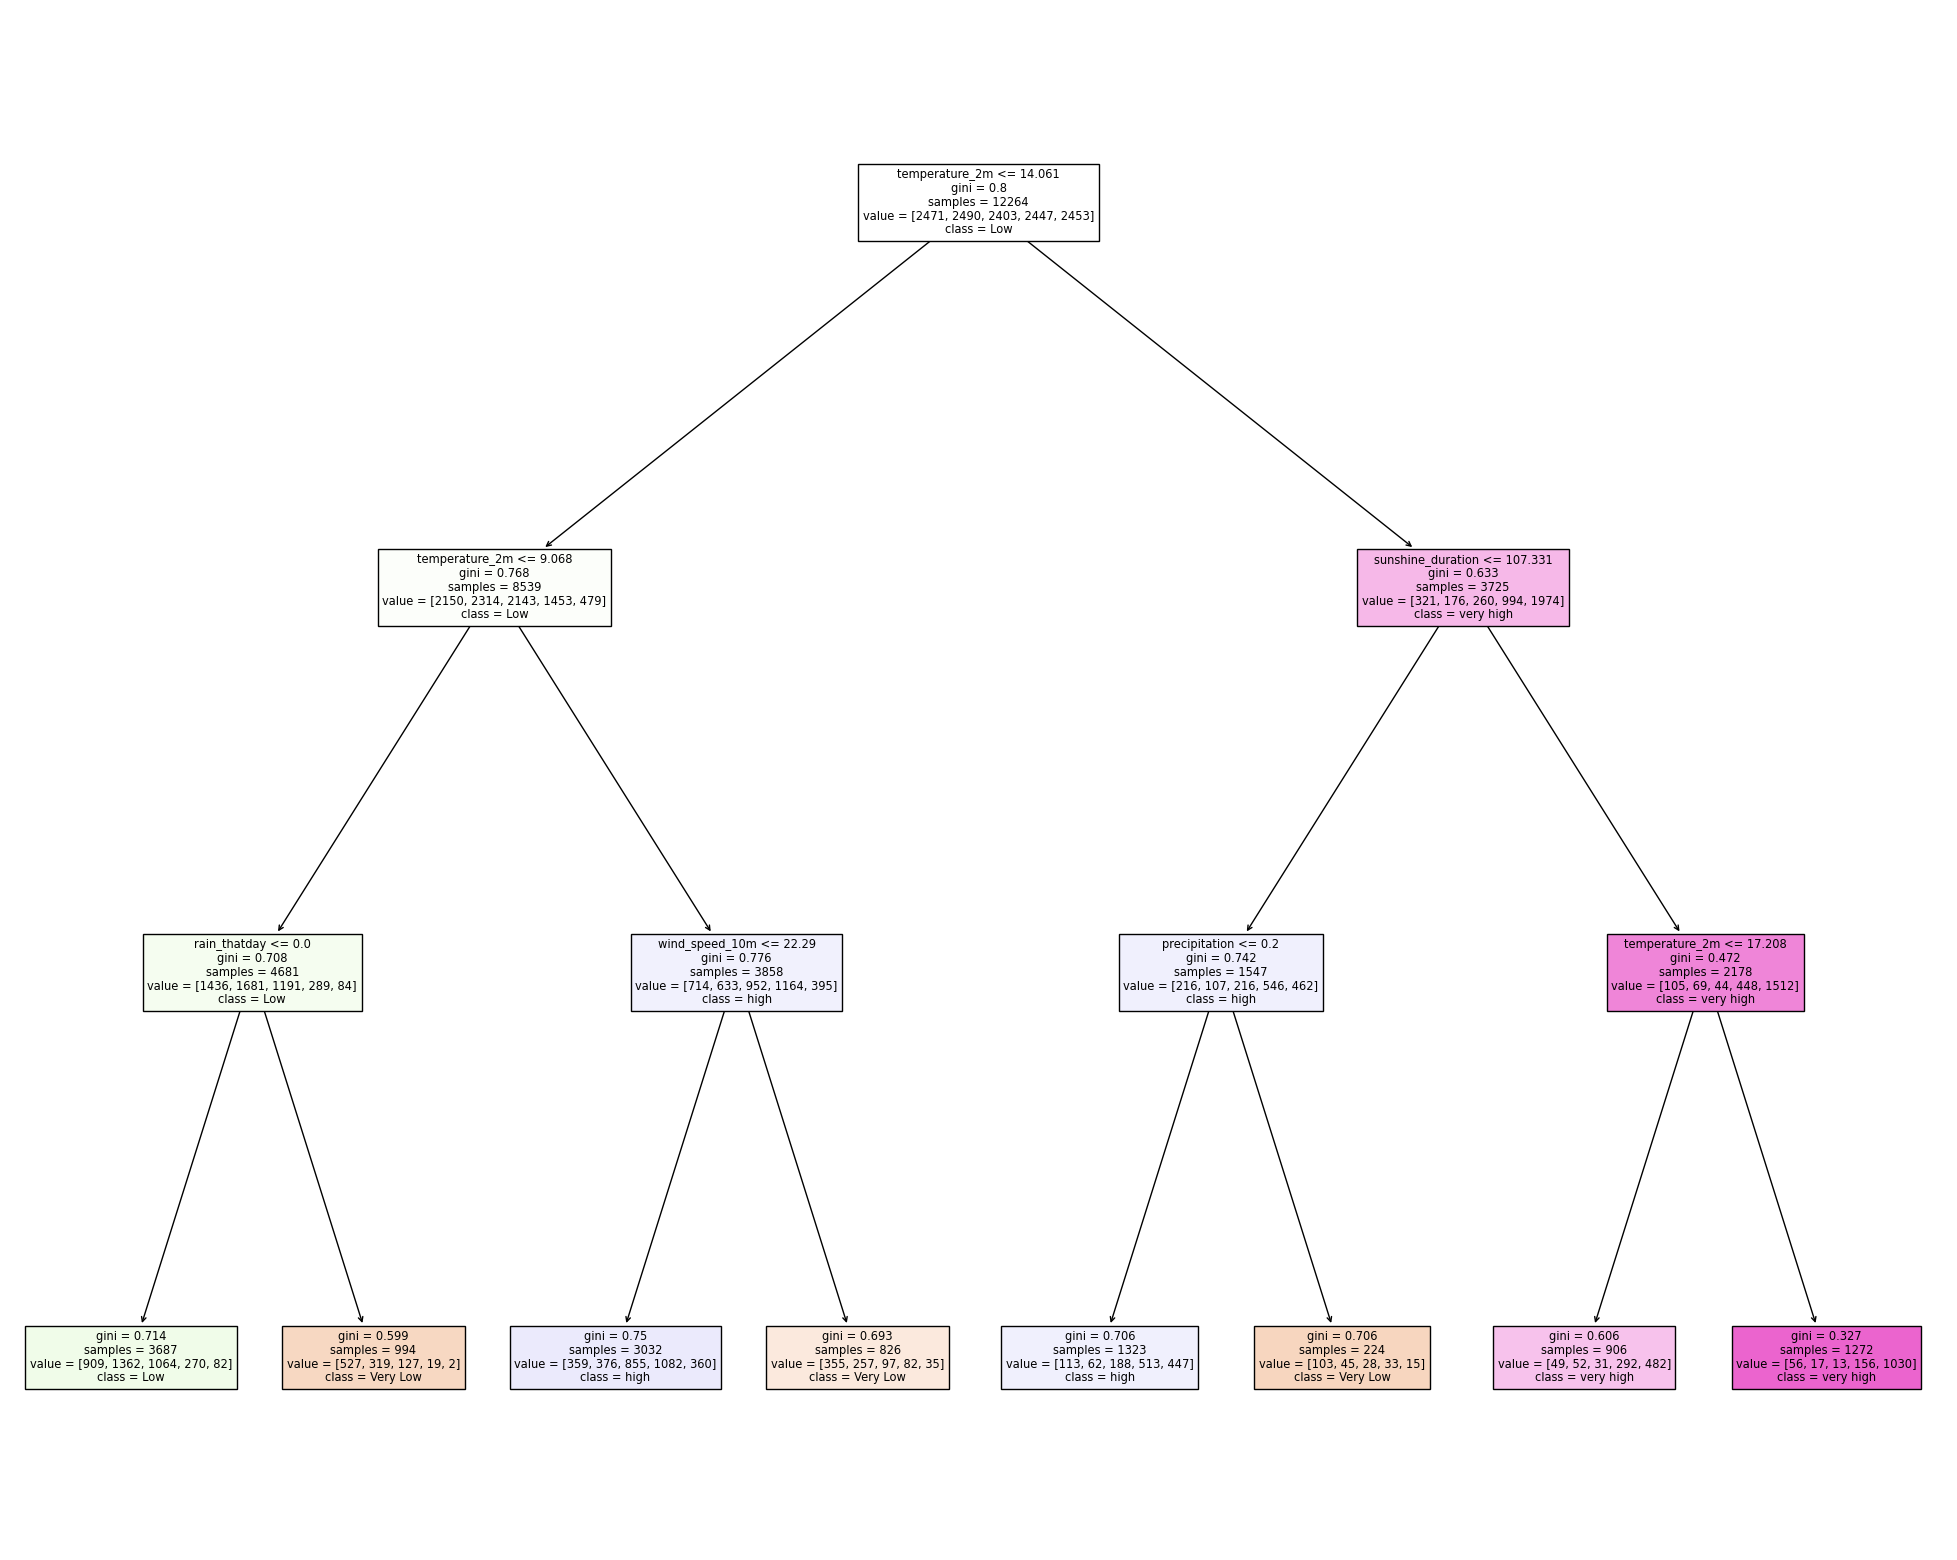

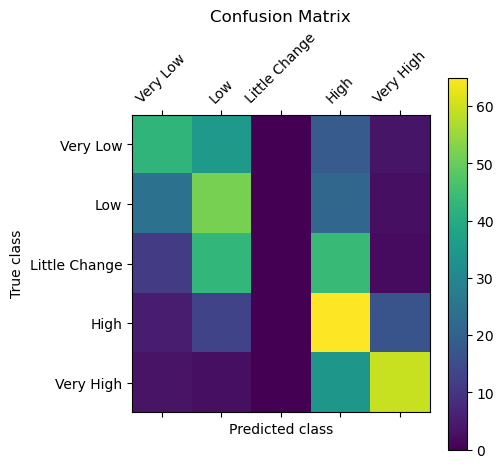

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-def


Metrics for each class:

Class: Very Low
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Class: Low
Precision: 0.35
Recall: 0.65
F1-Score: 0.46

Class: Little Change
Precision: 0.70
Recall: 0.60
F1-Score: 0.65

Class: High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Class: Very High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
log_loss Max Depth:  3


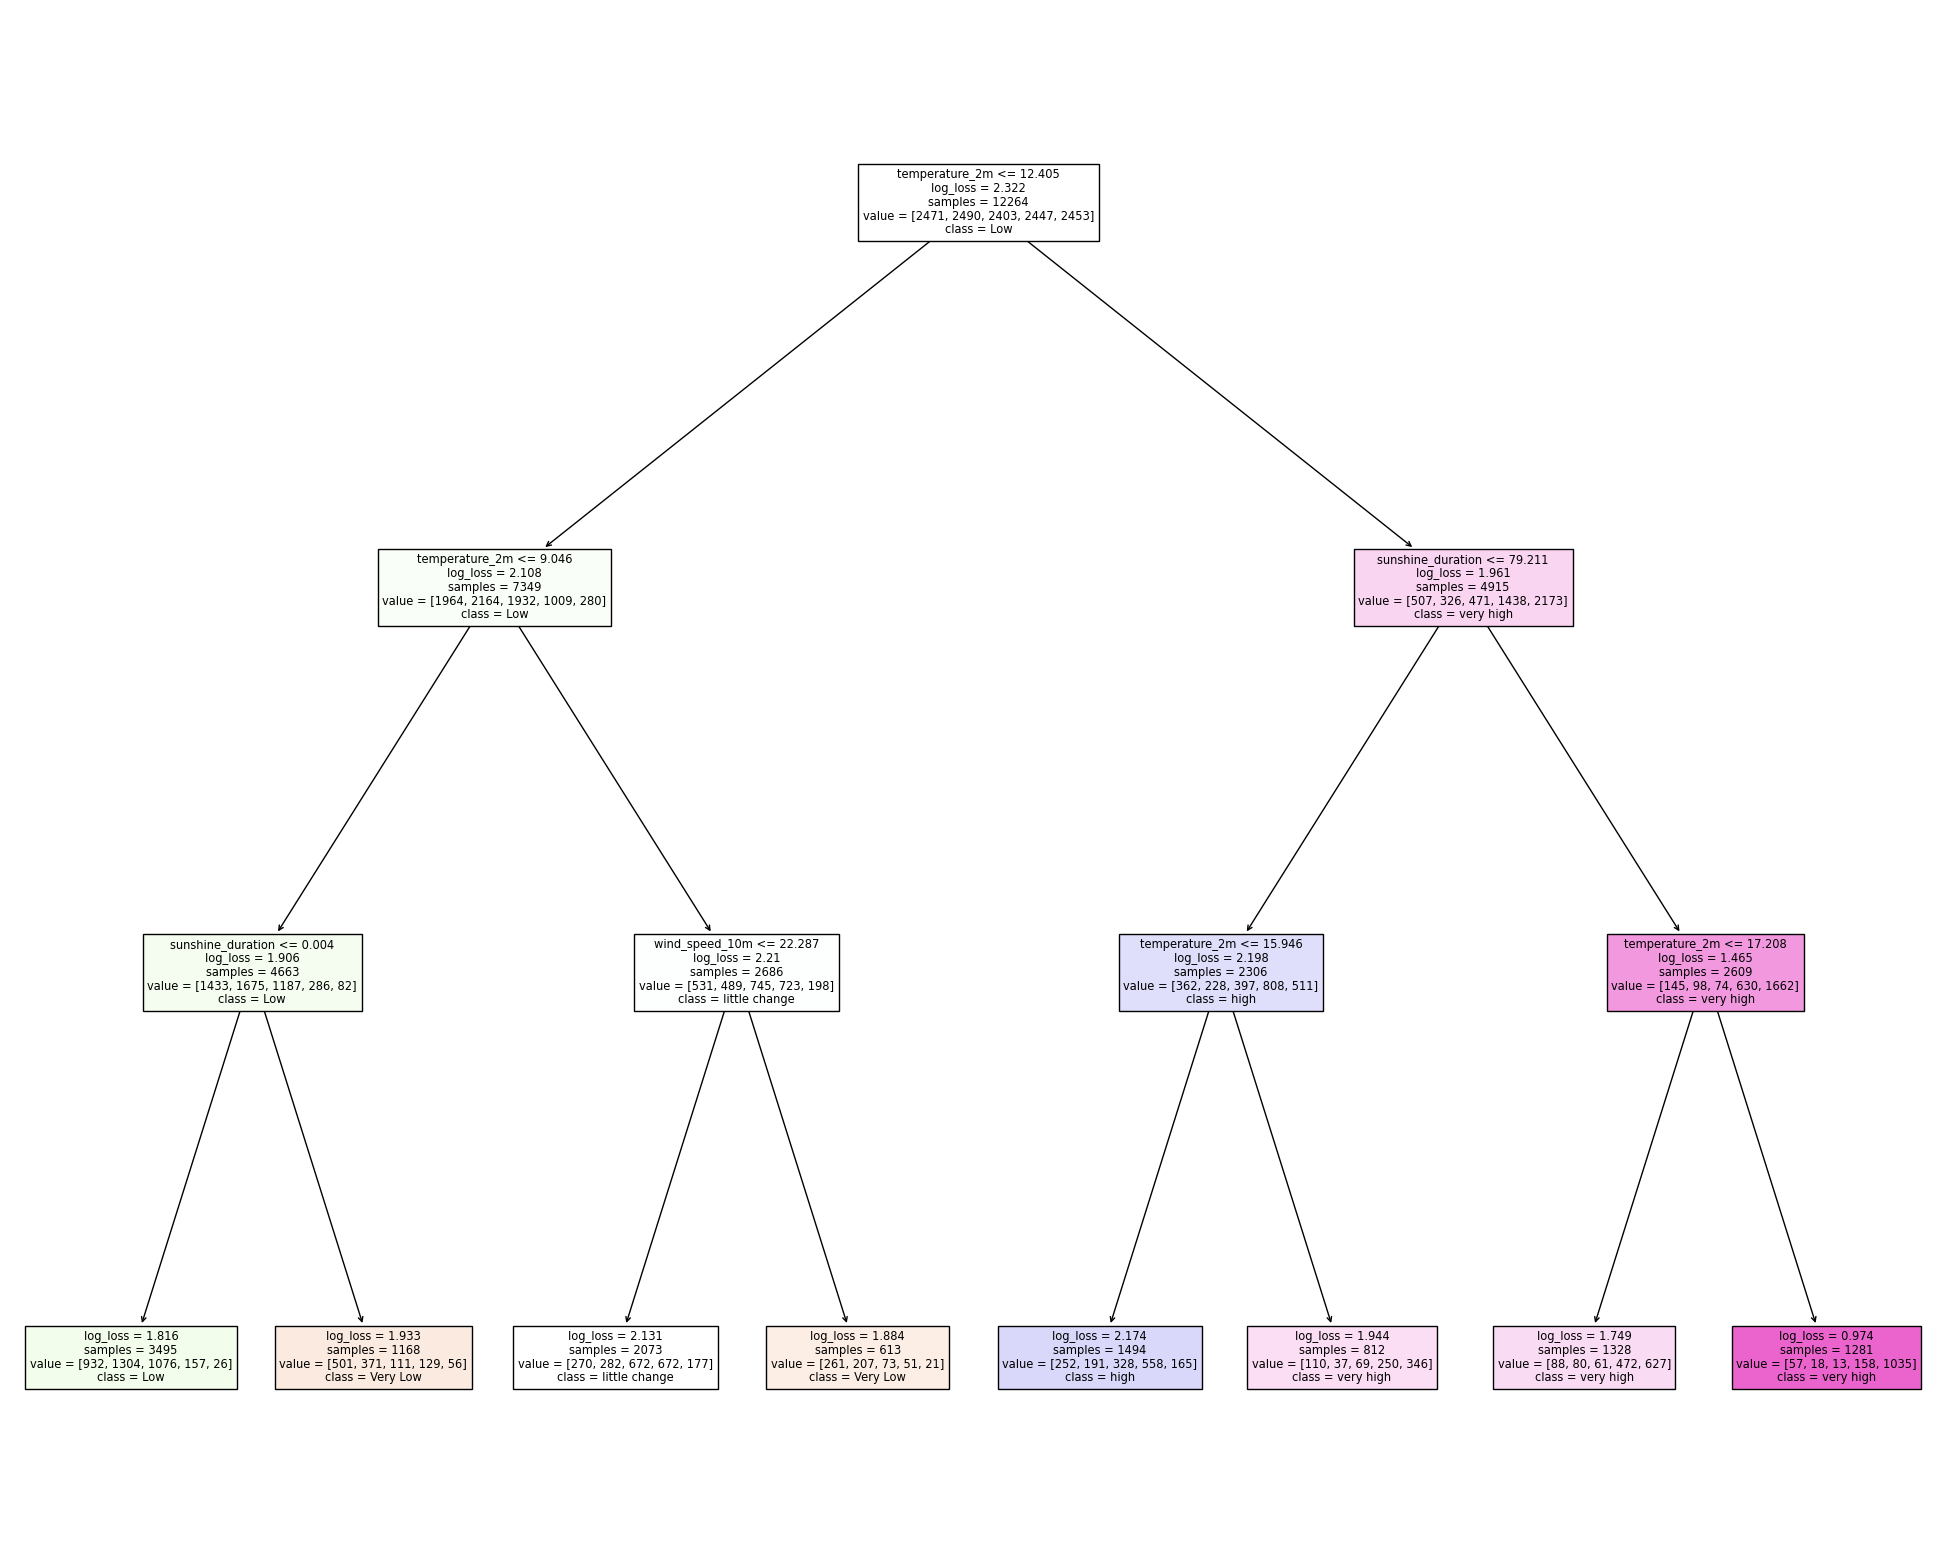

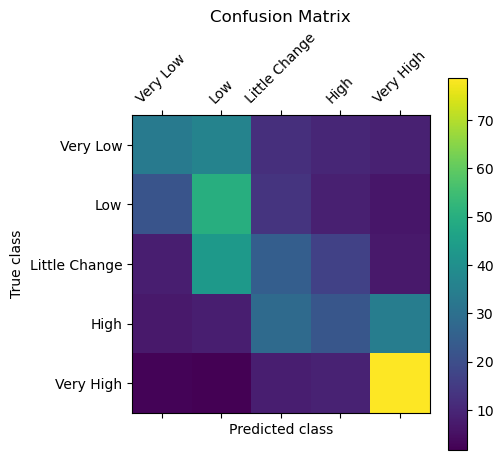

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWar


Metrics for each class:

Class: Very Low
Precision: 0.30
Recall: 0.25
F1-Score: 0.27

Class: Low
Precision: 0.33
Recall: 0.22
F1-Score: 0.27

Class: Little Change
Precision: 0.58
Recall: 0.79
F1-Score: 0.67

Class: High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Class: Very High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
entropy Max Depth:  3


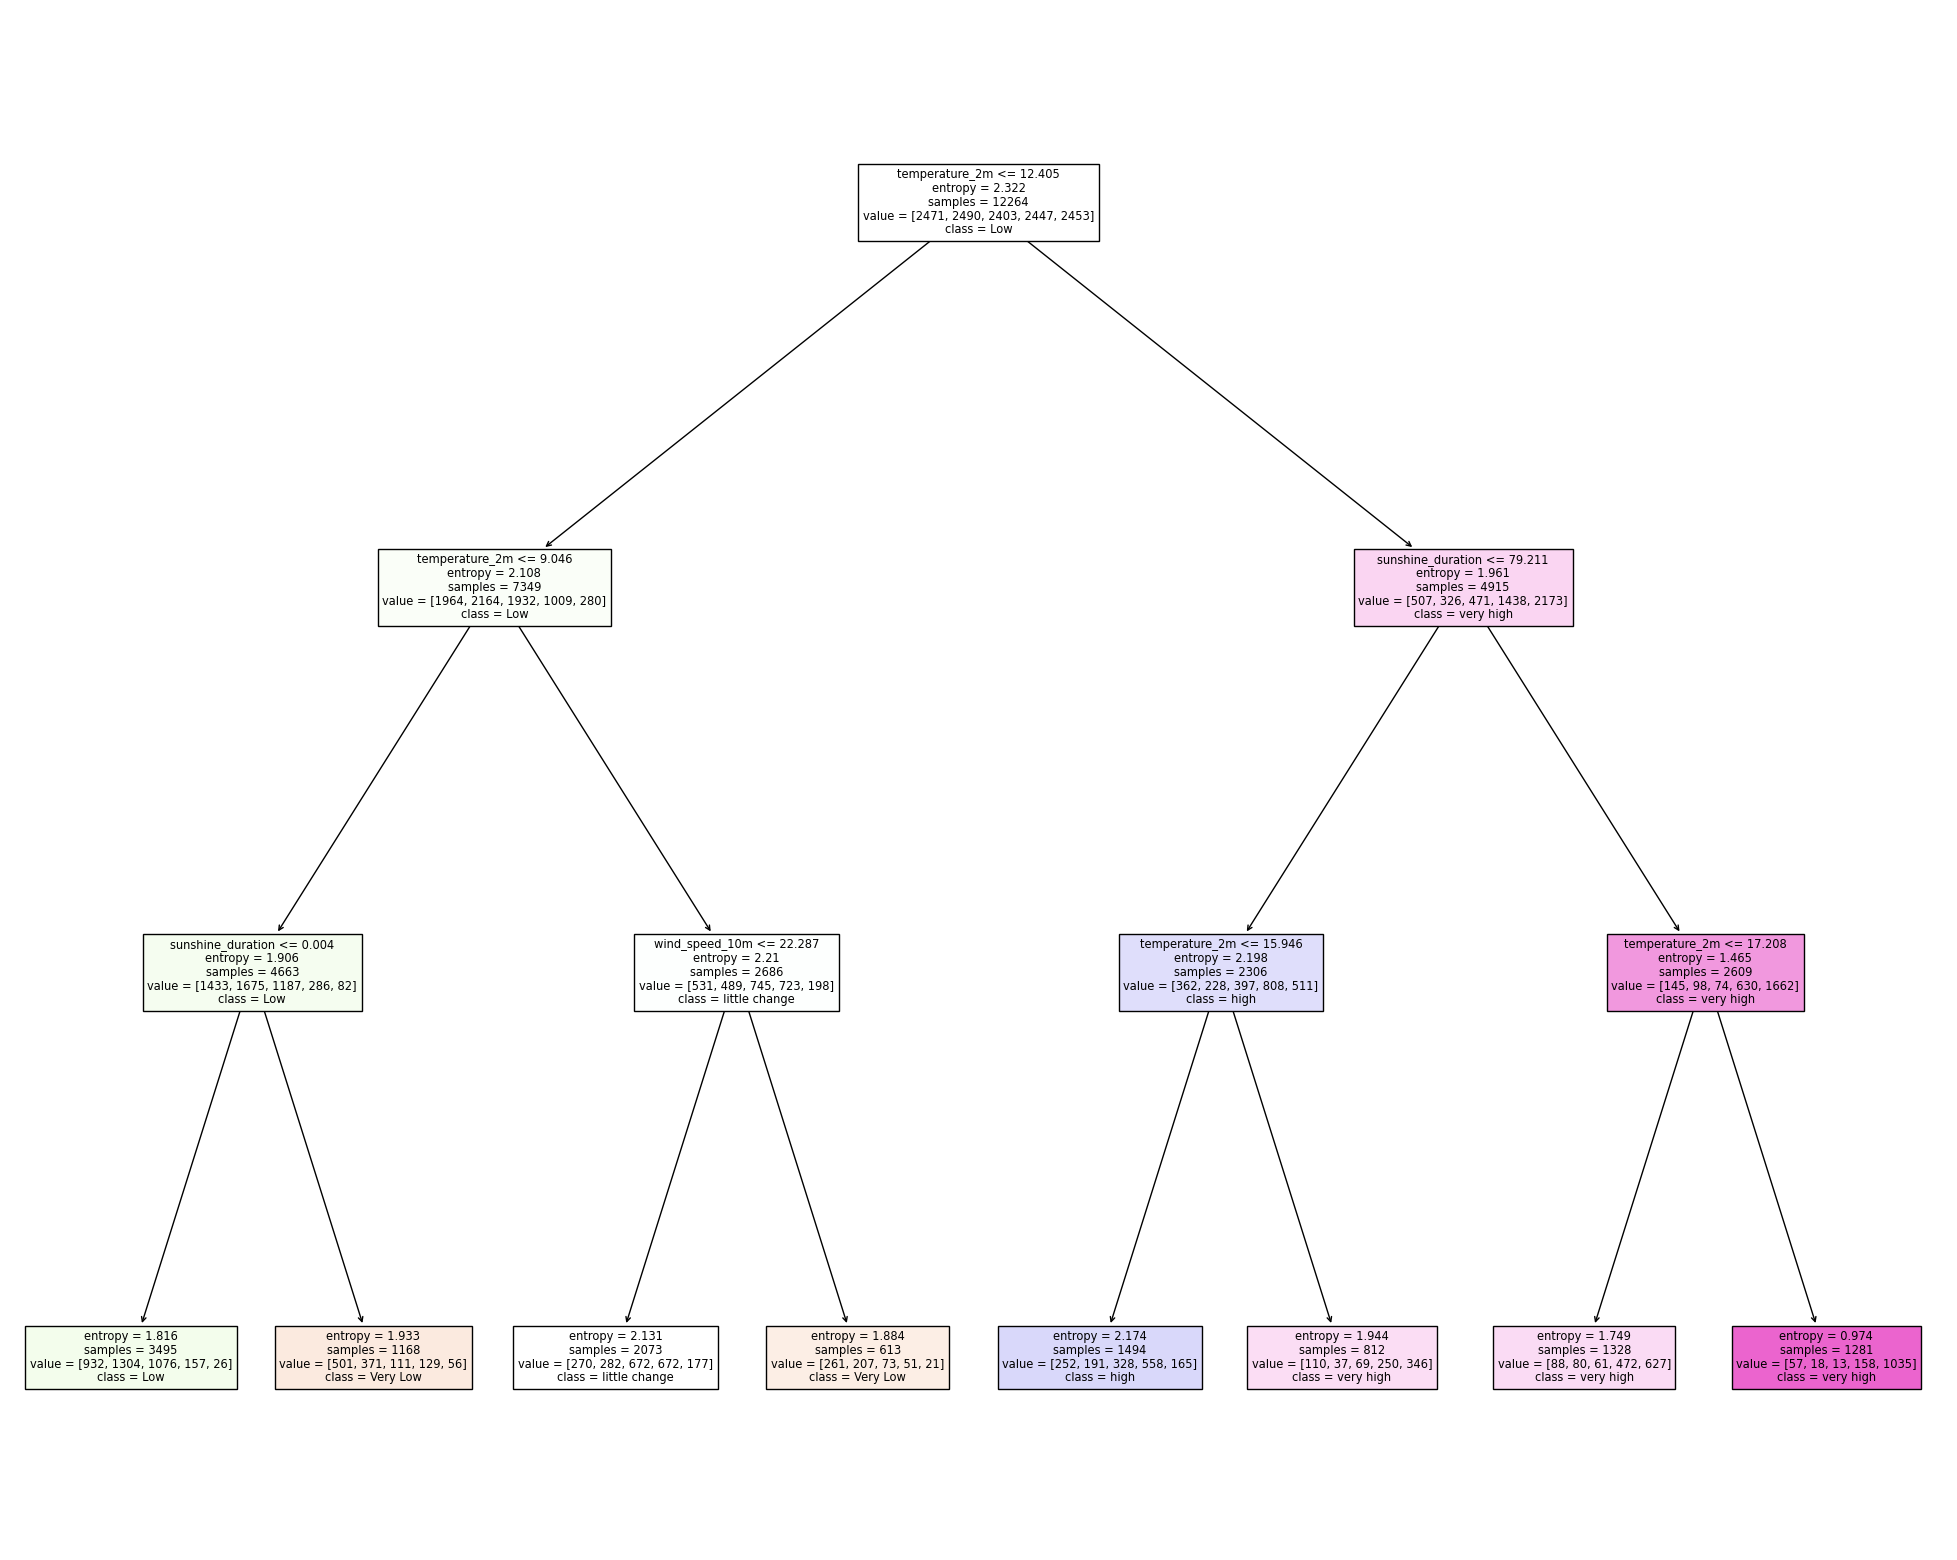

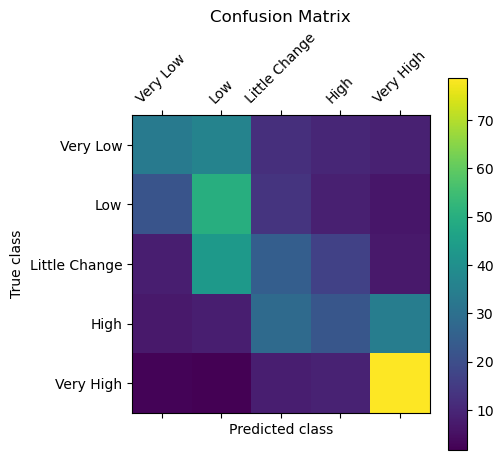

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWar


Metrics for each class:

Class: Very Low
Precision: 0.30
Recall: 0.25
F1-Score: 0.27

Class: Low
Precision: 0.33
Recall: 0.22
F1-Score: 0.27

Class: Little Change
Precision: 0.58
Recall: 0.79
F1-Score: 0.67

Class: High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Class: Very High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
gini Max Depth:  4


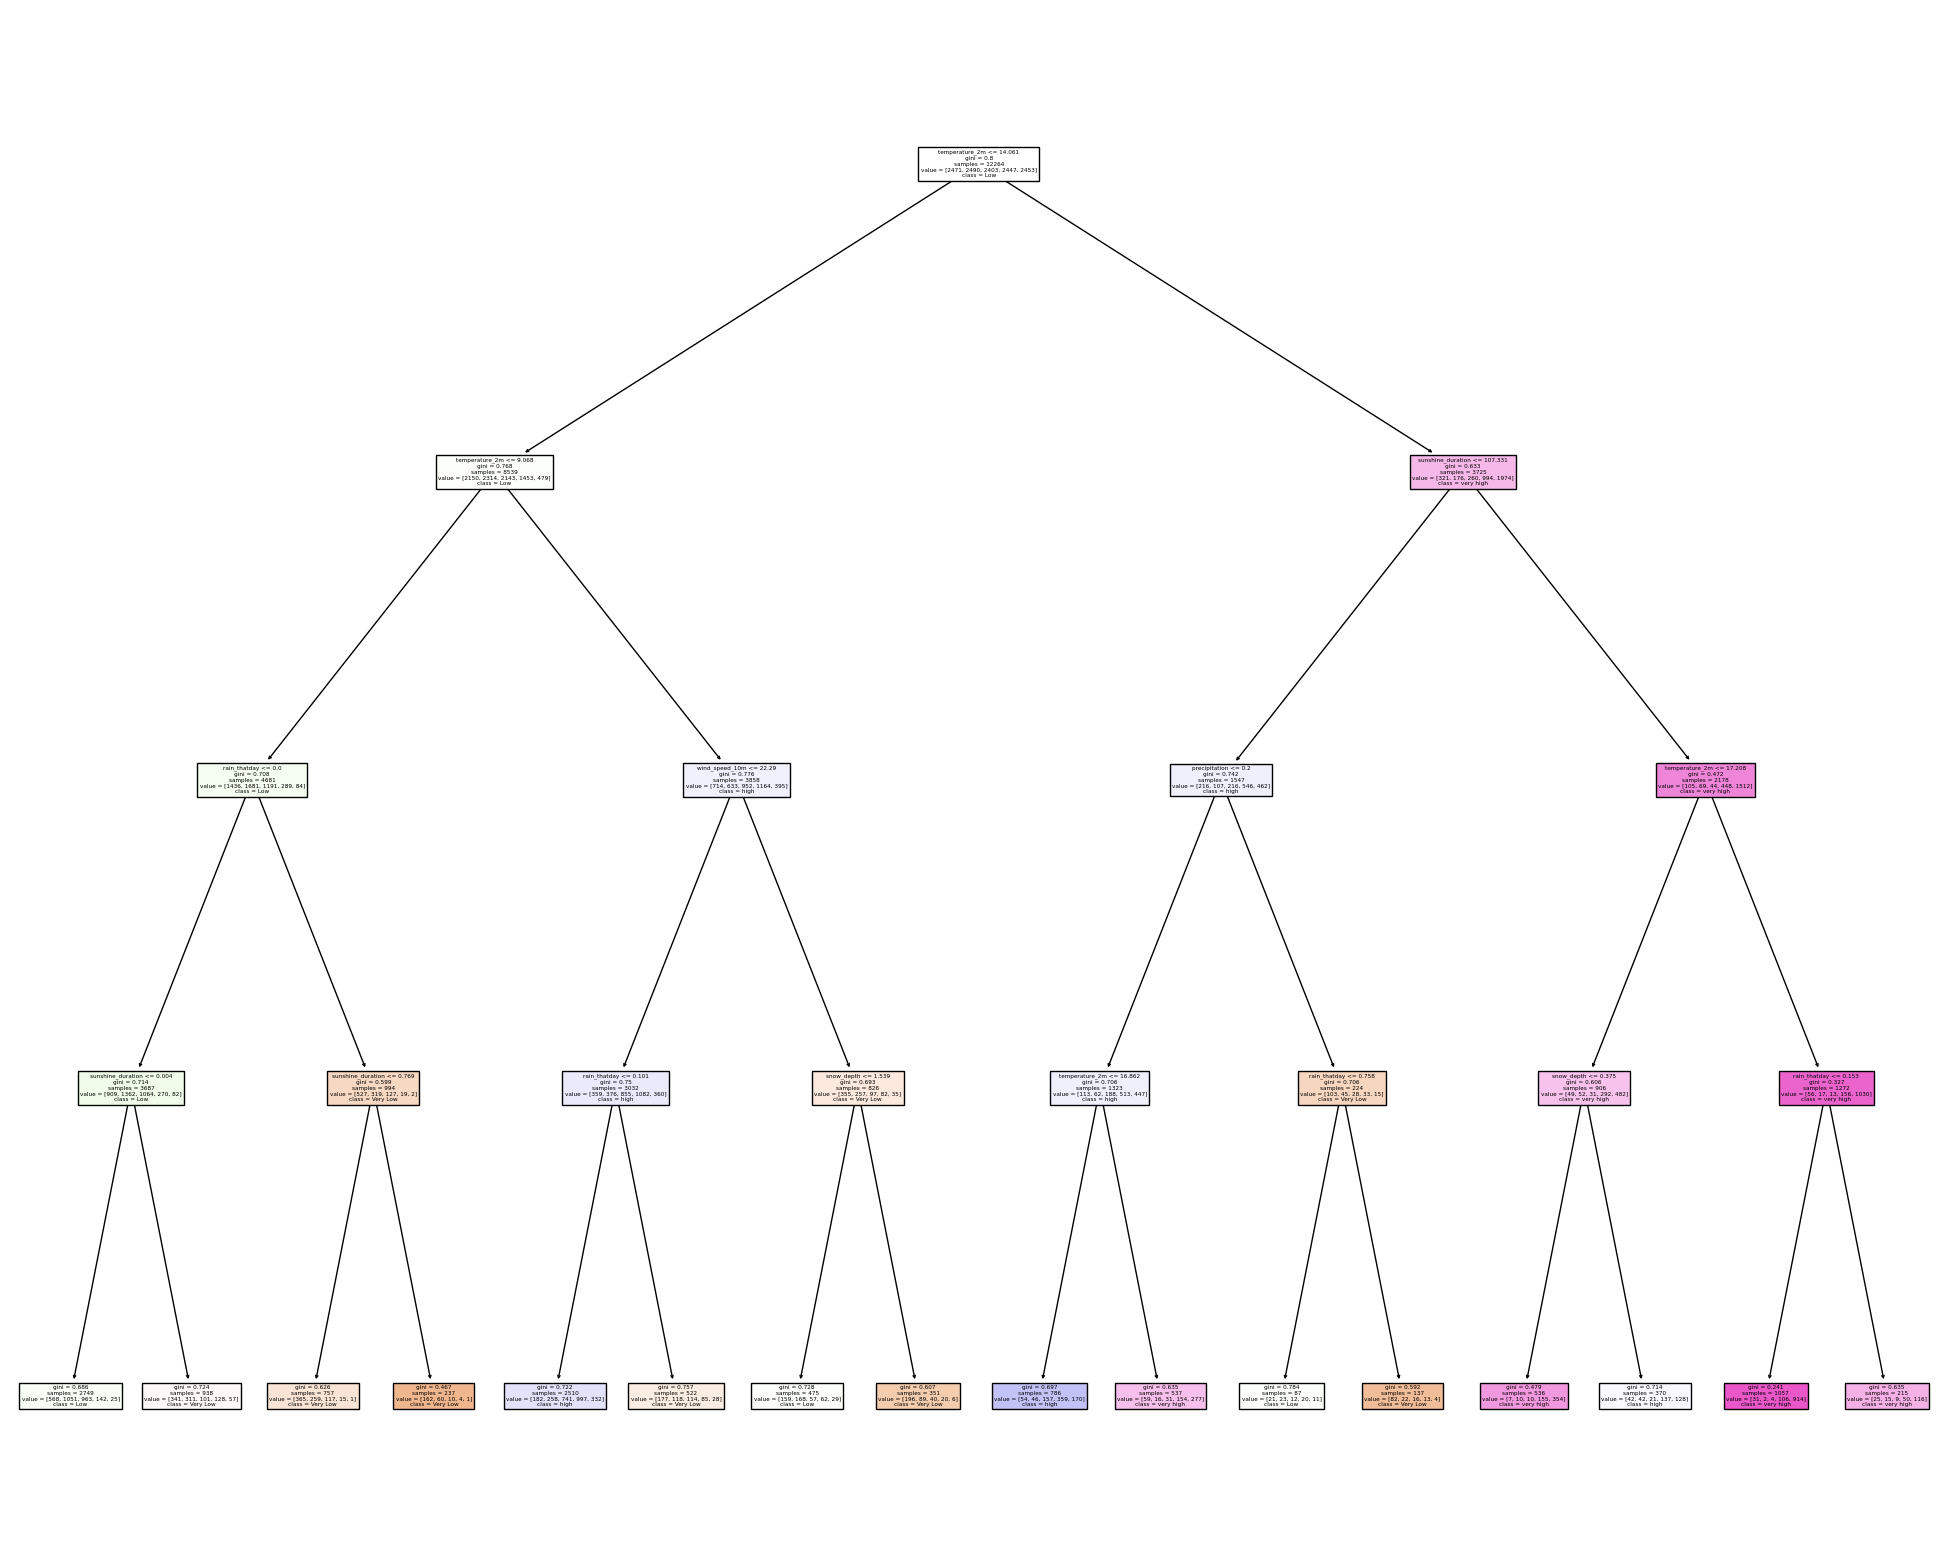

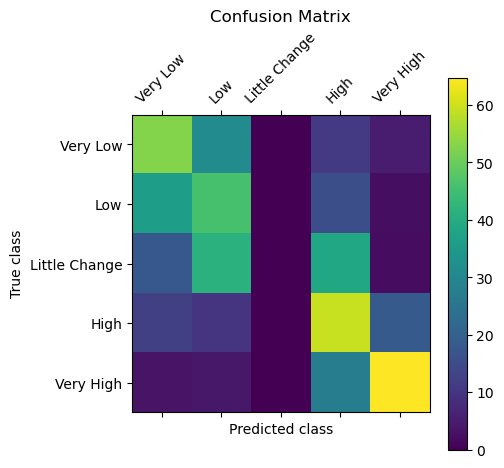

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-def


Metrics for each class:

Class: Very Low
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Class: Low
Precision: 0.39
Recall: 0.59
F1-Score: 0.47

Class: Little Change
Precision: 0.70
Recall: 0.65
F1-Score: 0.67

Class: High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Class: Very High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
log_loss Max Depth:  4


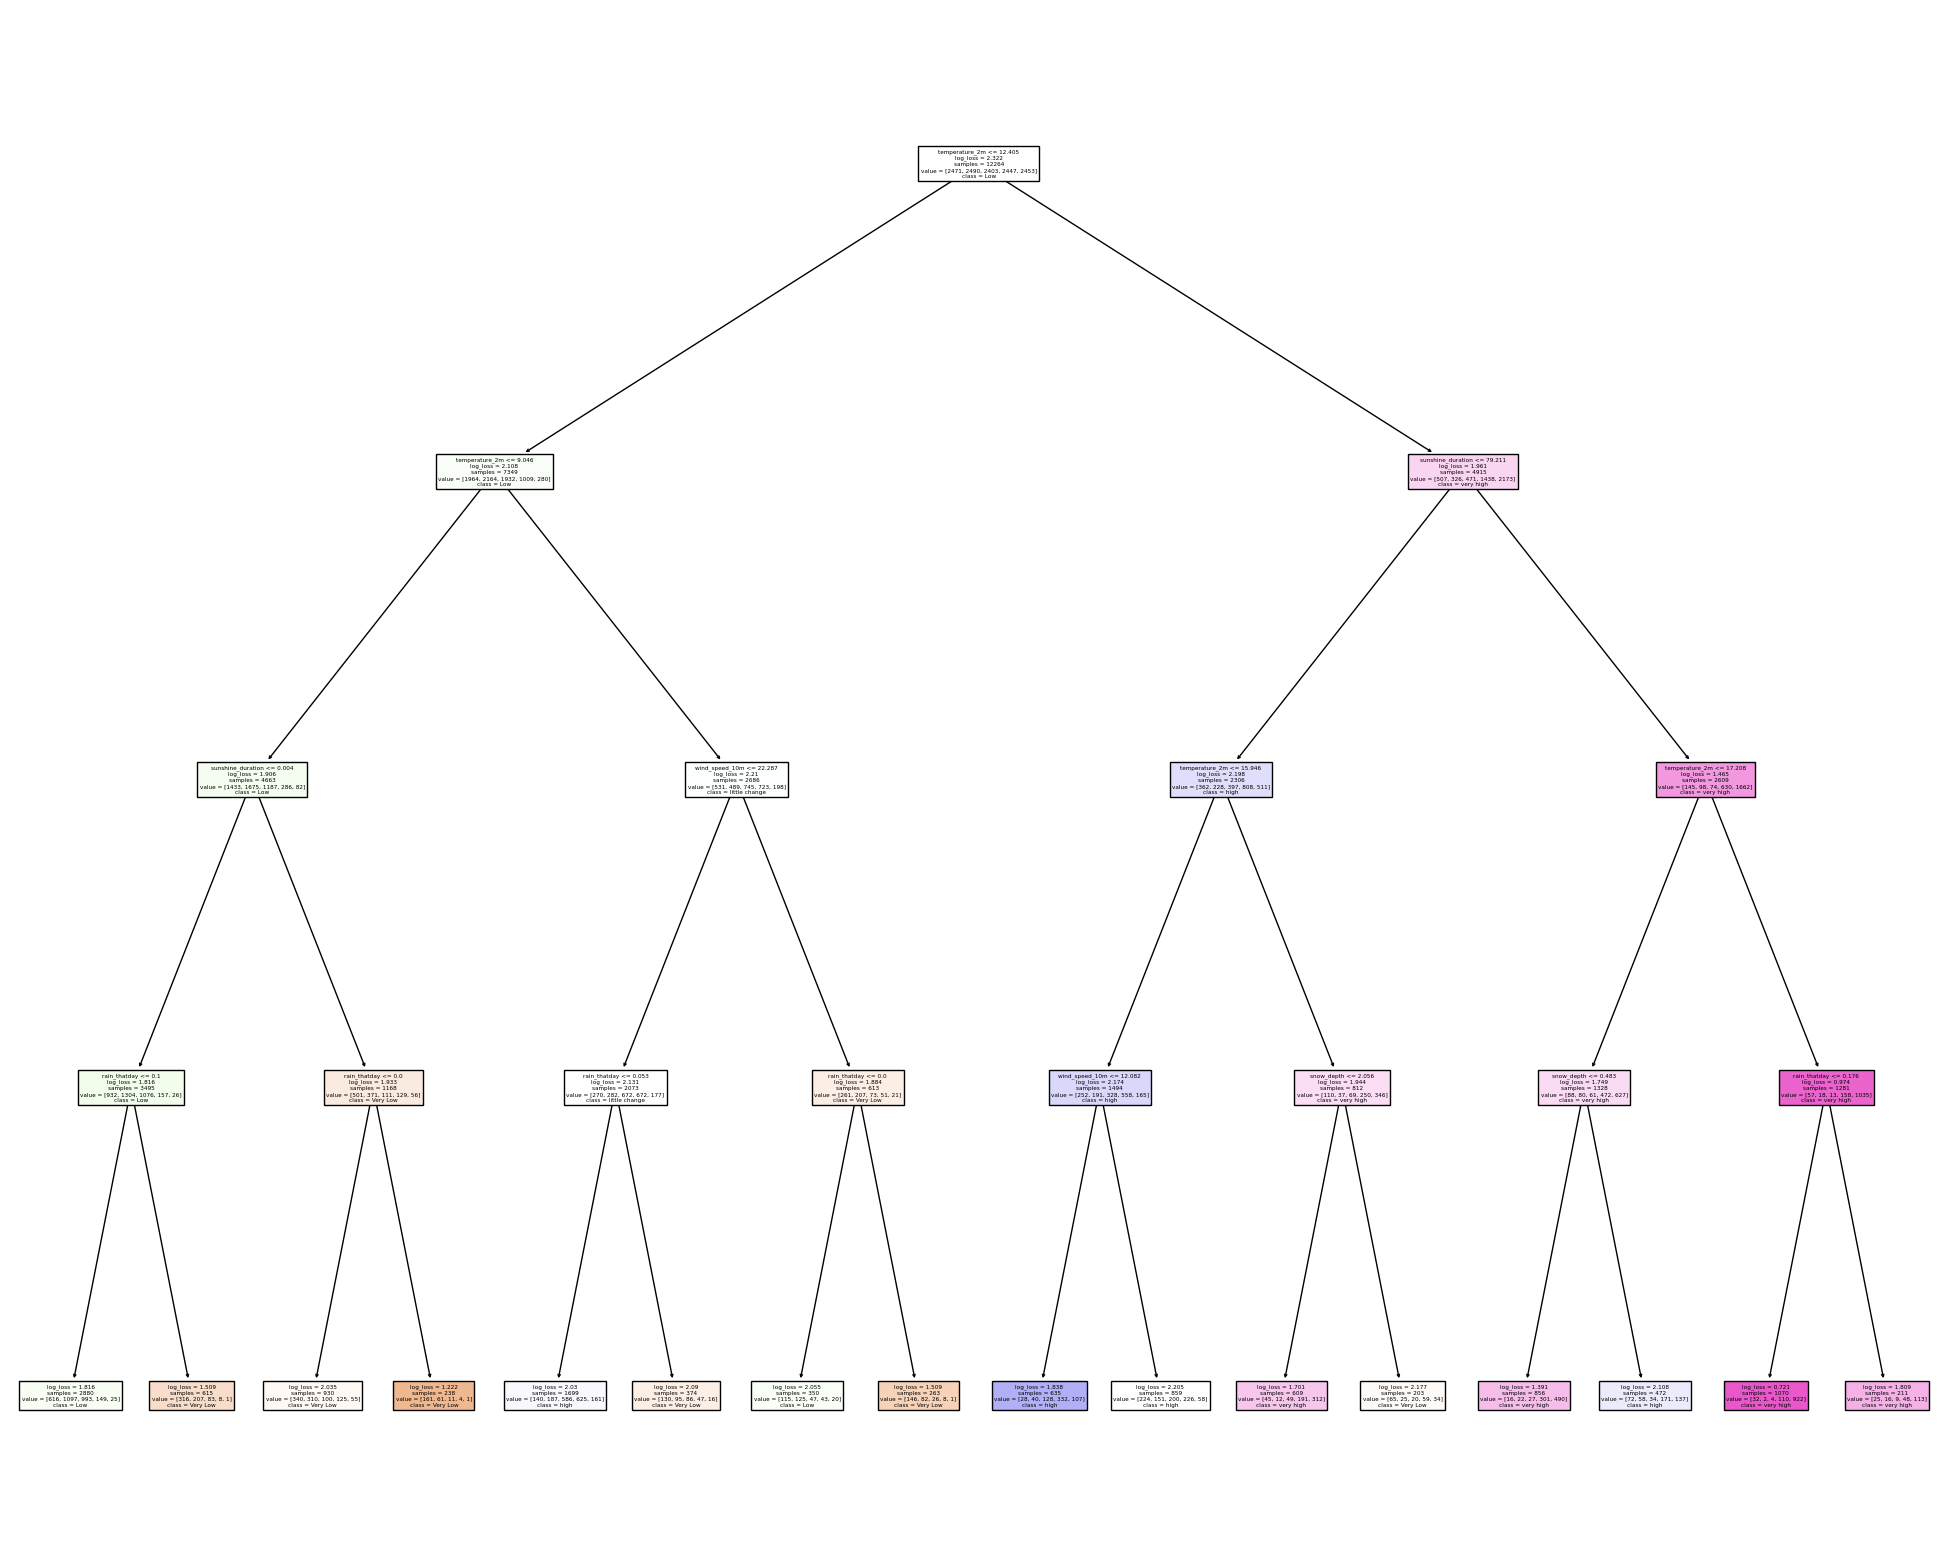

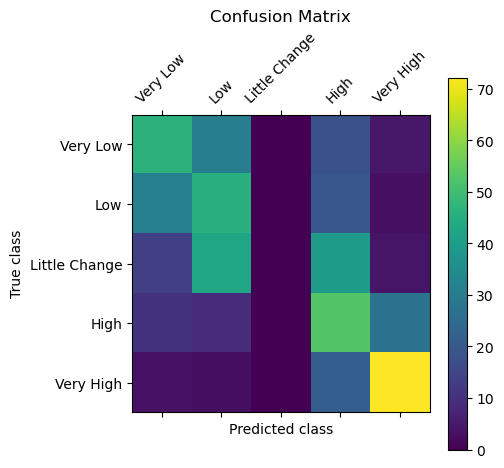

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-def


Metrics for each class:

Class: Very Low
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Class: Low
Precision: 0.34
Recall: 0.53
F1-Score: 0.42

Class: Little Change
Precision: 0.65
Recall: 0.72
F1-Score: 0.68

Class: High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Class: Very High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
entropy Max Depth:  4


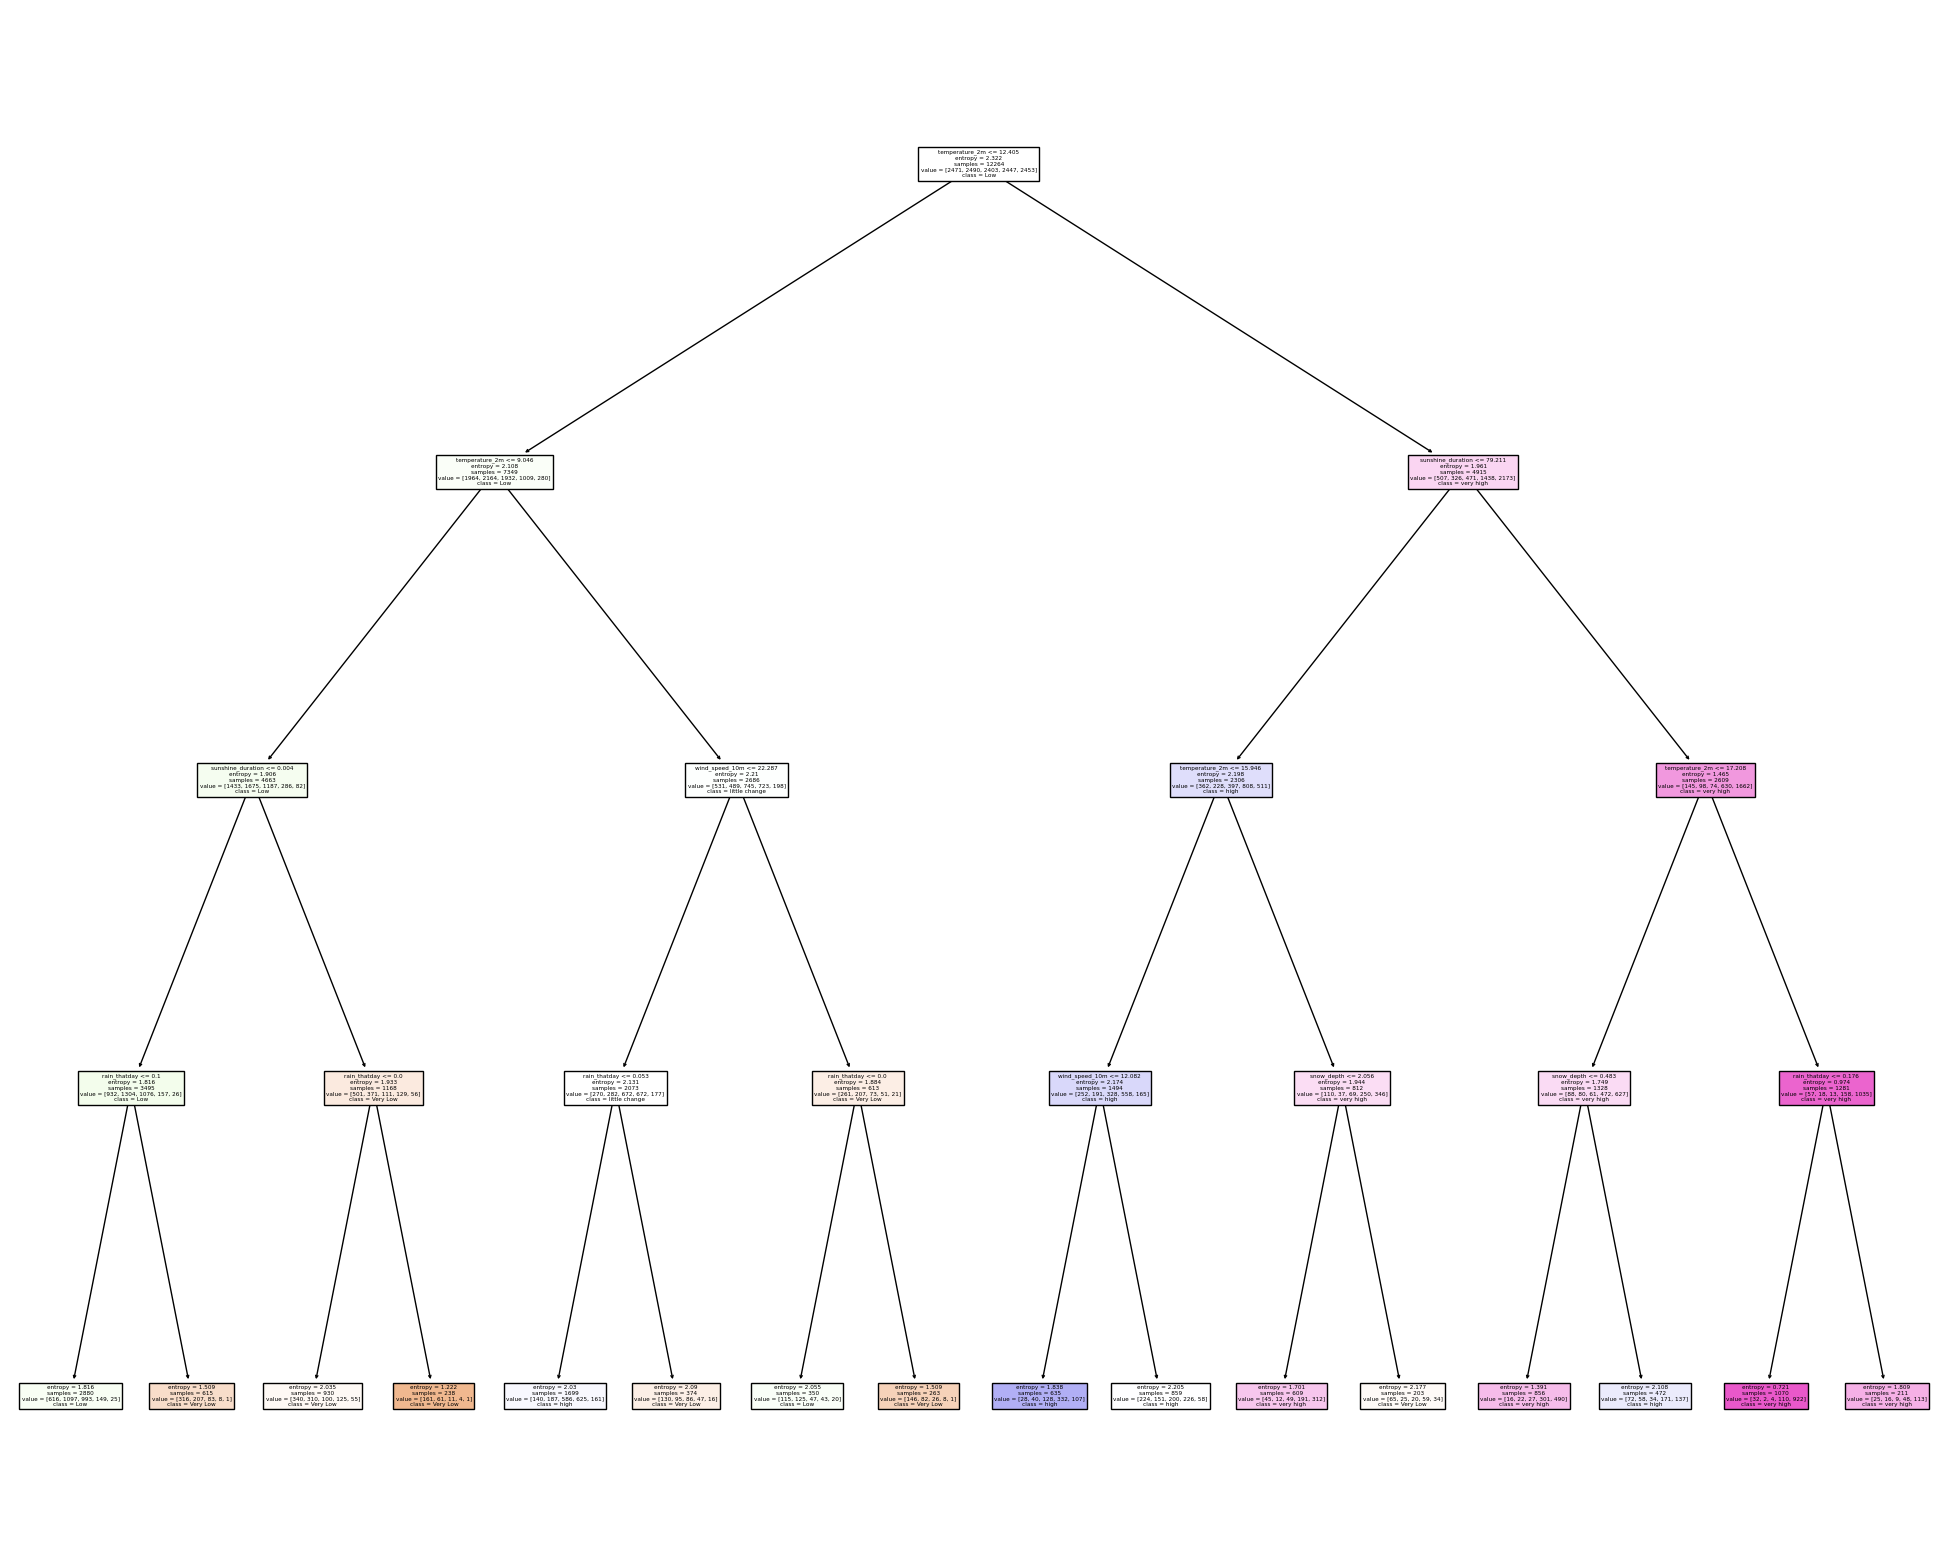

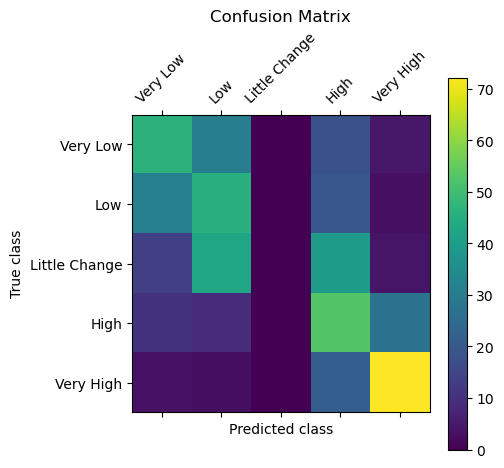

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-def


Metrics for each class:

Class: Very Low
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Class: Low
Precision: 0.34
Recall: 0.53
F1-Score: 0.42

Class: Little Change
Precision: 0.65
Recall: 0.72
F1-Score: 0.68

Class: High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Class: Very High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
gini Max Depth:  5


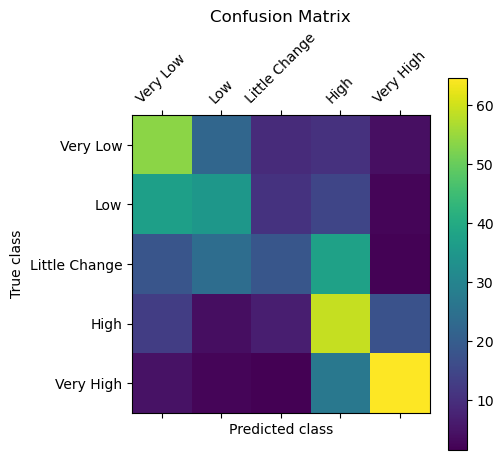

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWar


Metrics for each class:

Class: Very Low
Precision: 0.41
Recall: 0.18
F1-Score: 0.25

Class: Low
Precision: 0.39
Recall: 0.59
F1-Score: 0.47

Class: Little Change
Precision: 0.71
Recall: 0.65
F1-Score: 0.68

Class: High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Class: Very High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
log_loss Max Depth:  5


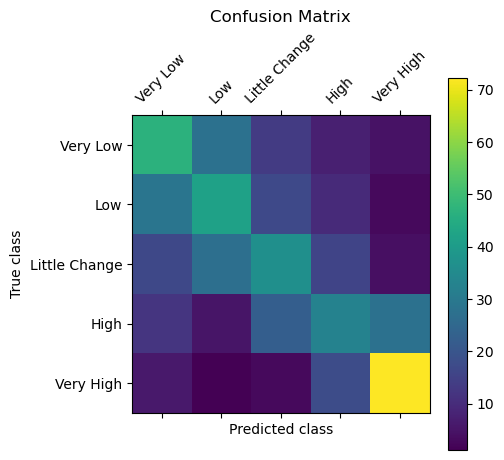

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWar


Metrics for each class:

Class: Very Low
Precision: 0.41
Recall: 0.37
F1-Score: 0.39

Class: Low
Precision: 0.39
Recall: 0.33
F1-Score: 0.36

Class: Little Change
Precision: 0.65
Recall: 0.72
F1-Score: 0.68

Class: High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Class: Very High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
entropy Max Depth:  5


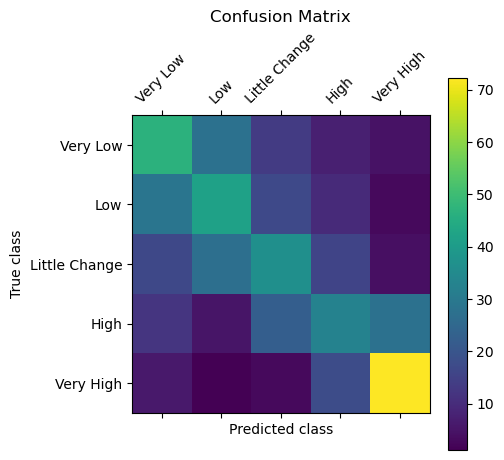

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWar


Metrics for each class:

Class: Very Low
Precision: 0.41
Recall: 0.37
F1-Score: 0.39

Class: Low
Precision: 0.39
Recall: 0.33
F1-Score: 0.36

Class: Little Change
Precision: 0.65
Recall: 0.72
F1-Score: 0.68

Class: High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Class: Very High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
gini Max Depth:  6


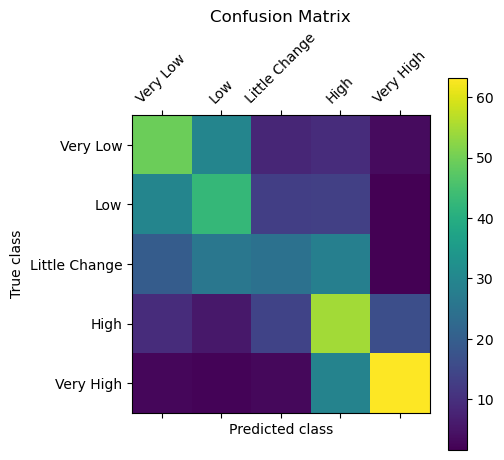

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWar


Metrics for each class:

Class: Very Low
Precision: 0.41
Recall: 0.25
F1-Score: 0.31

Class: Low
Precision: 0.41
Recall: 0.55
F1-Score: 0.47

Class: Little Change
Precision: 0.73
Recall: 0.63
F1-Score: 0.68

Class: High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Class: Very High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
log_loss Max Depth:  6


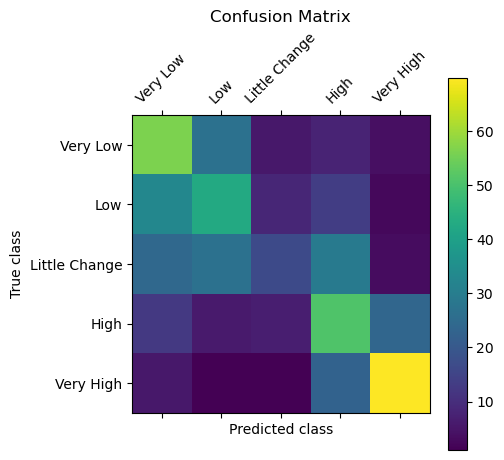

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWar


Metrics for each class:

Class: Very Low
Precision: 0.45
Recall: 0.16
F1-Score: 0.24

Class: Low
Precision: 0.41
Recall: 0.51
F1-Score: 0.45

Class: Little Change
Precision: 0.67
Recall: 0.70
F1-Score: 0.69

Class: High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Class: Very High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
entropy Max Depth:  6


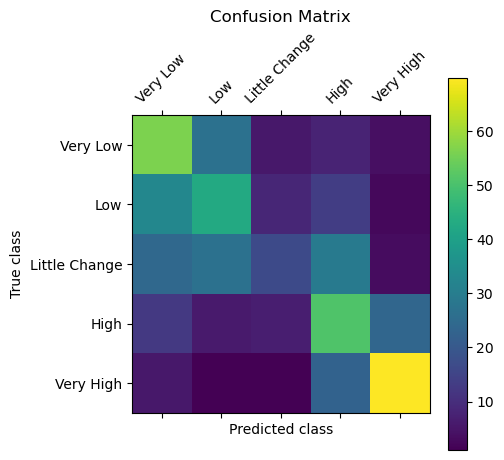

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWar


Metrics for each class:

Class: Very Low
Precision: 0.45
Recall: 0.16
F1-Score: 0.24

Class: Low
Precision: 0.41
Recall: 0.51
F1-Score: 0.45

Class: Little Change
Precision: 0.67
Recall: 0.70
F1-Score: 0.69

Class: High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Class: Very High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
gini Max Depth:  7


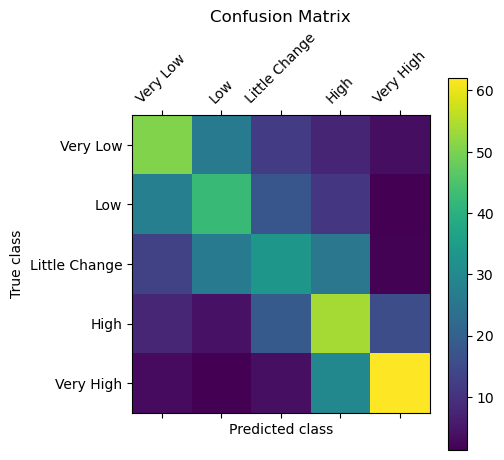

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWar


Metrics for each class:

Class: Very Low
Precision: 0.41
Recall: 0.33
F1-Score: 0.37

Class: Low
Precision: 0.42
Recall: 0.54
F1-Score: 0.47

Class: Little Change
Precision: 0.73
Recall: 0.62
F1-Score: 0.67

Class: High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Class: Very High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
log_loss Max Depth:  7


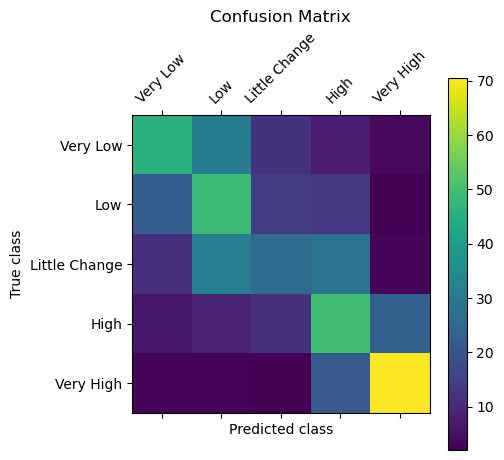

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWar


Metrics for each class:

Class: Very Low
Precision: 0.41
Recall: 0.26
F1-Score: 0.32

Class: Low
Precision: 0.41
Recall: 0.49
F1-Score: 0.45

Class: Little Change
Precision: 0.68
Recall: 0.71
F1-Score: 0.69

Class: High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Class: Very High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
entropy Max Depth:  7


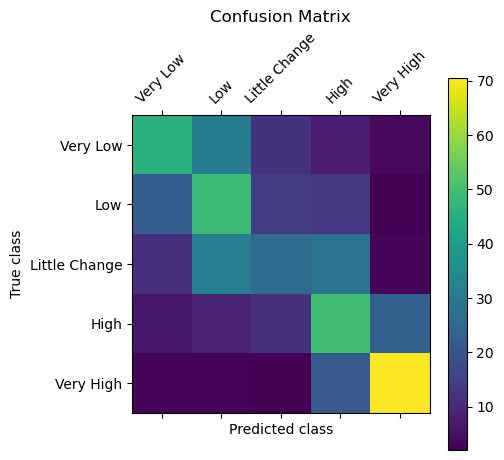


Metrics for each class:

Class: Very Low
Precision: 0.41
Recall: 0.26
F1-Score: 0.32

Class: Low
Precision: 0.41
Recall: 0.49
F1-Score: 0.45

Class: Little Change
Precision: 0.68
Recall: 0.71
F1-Score: 0.69

Class: High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Class: Very High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00


C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWar

Machine_Learning_Algorithm    Recall  Precision  F1_Score  Run_time
0         entropyMax Depth: 7  0.478691   0.480384  0.473778  0.153989
1        log_lossMax Depth: 7  0.478691   0.480384  0.473778  0.147573
2            giniMax Depth: 7  0.483067   0.491843  0.484303  0.099647
3         entropyMax Depth: 6  0.468607   0.471088  0.452856  0.132108
4        log_lossMax Depth: 6  0.468607   0.471088  0.452856  0.117729
5            giniMax Depth: 6  0.466514   0.474998  0.463269  0.078196
6         entropyMax Depth: 5  0.459285   0.453196  0.454605  0.112998
7        log_lossMax Depth: 5  0.459285   0.453196  0.454605  0.112102
8            giniMax Depth: 5  0.459094   0.465551  0.447495  0.062487
9         entropyMax Depth: 4  0.429414   0.349119  0.383231  0.083375
10       log_lossMax Depth: 4  0.429414   0.349119  0.383231  0.106592
11           giniMax Depth: 4  0.440449   0.365720  0.395590  0.066483
12        entropyMax Depth: 3  0.415906   0.402436  0.398865  0.071295
13       log_lossMax Depth: 3  0.415906   0.402436  0.398865  0.059436
14           giniMax Depth: 3  0.432458   0.372928  0.389253  0.036187
15        entropyMax Depth: 2  0.379376   0.313464  0.336944  0.039713
16       log_lossMax Depth: 2  0.379376   0.313464  0.336944  0.048943
17           giniMax Depth: 2  0.383942   0.266795  0.299621  0.032647

In [39]:
Decision_Tree(x_train,y_train,x_test,y_test,Table ,True,feature_names1)

In [1]:

def Perceptron(x_train, y_train, x_test, y_test,Table, Print_Graphs):
    average_option = 'weighted' 
    
    ## Calculate run time 
    start = time.time();
    
    #Run Alogorithm
    Perceptron = MLPClassifier()
    Perceptron.fit(x_train,y_train)
    predictions = Perceptron.predict(x_test)
    y_pred = pd.DataFrame(list(predictions))
    timeTaken = time.time() - start
    
    if Print_Graphs == True:
            
        #Confusion Matrix 
        confusion_matrix_print(y_test, y_pred)
            
    # Table of Results
    new_row= pd.DataFrame({'Machine_Learning_Algorithm': "MPL Classifier", 'Recall':recall_score(y_test,y_pred, average= average_option), 'Precision':precision_score(y_test,y_pred,average= average_option), 'F1_Score':f1_score(y_test,y_pred,average= average_option) ,"Run_time":timeTaken }, index=[0])
    Table = pd.concat([new_row,Table.loc[:]]).reset_index(drop=True)
    return  Table

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


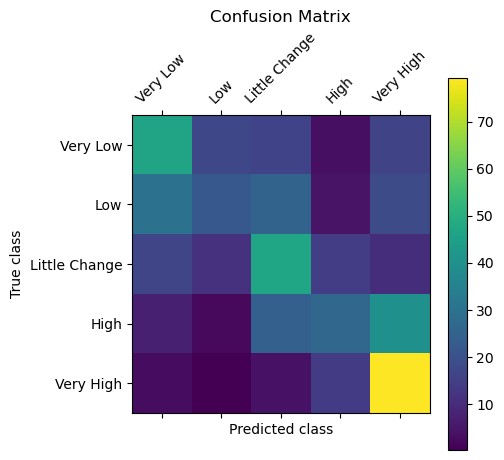

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWar


Metrics for each class:

Class: Very Low
Precision: 0.42
Recall: 0.47
F1-Score: 0.44

Class: Low
Precision: 0.42
Recall: 0.26
F1-Score: 0.32

Class: Little Change
Precision: 0.48
Recall: 0.79
F1-Score: 0.60

Class: High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Class: Very High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00


C:\Users\23510\AppData\Local\Temp\ipykernel_11968\2317210402.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Table = pd.concat([new_row,Table.loc[:]]).reset_index(drop=True)


Machine_Learning_Algorithm    Recall  Precision  F1_Score  Run_time
0             MPL Classifier  0.443493   0.433937  0.422069  2.180712

In [270]:
Perceptron(x_train, y_train, x_test, y_test,Table, True)

In [273]:
def Logistic_Regression(x_train, y_train, x_test, y_test,Table, Print_Graphs):
    
    average_option = 'weighted'
    start= time.time() 
    
    #Run the Alogrithm 
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    LogRegres = LogisticRegression(random_state = 35)
    LogRegres.fit(x_train, y_train) 
    y_pred = LogRegres.predict(x_test) 
    reviews_pred = pd.DataFrame(list(y_pred))
    
   
    
    timeTaken = time.time() - start ## Calcultate the total run time of the function  
    
    ## Create the table of results    
    new_row= pd.DataFrame({'Machine_Learning_Algorithm': "Logistic Regression", 'Recall':recall_score(y_test,y_pred, average= average_option), 'Precision':precision_score(y_test,y_pred,average= average_option), 'F1_Score':f1_score(y_test,y_pred,average= average_option) ,"Run_time":timeTaken }, index=[0])
    Table = pd.concat([new_row,Table.loc[:]]).reset_index(drop=True) 
    
    if Print_Graphs ==True:
      
        ## Print the confusion matrix   
        confusion_matrix_print(y_test, y_pred)
    
    ## Return the updated table
    return Table

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\23510\AppData\Local\Temp\ipykernel_11968\330029514.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Table = pd.concat([new_row,Table.loc[:]]).reset_index(drop=True)


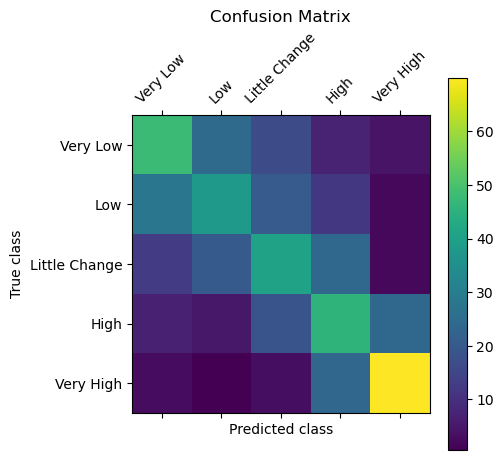


Metrics for each class:

Class: Very Low
Precision: 0.43
Recall: 0.41
F1-Score: 0.42

Class: Low
Precision: 0.41
Recall: 0.46
F1-Score: 0.43

Class: Little Change
Precision: 0.69
Recall: 0.70
F1-Score: 0.69

Class: High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Class: Very High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00


C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWar

Machine_Learning_Algorithm    Recall  Precision  F1_Score  Run_time
0        Logistic Regression  0.484018   0.483438  0.483153   0.27033

In [274]:
Logistic_Regression(x_train, y_train, x_test, y_test,Table, True)

In [42]:
#Implement the function
def Naive_Bayes(x_train,y_train,x_test,y_test,Table, Print_Graphs):
    
    average_option = 'weighted'
    
    start= time.time()
    
    #Run the alogrithm 
    Naive_B = GaussianNB()
    Naive_B.fit(x_train,y_train)
    score = Naive_B.score(x_test, y_test)
    Naive_Bayes_score_rounded = round(score, 3)
    predictions = Naive_B.predict(x_test)
    y_pred = pd.DataFrame(list(predictions))
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    
    timeTaken = time.time() - start
    
    new_row= pd.DataFrame({'Machine_Learning_Algorithm': "Naive Bayes", 'Recall':recall_score(y_test,y_pred, average= average_option), 'Precision':precision_score(y_test,y_pred,average= average_option), 'F1_Score':f1_score(y_test,y_pred,average= average_option) ,"Run_time":timeTaken }, index=[0])
    Table = pd.concat([new_row,Table.loc[:]]).reset_index(drop=True) 
    
    if Print_Graphs == True:
        
        confusion_matrix_print(y_test, y_pred)
    
   
    return Table


C:\Users\23510\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\23510\AppData\Local\Temp\ipykernel_14060\975067797.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Table = pd.concat([new_row,Table.loc[:]]).reset_index(drop=True)


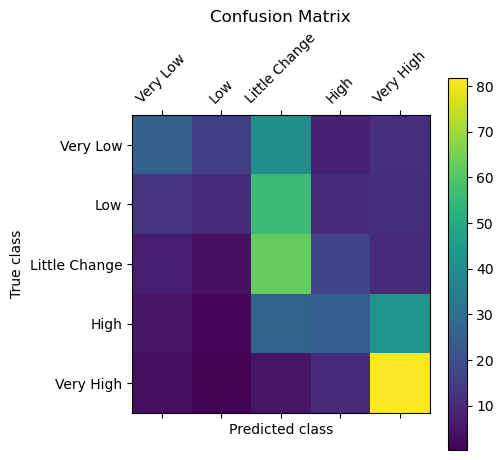


Metrics for each class:

Class: Very Low
Precision: 0.35
Recall: 0.63
F1-Score: 0.44

Class: Low
Precision: 0.36
Recall: 0.25
F1-Score: 0.29

Class: Little Change
Precision: 0.52
Recall: 0.82
F1-Score: 0.64

Class: High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Class: Very High
Precision: 0.00
Recall: 0.00
F1-Score: 0.00


C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWar

Machine_Learning_Algorithm    Recall  Precision  F1_Score  Run_time
0                Naive Bayes  0.414193    0.40429  0.374385  0.043846

In [43]:
Naive_Bayes(x_train,y_train,x_test,y_test,Table, True)

# Station 154 


In [211]:
station154=merged_df[merged_df["station_id"]==154]

In [212]:
station154

date  temperature_2m  precipitation  \
2547360  2015-01-04 00:00:00          3.4585            0.0   
2547361  2015-01-04 01:00:00          2.8585            0.0   
2547362  2015-01-04 02:00:00          2.2085            0.0   
2547363  2015-01-04 03:00:00          1.5585            0.0   
2547364  2015-01-04 04:00:00          0.9585            0.0   
...                      ...             ...            ...   
2564923  2017-01-04 19:00:00          1.0650            0.0   
2564924  2017-01-04 20:00:00          0.5150            0.0   
2564925  2017-01-04 21:00:00          0.0150            0.0   
2564926  2017-01-04 22:00:00         -0.2850            0.0   
2564927  2017-01-04 23:00:00         -0.3850            0.0   

         relative_humidity_2m  apparent_temperature  cloud_cover  \
2547360             94.164130              0.615098    83.700000   
2547361             95.828545              0.058176    73.799995   
2547362             96.840260             -0.523609    62.100000   
2547363             97.172160             -1.315967    52.199997   
2547364             97.509650             -1.919244    45.899998   
...                       ...                   ...          ...   
2564923             79.500565             -2.864098     0.000000   
2564924             81.501660             -3.351199     0.000000   
2564925             82.649254             -3.842169     0.000000   
2564926             83.535000             -4.205402     0.000000   
2564927             83.833100             -4.359010     0.000000   

         sunshine_duration  wind_speed_10m  weather_code  snow_depth  \
2547360                0.0        7.928177           3.0         0.0   
2547361                0.0        7.200000           2.0         0.0   
2547362                0.0        6.130579           2.0         0.0   
2547363                0.0        6.409617           2.0         0.0   
2547364                0.0        5.815978           1.0         0.0   
...                    ...             ...           ...         ...   
2564923                0.0       10.308831           0.0         0.0   
2564924                0.0        9.693295           0.0         0.0   
2564925                0.0        9.360001           0.0         0.0   
2564926                0.0        9.659814           0.0         0.0   
2564927                0.0        9.983106           0.0         0.0   

         latitude  longitude  station_id       date_and_hour  Duration  \
2547360    51.504  -0.113864         154 2015-01-04 00:00:00    2040.0   
2547361    51.504  -0.113864         154 2015-01-04 01:00:00       0.0   
2547362    51.504  -0.113864         154 2015-01-04 02:00:00       0.0   
2547363    51.504  -0.113864         154 2015-01-04 03:00:00       0.0   
2547364    51.504  -0.113864         154 2015-01-04 04:00:00       0.0   
...           ...        ...         ...                 ...       ...   
2564923    51.504  -0.113864         154 2017-01-04 19:00:00       0.0   
2564924    51.504  -0.113864         154 2017-01-04 20:00:00       0.0   
2564925    51.504  -0.113864         154 2017-01-04 21:00:00       0.0   
2564926    51.504  -0.113864         154 2017-01-04 22:00:00       0.0   
2564927    51.504  -0.113864         154 2017-01-04 23:00:00       0.0   

         total_entries  
2547360            4.0  
2547361            0.0  
2547362            0.0  
2547363            0.0  
2547364            0.0  
...                ...  
2564923            0.0  
2564924            0.0  
2564925            0.0  
2564926            0.0  
2564927            0.0  

[17568 rows x 16 columns]

In [213]:
## intiate table
Table1=pd.DataFrame(columns=['Machine_Learning_Algorithm',"Recall","Precision","F1_Score","Run_time"]) 

In [214]:
station154transform, x_train154, x_test154, y_train154, y_test154,x154,y154=Data_Frame_Transformation(station154,True)

C:\Users\23510\AppData\Local\Temp\ipykernel_11968\232587888.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Sunday' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  new_df2.at[index, "Weekday"] = days[k]
C:\Users\23510\AppData\Local\Temp\ipykernel_11968\232587888.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Sunday 0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  new_df2.at[i, "d/c time"] = row["Weekday"] +  " " +str(row["date_and_hour"].hour)
C:\Users\23510\AppData\Local\Temp\ipykernel_11968\396795107.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataframe3

C:\Users\23510\AppData\Local\Temp\ipykernel_11968\396795107.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataframe3["rain_thatday"].iloc[i] += Dataframe3["precipitation"].iloc[i+j]
C:\Users\23510\AppData\Local\Temp\ipykernel_11968\396795107.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataframe3["rain_thatday"].iloc[i] += Dataframe3["precipitation"].iloc[i+j]
C:\Users\23510\AppData\Local\Temp\ipykernel_11968\396795107.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\23510\AppData\Local\Temp\ipykernel_11968\396795107.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataframe3["rain_thatday"].iloc[i] += Dataframe3["precipitation"].iloc[i+j]
C:\Users\23510\AppData\Local\Temp\ipykernel_11968\396795107.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataframe3["rain_thatday"].iloc[i] += Dataframe3["precipitation"].iloc[i+j]
C:\Users\23510\AppData\Local\Temp\ipykernel_11968\396795107.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\23510\AppData\Local\Temp\ipykernel_11968\396795107.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataframe3["rain_thatday"].iloc[i] += Dataframe3["precipitation"].iloc[i+j]
C:\Users\23510\AppData\Local\Temp\ipykernel_11968\396795107.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataframe3["rain_thatday"].iloc[i] += Dataframe3["precipitation"].iloc[i+j]
C:\Users\23510\AppData\Local\Temp\ipykernel_11968\396795107.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\23510\AppData\Local\Temp\ipykernel_11968\396795107.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataframe3["rain_last4hours"].loc[i] = Dataframe3["precipitation"].iloc[i-1]+Dataframe3["precipitation"].iloc[i-2]+Dataframe3["precipitation"].iloc[i-3]+Dataframe3["precipitation"].iloc[i-4]
C:\Users\23510\AppData\Local\Temp\ipykernel_11968\396795107.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataframe3["rain_last4hours"].loc[i] = Dataframe3["precipitation"].iloc[i-1]+Dataframe3["precipitation"].iloc[i-2]+Dataframe3["precipitation"].iloc[i-3]+Dataframe3["precipitation"].iloc[i-4]
C:\Users\23510\AppDa

In [26]:
feature_names1= ["temperature_2m", "precipitation", "cloud_cover", "sunshine_duration", "wind_speed_10m","snow_depth", "rain_thatday","rain_last4hours"]

In [216]:
station154transform

index                 date  temperature_2m  precipitation  \
12     2547372  2015-01-04 12:00:00          2.9085            0.0   
13     2547373  2015-01-04 13:00:00          3.2085            0.0   
14     2547374  2015-01-04 14:00:00          3.3585            0.0   
15     2547375  2015-01-04 15:00:00          3.2585            0.0   
16     2547376  2015-01-04 16:00:00          2.8085            0.0   
...        ...                  ...             ...            ...   
17551  2564911  2017-01-04 07:00:00          5.6150            0.0   
17552  2564912  2017-01-04 08:00:00          5.7150            0.0   
17553  2564913  2017-01-04 09:00:00          6.0650            0.0   
17554  2564914  2017-01-04 10:00:00          6.4150            0.0   
17555  2564915  2017-01-04 11:00:00          7.4650            0.0   

       relative_humidity_2m  apparent_temperature  cloud_cover  \
12                81.236084             -0.577918    47.399998   
13                80.399796             -0.170095    62.100000   
14                81.004880              0.123697    80.100000   
15                83.364600             -0.036150    88.200000   
16                88.257256             -0.189569    84.600000   
...                     ...                   ...          ...   
17551             84.544320              1.384363    90.299995   
17552             85.455185              1.764201    90.600000   
17553             85.193070              2.418545    90.000000   
17554             85.530840              3.231537    92.400000   
17555             84.754460              4.285246    79.500000   

       sunshine_duration  wind_speed_10m  weather_code  ...  total_entries_x  \
12            3600.00000        9.346143           1.0  ...              0.0   
13            3600.00000        8.766573           2.0  ...              2.0   
14            3600.00000        8.049845           3.0  ...              1.0   
15            3600.00000        8.788720           3.0  ...              1.0   
16             530.36835        7.145796           3.0  ...              2.0   
...                  ...             ...           ...  ...              ...   
17551            0.00000       18.214718           3.0  ...              0.0   
17552            0.00000       16.622490           3.0  ...              0.0   
17553            0.00000       14.934577           3.0  ...              0.0   
17554            0.00000       12.303366           3.0  ...              0.0   
17555            0.00000       13.551501           2.0  ...              0.0   

         Weekday      d/c time    Duration_y total_entries_y  \
12        Sunday     Sunday 12   5025.714286        2.752381   
13        Sunday     Sunday 13   3954.285714        2.219048   
14        Sunday     Sunday 14   3778.285714        1.780952   
15        Sunday     Sunday 15   2781.142857        1.942857   
16        Sunday     Sunday 16   2596.000000        2.095238   
...          ...           ...           ...             ...   
17551  Wednesday   Wednesday 7  85811.428571      110.419048   
17552  Wednesday   Wednesday 8  90250.285714      109.895238   
17553  Wednesday   Wednesday 9   7697.142857        9.180952   
17554  Wednesday  Wednesday 10   1878.857143        2.180952   
17555  Wednesday  Wednesday 11   1480.571429        1.752381   

       Normalised Total  Normalised Duration rain_last4hours rain_thatday  \
12            -2.752381         -5025.714286             0.0          0.0   
13            -0.219048         -2214.285714             0.0          0.0   
14            -0.780952         -3418.285714             0.0          0.0   
15            -0.942857         -2241.142857             0.0          0.0   
16            -0.095238         -1756.000000             0.0          0.0   
...                 ...                  ...             ...          ...   
17551       -110.419048        -85811.428571             0.0          0.0   
17552       -109.895238      

In [224]:
Table154=pd.DataFrame(columns=['Machine_Learning_Algorithm',"Recall","Precision","F1_Score","Run_time"]) 

gini Max Depth:  2


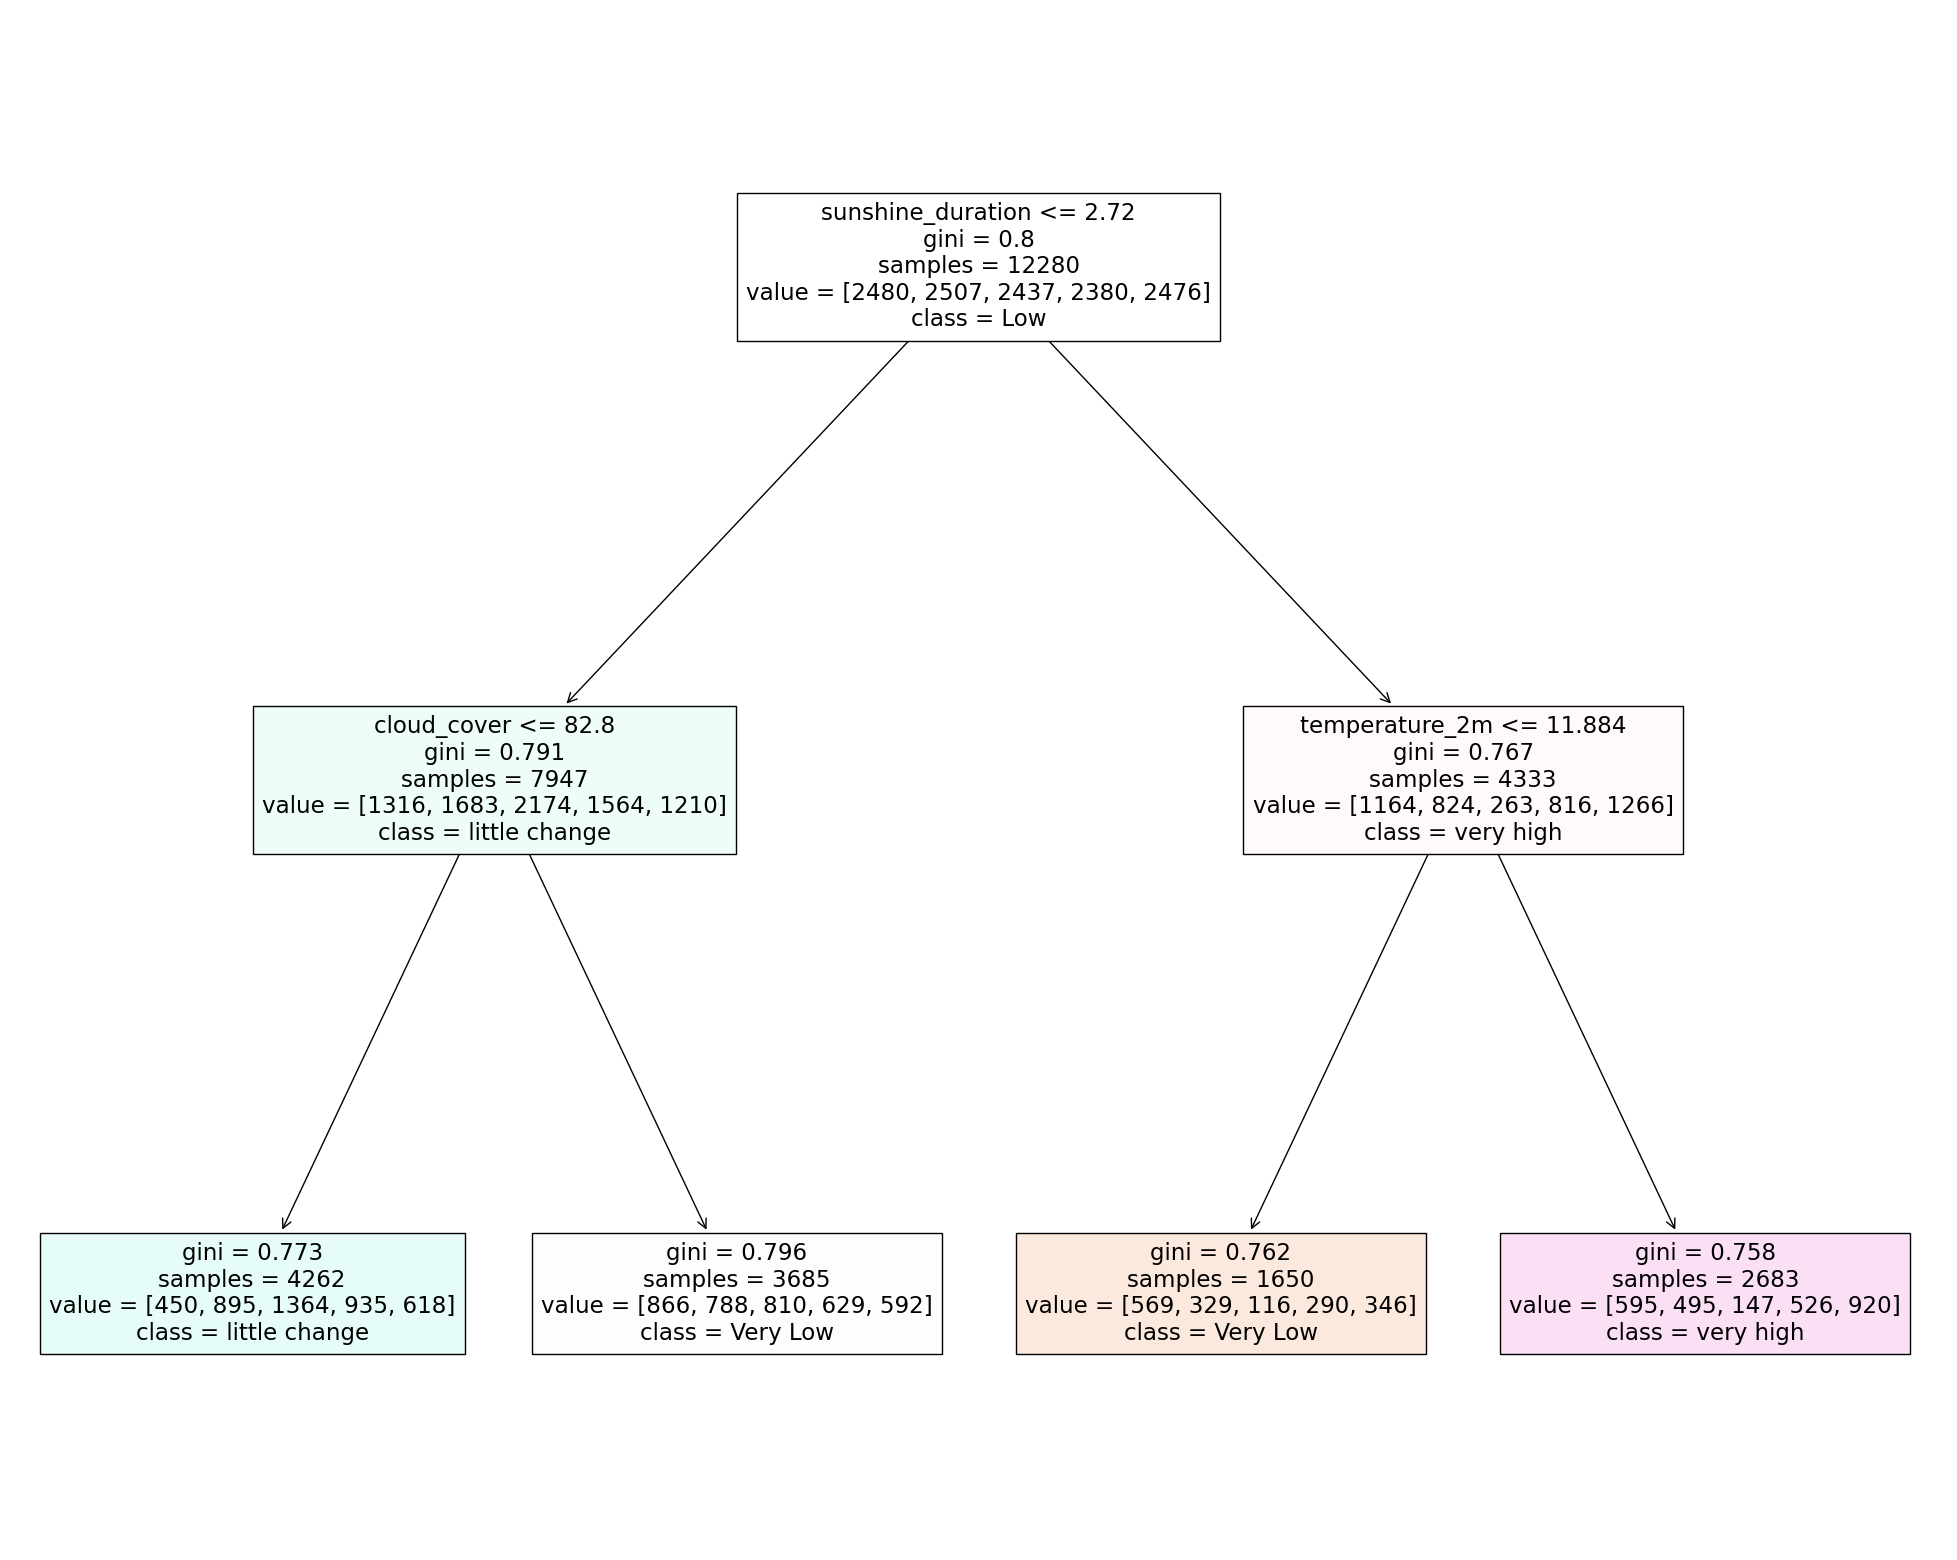

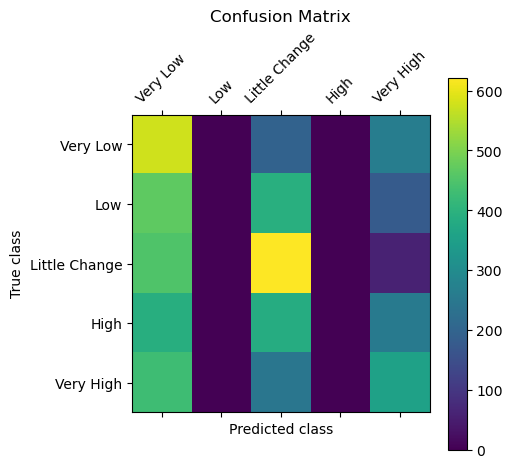

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\AppData\Local\Temp\ipykernel_11968\278161069.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Table = pd.concat([new_row,Table.loc[:]]).reset_index(drop=True)


log_loss Max Depth:  2


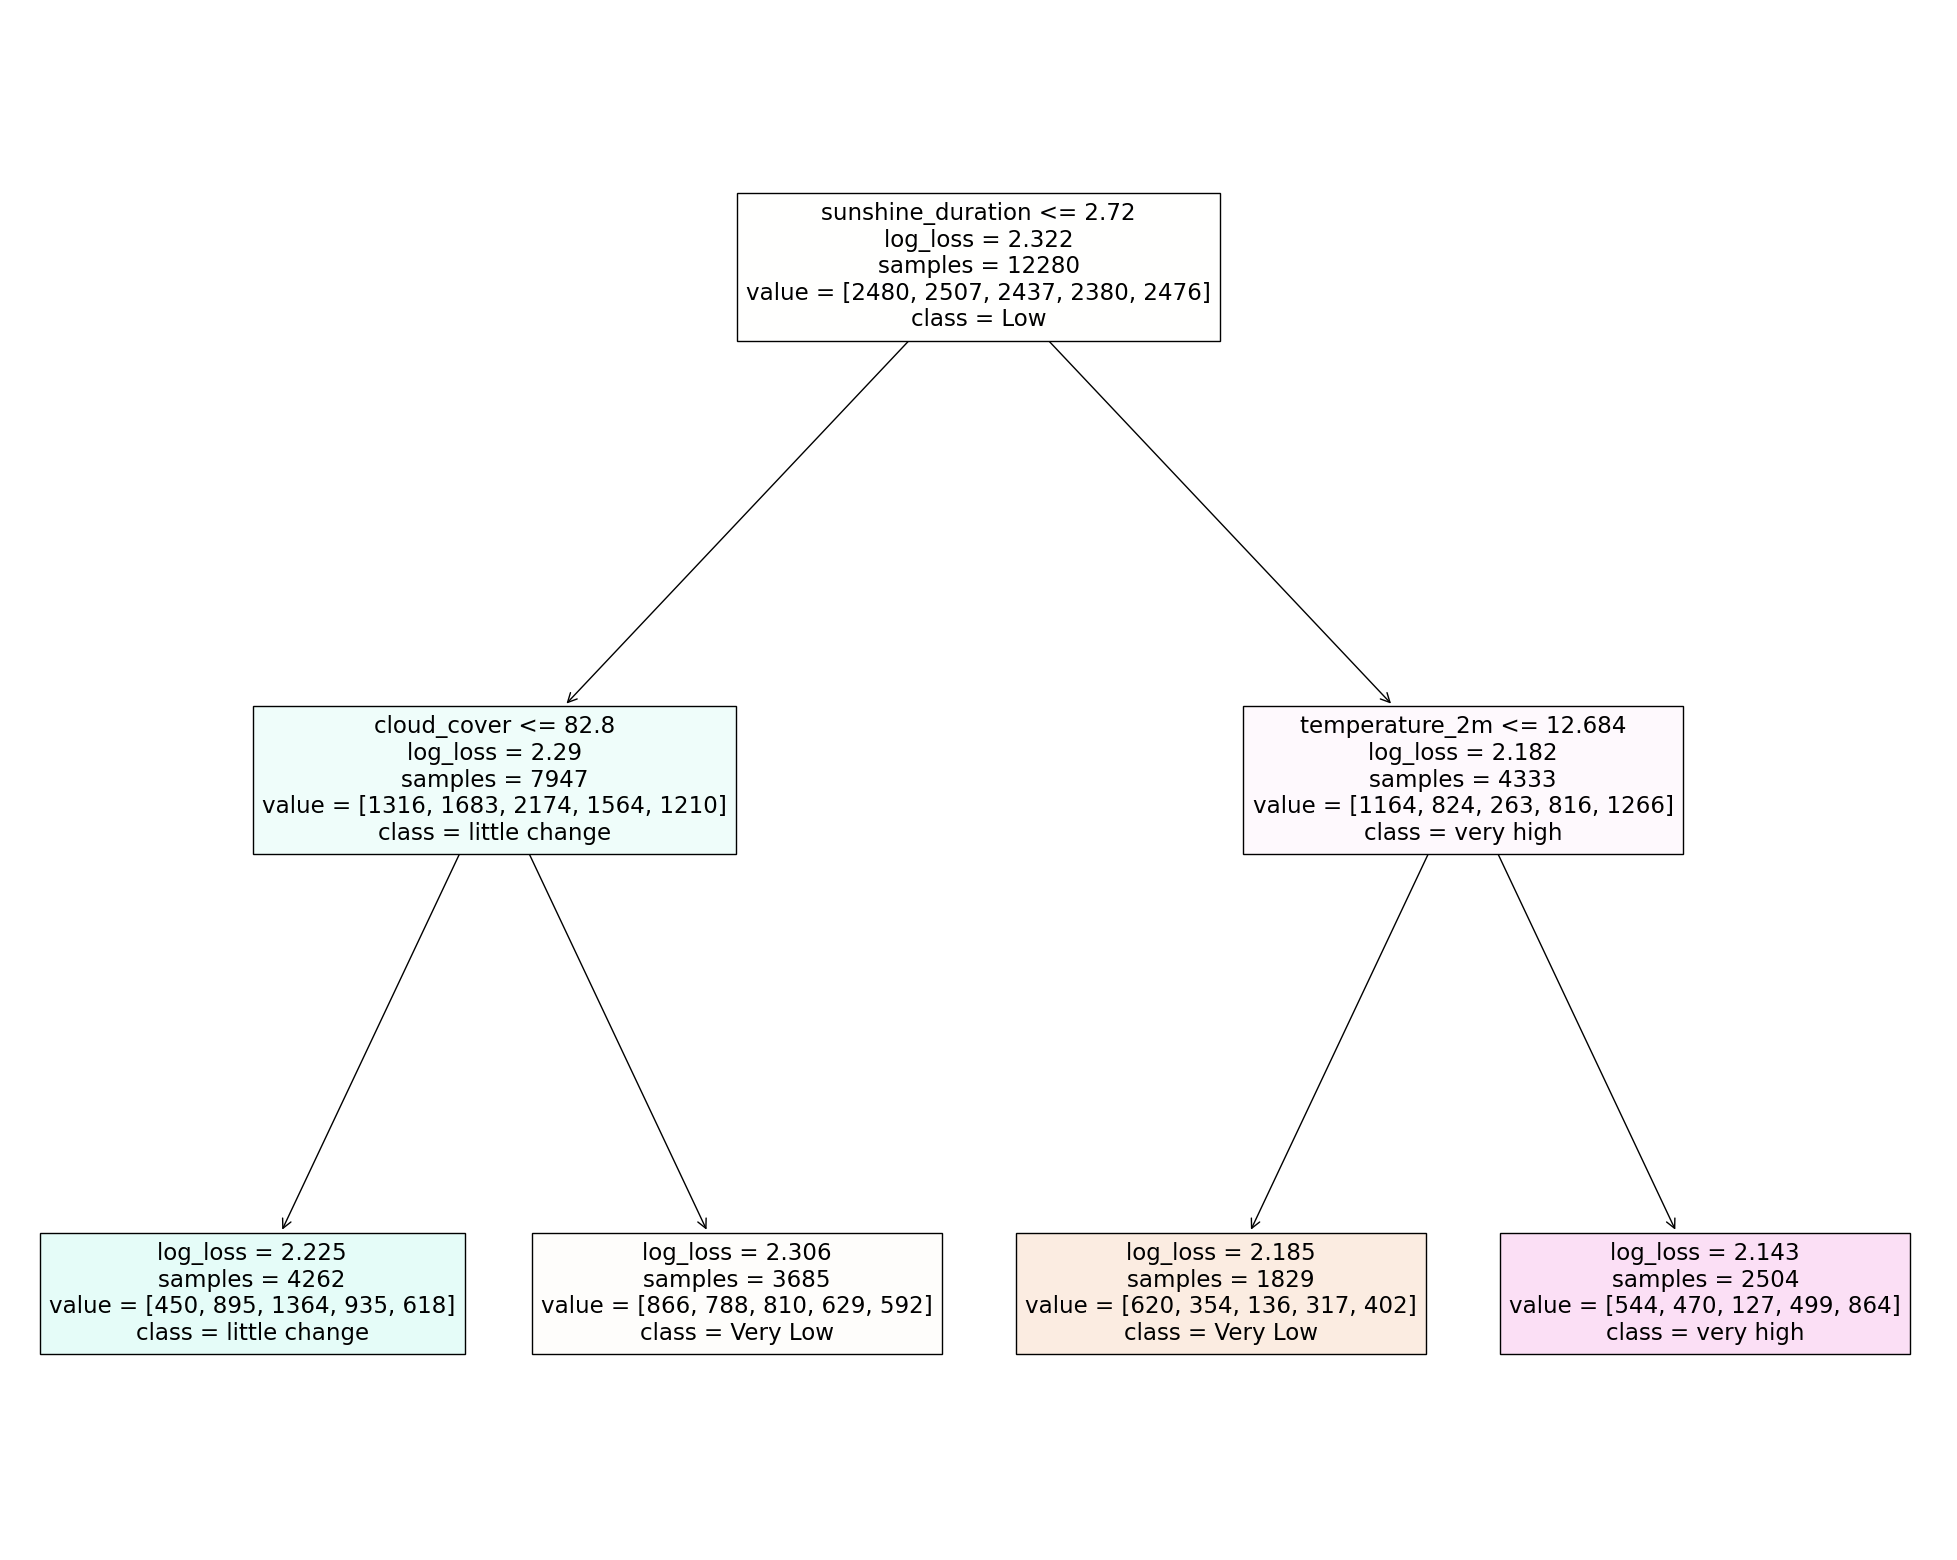

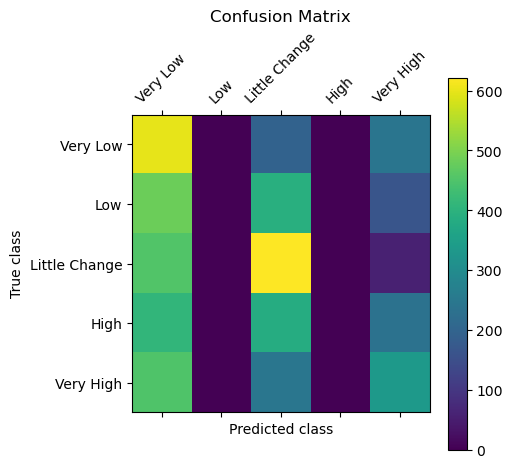

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


entropy Max Depth:  2


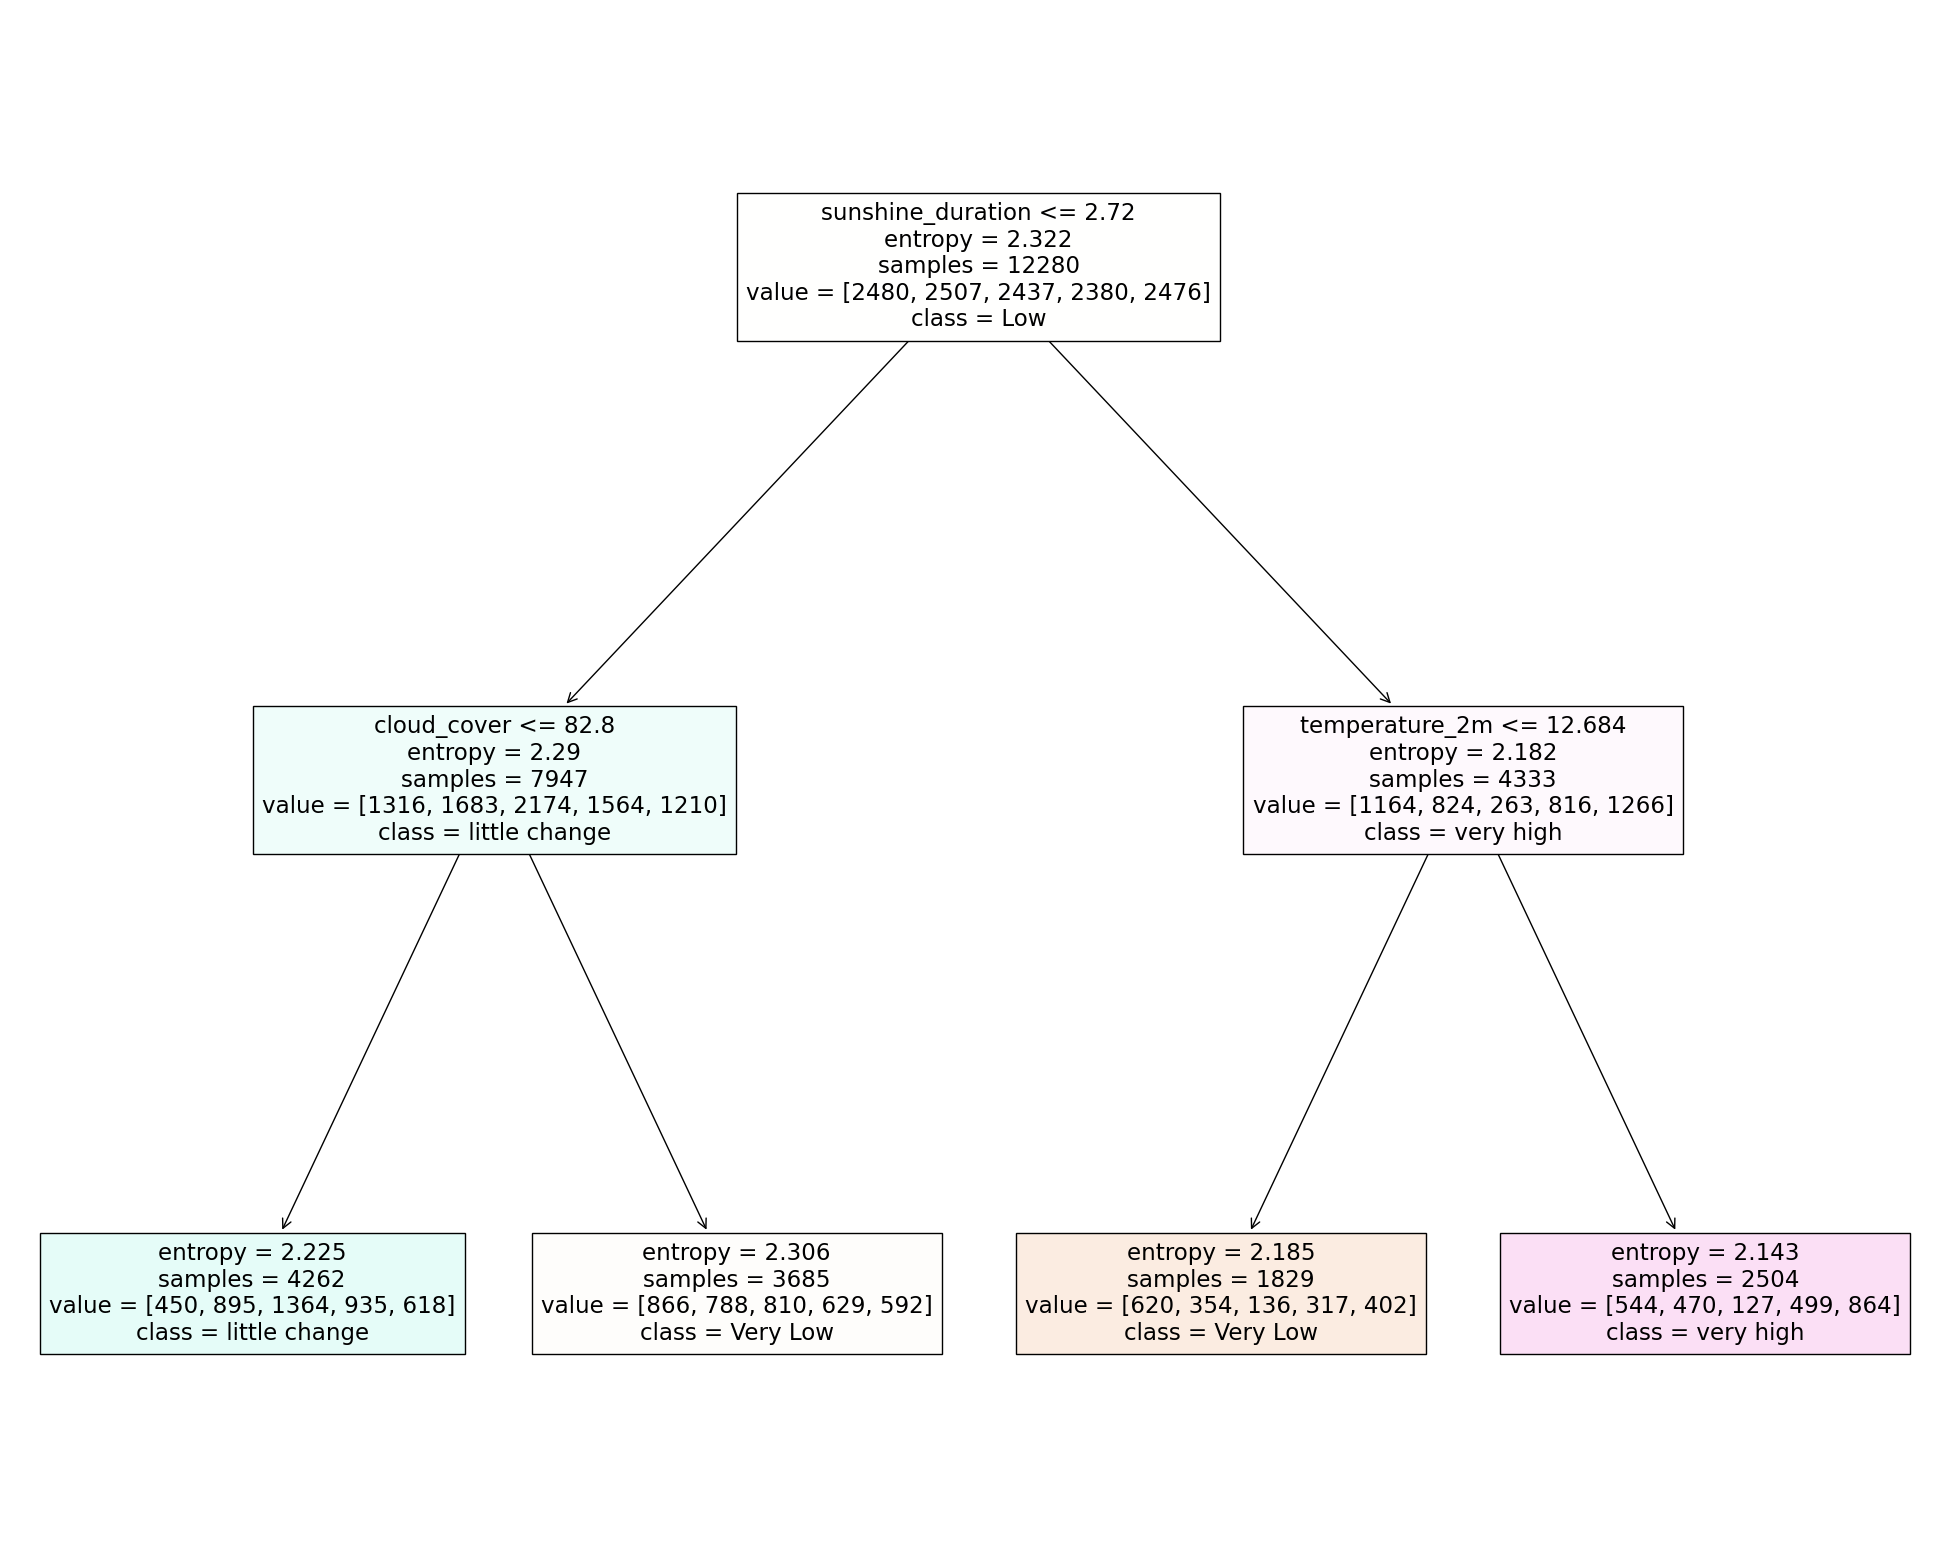

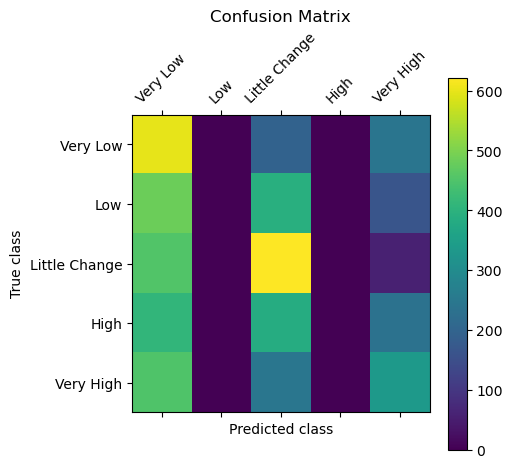

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


gini Max Depth:  3


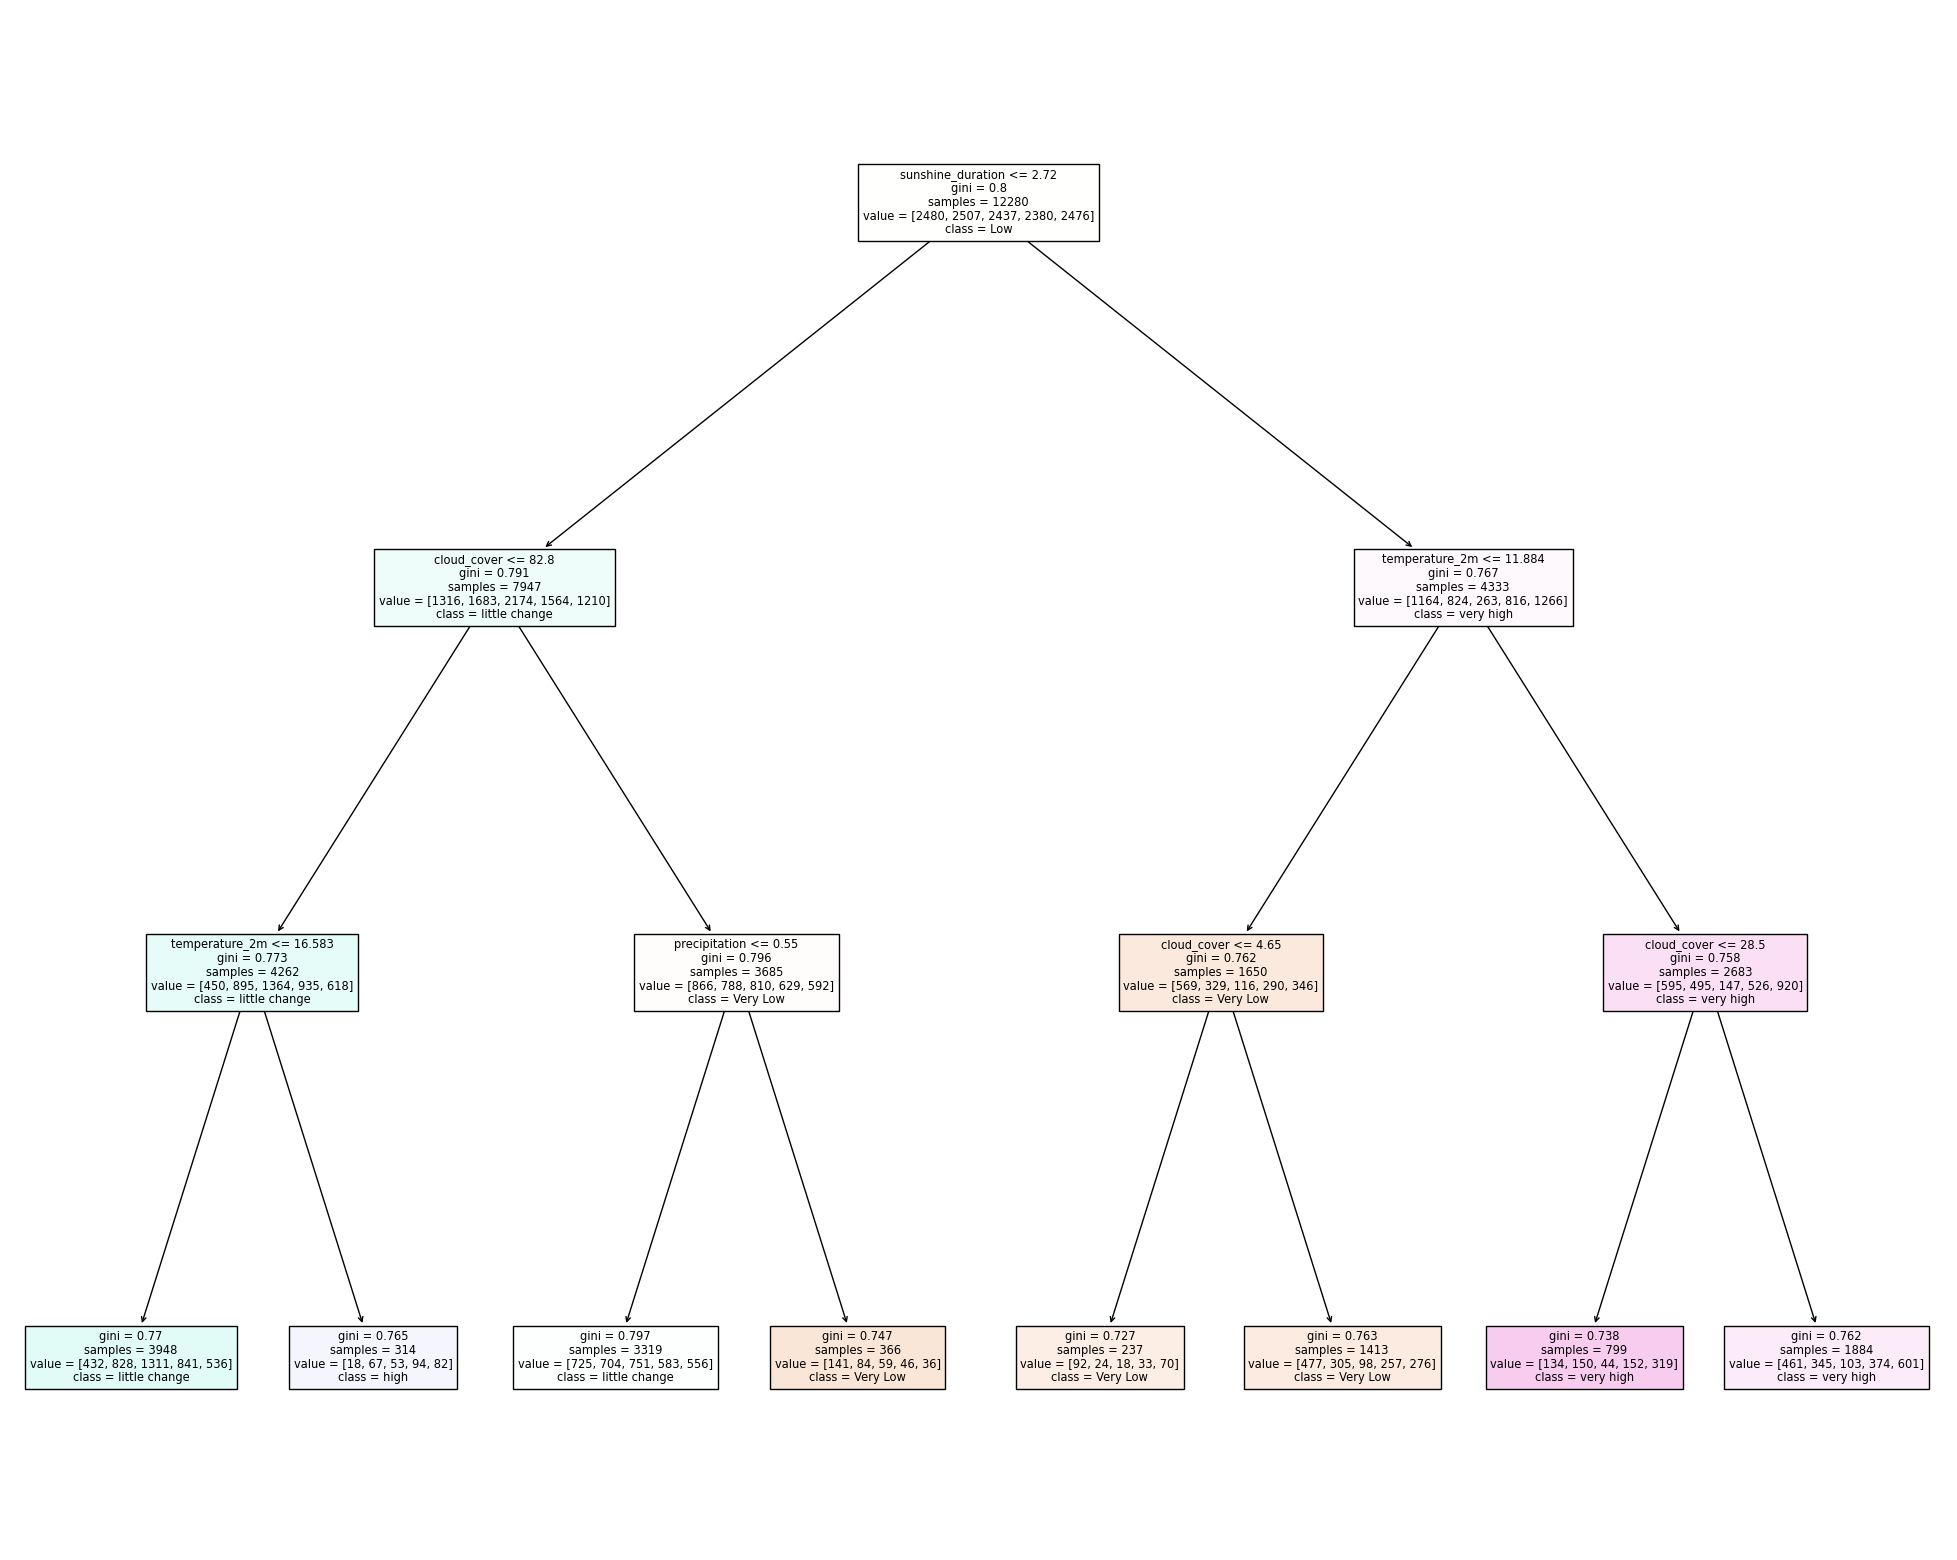

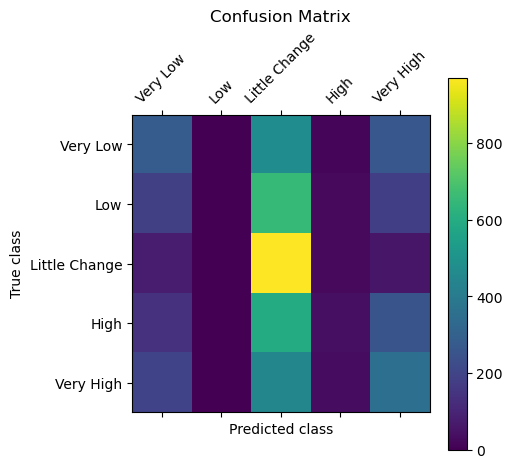

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


log_loss Max Depth:  3


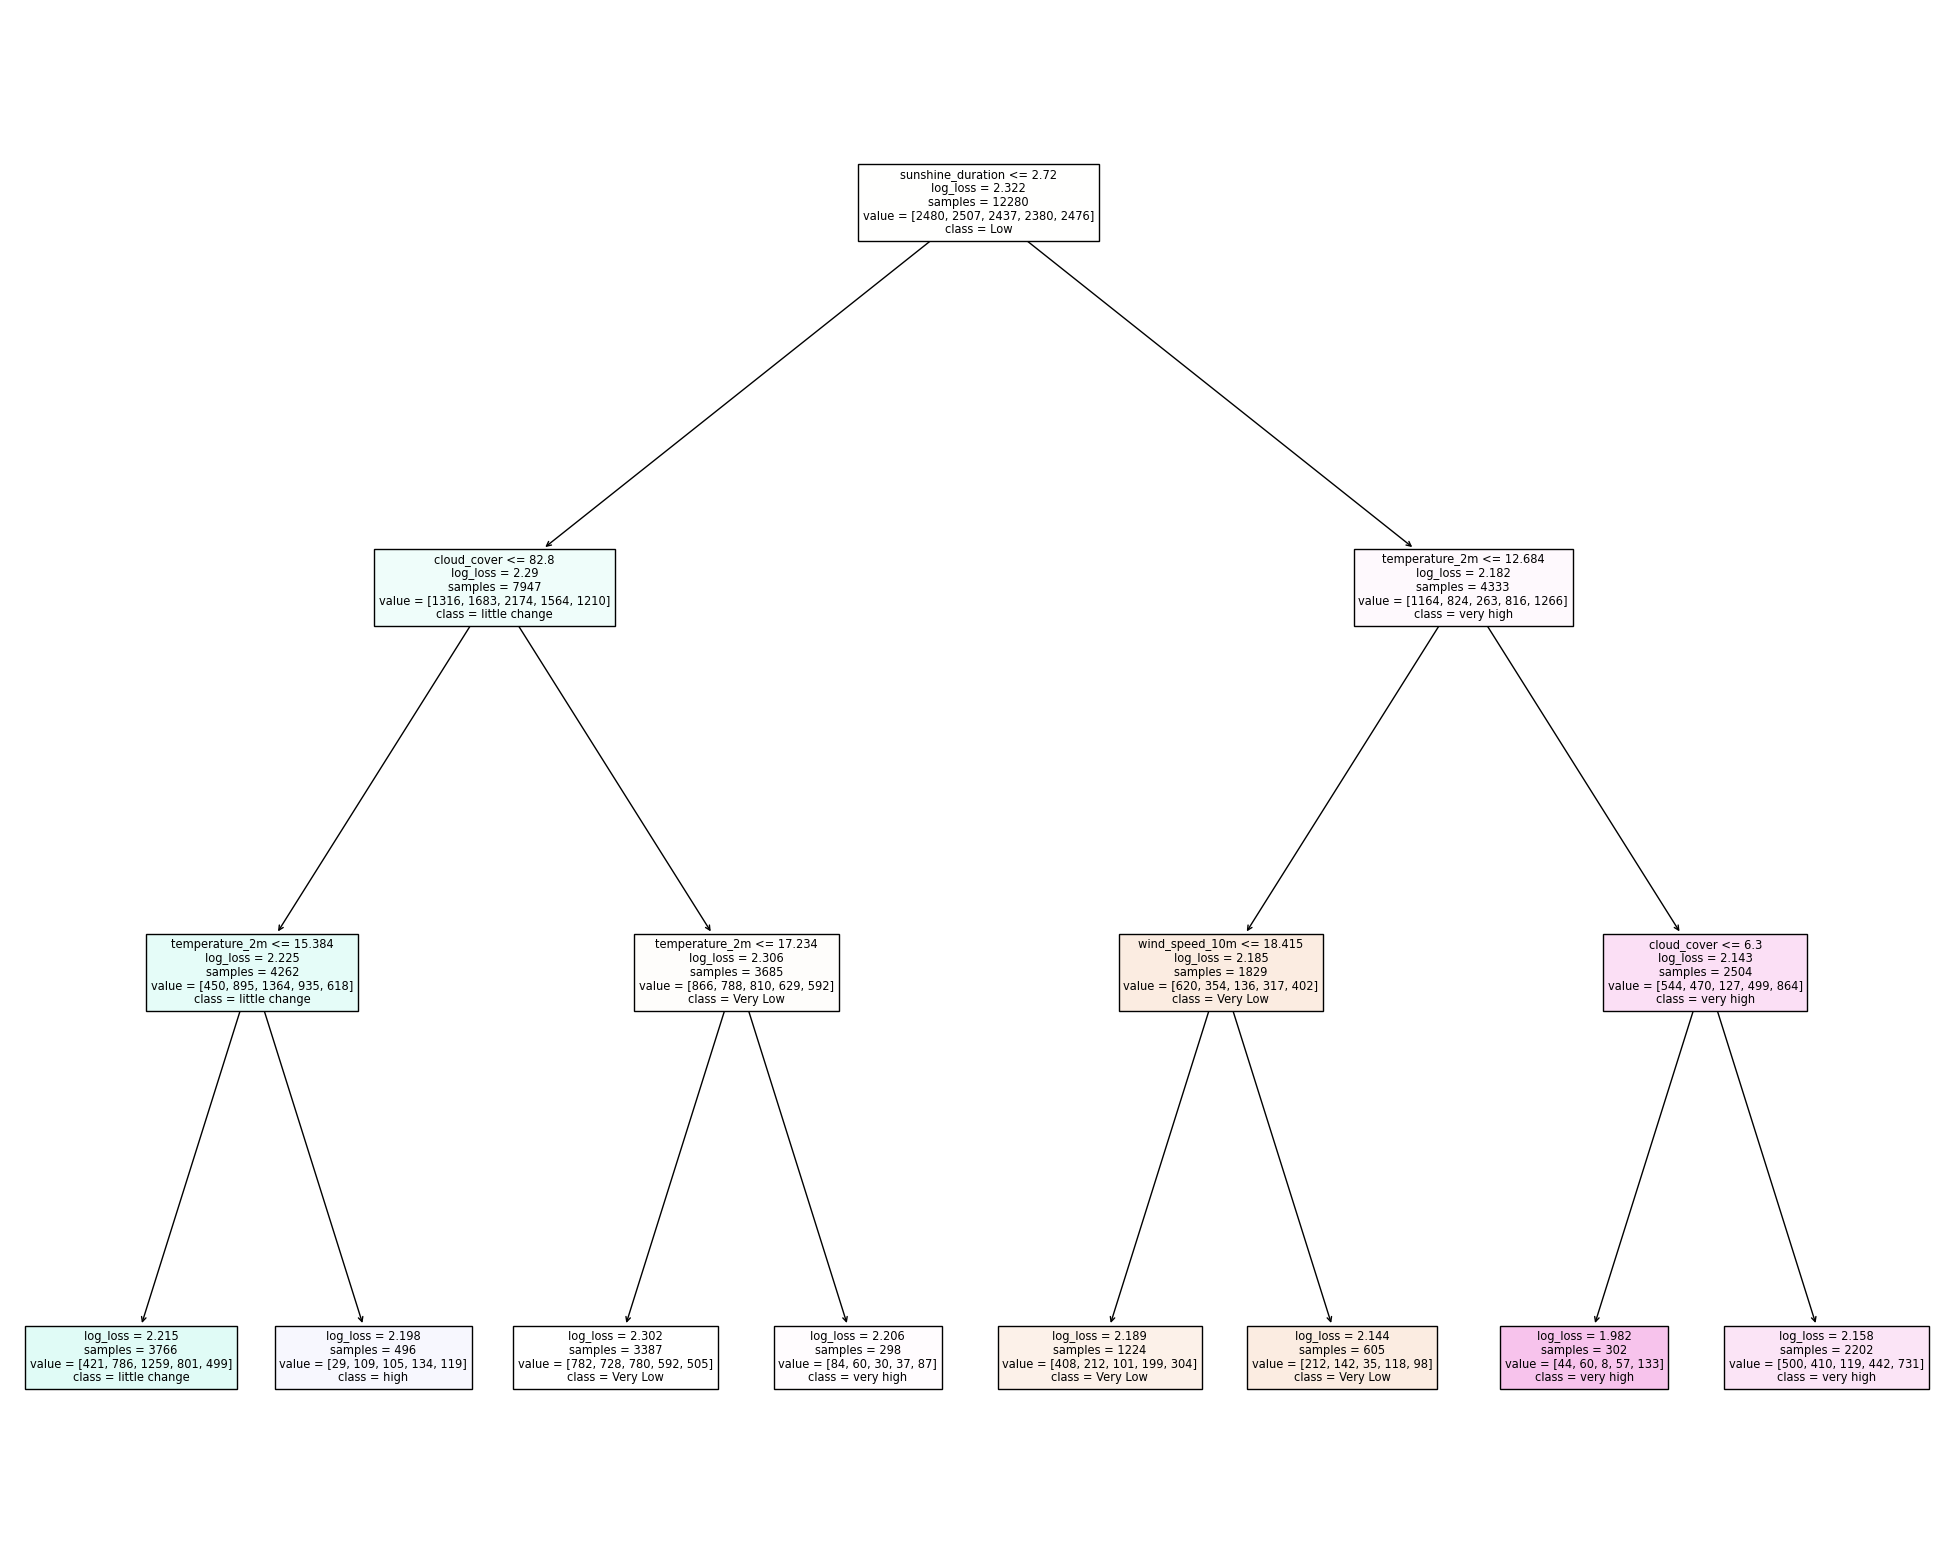

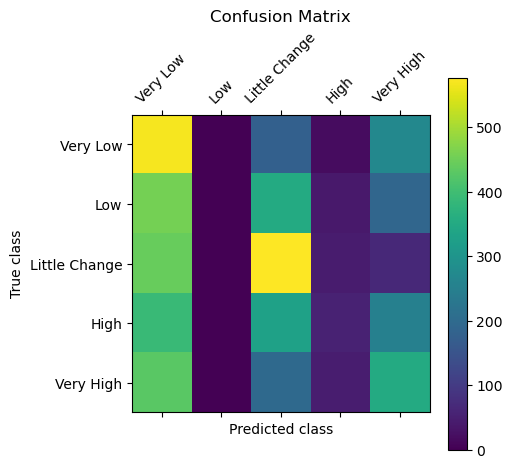

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


entropy Max Depth:  3


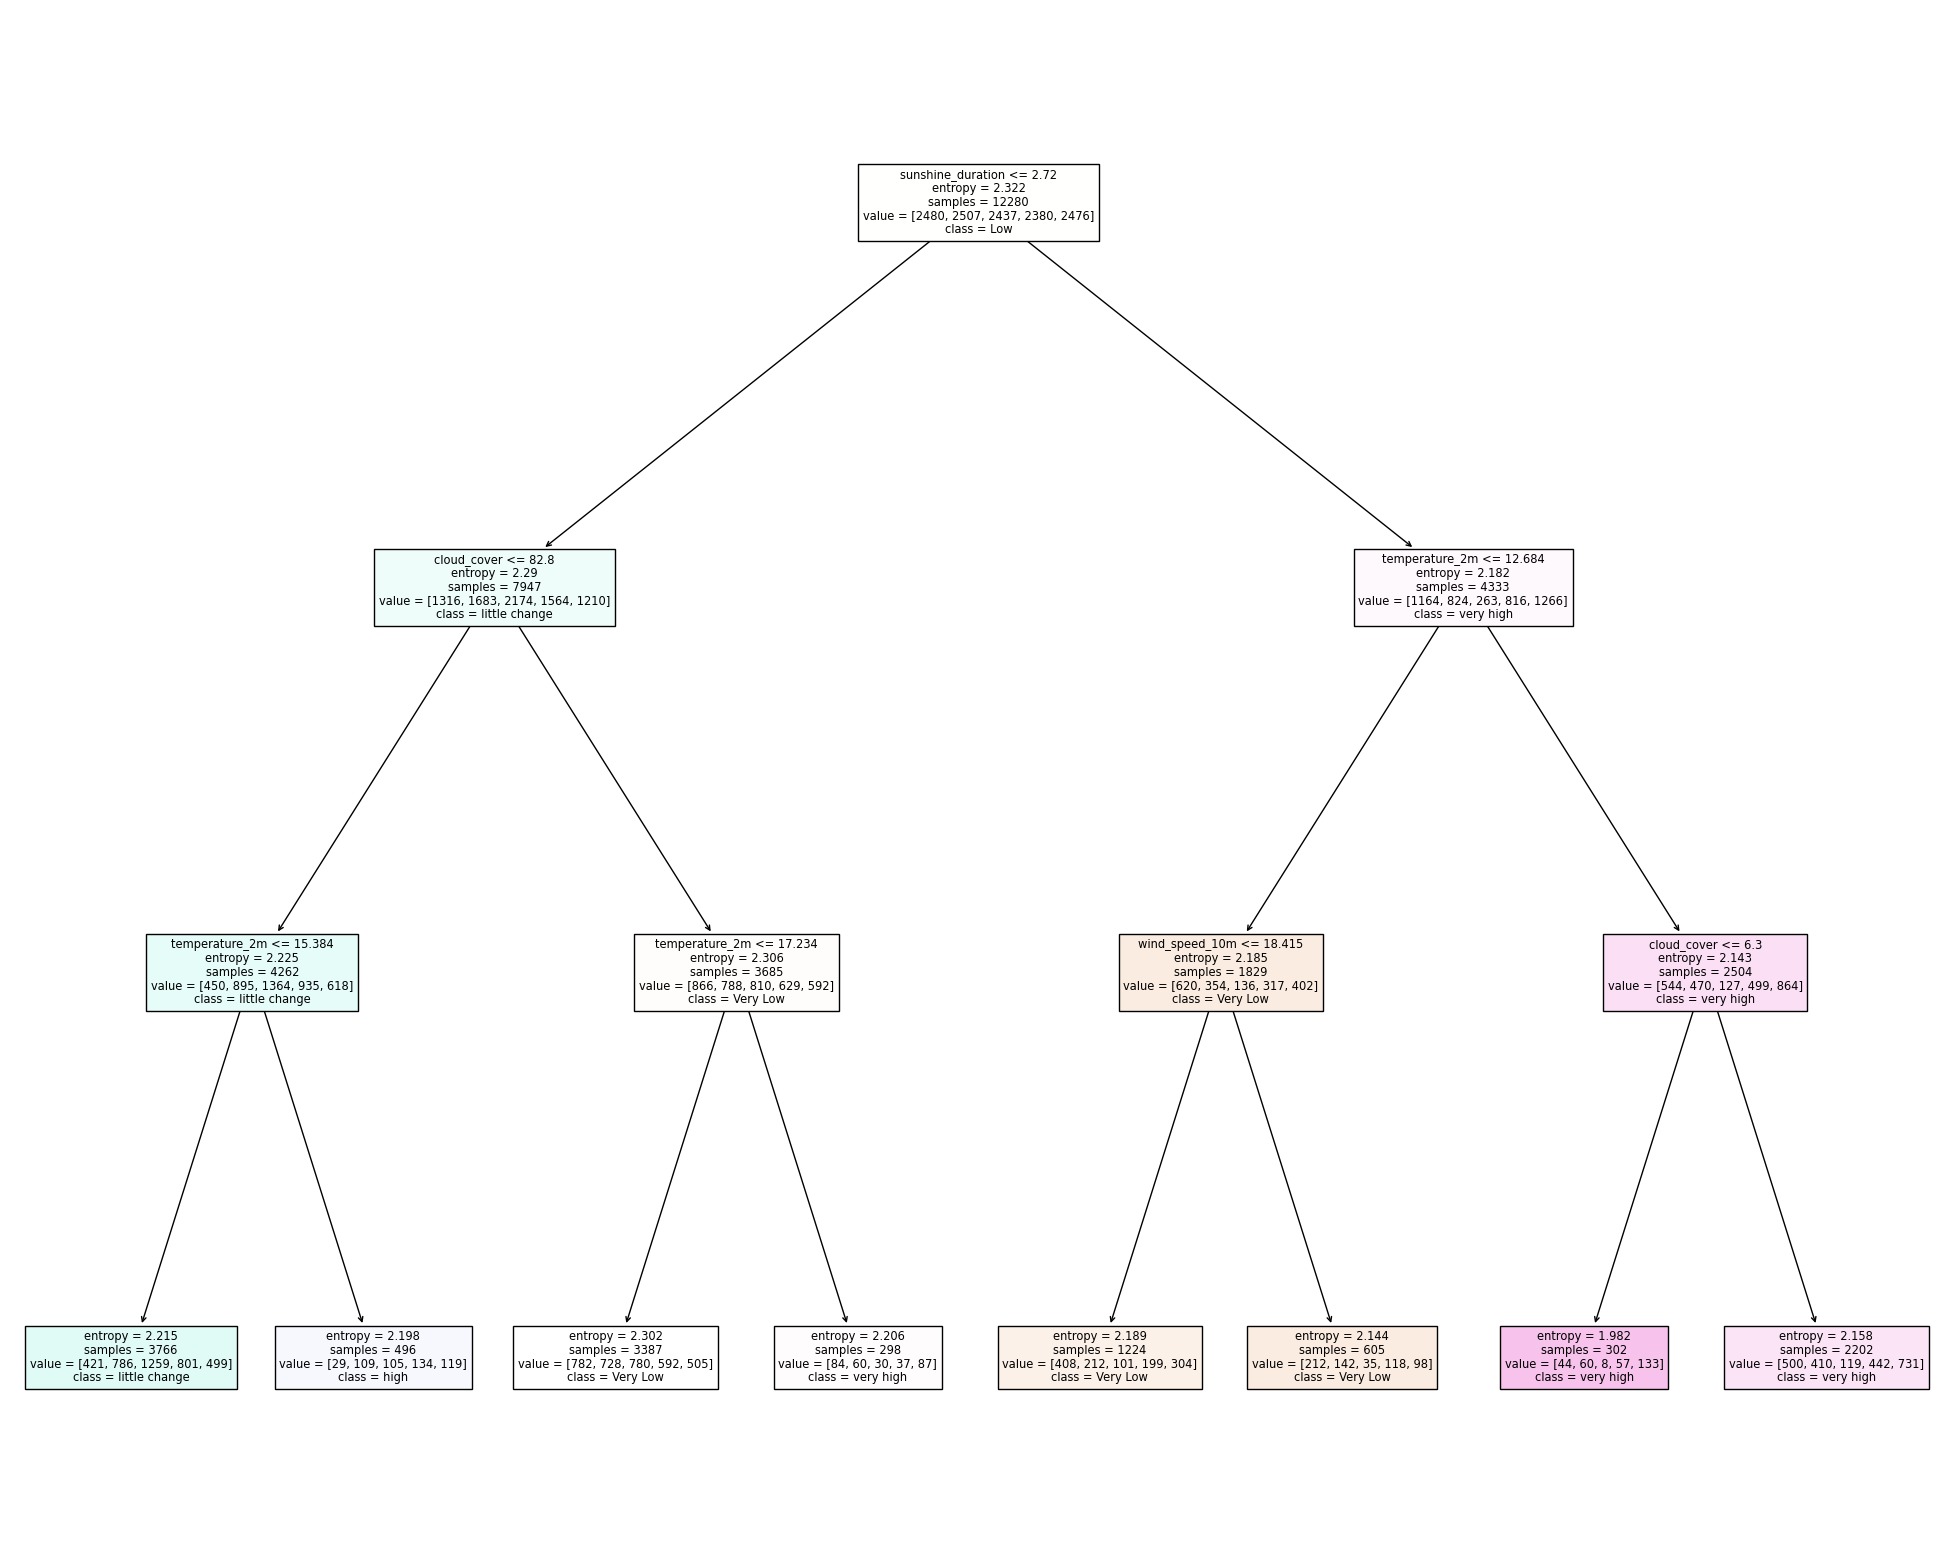

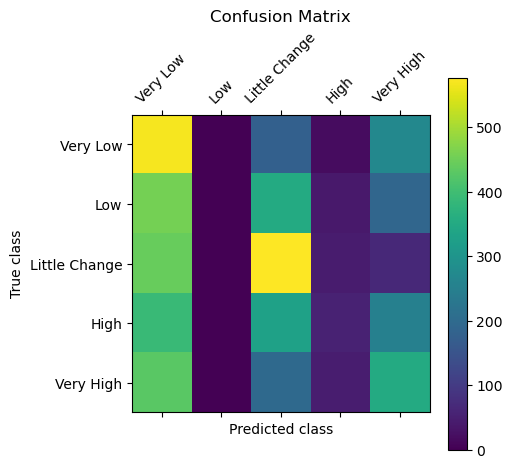

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


gini Max Depth:  4


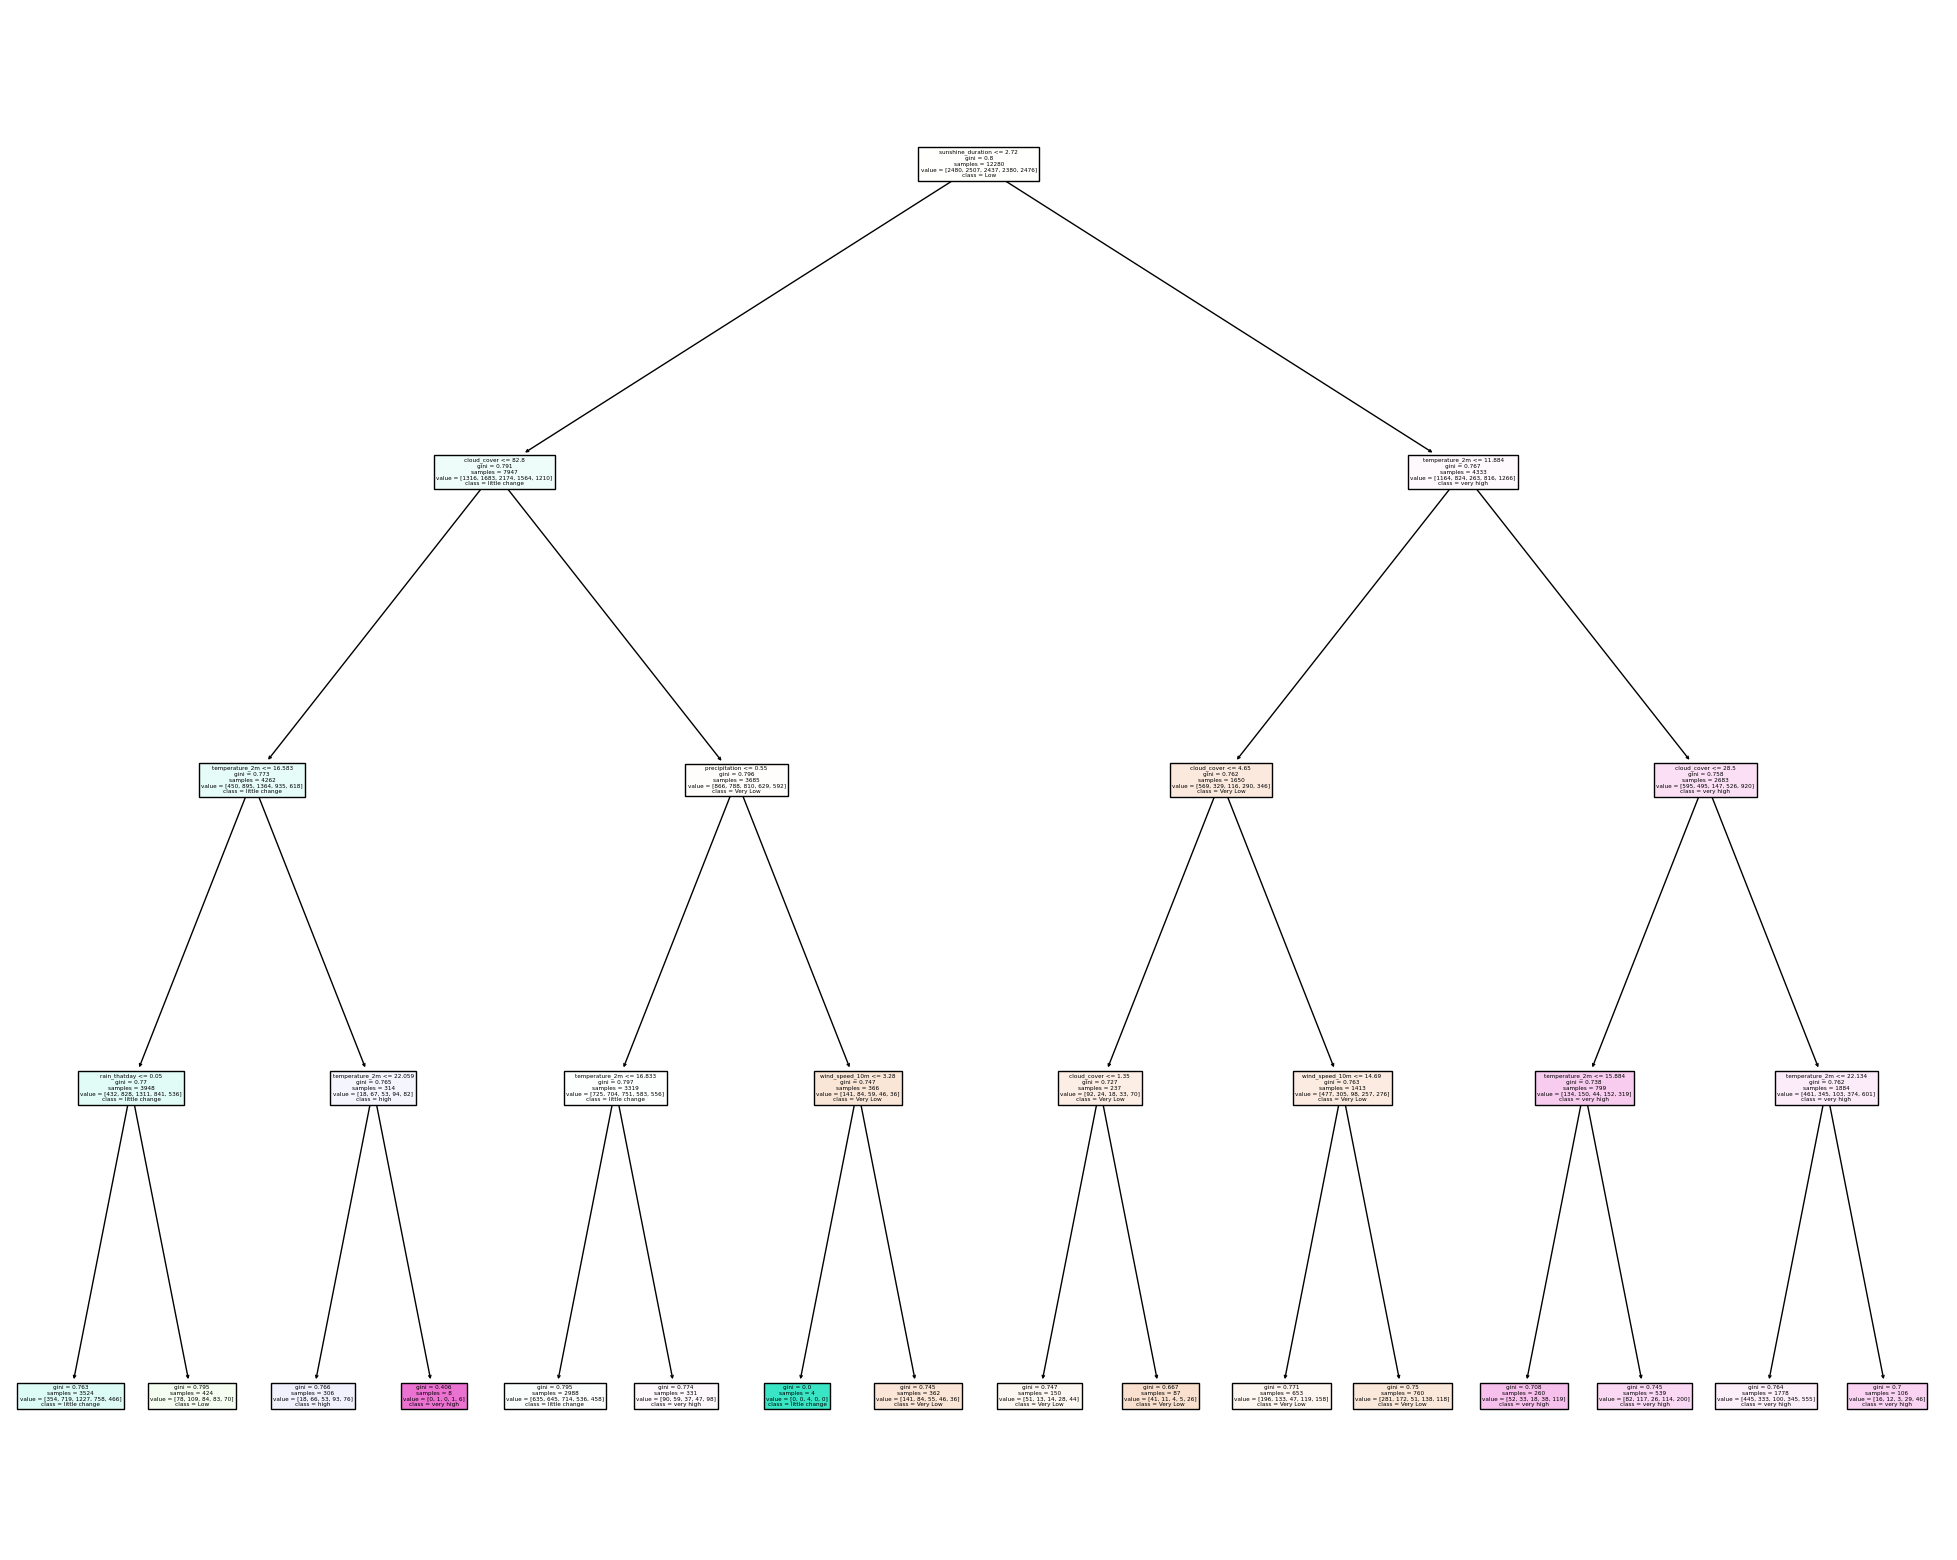

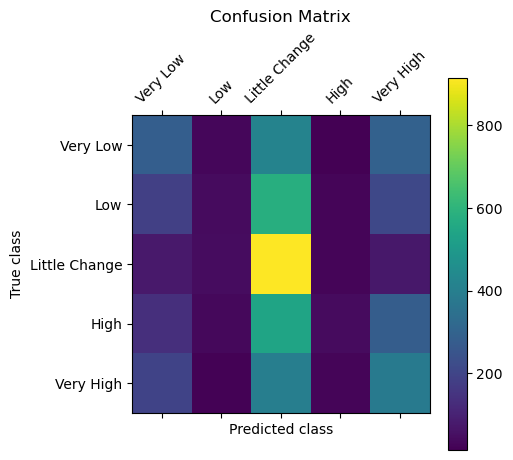

log_loss Max Depth:  4


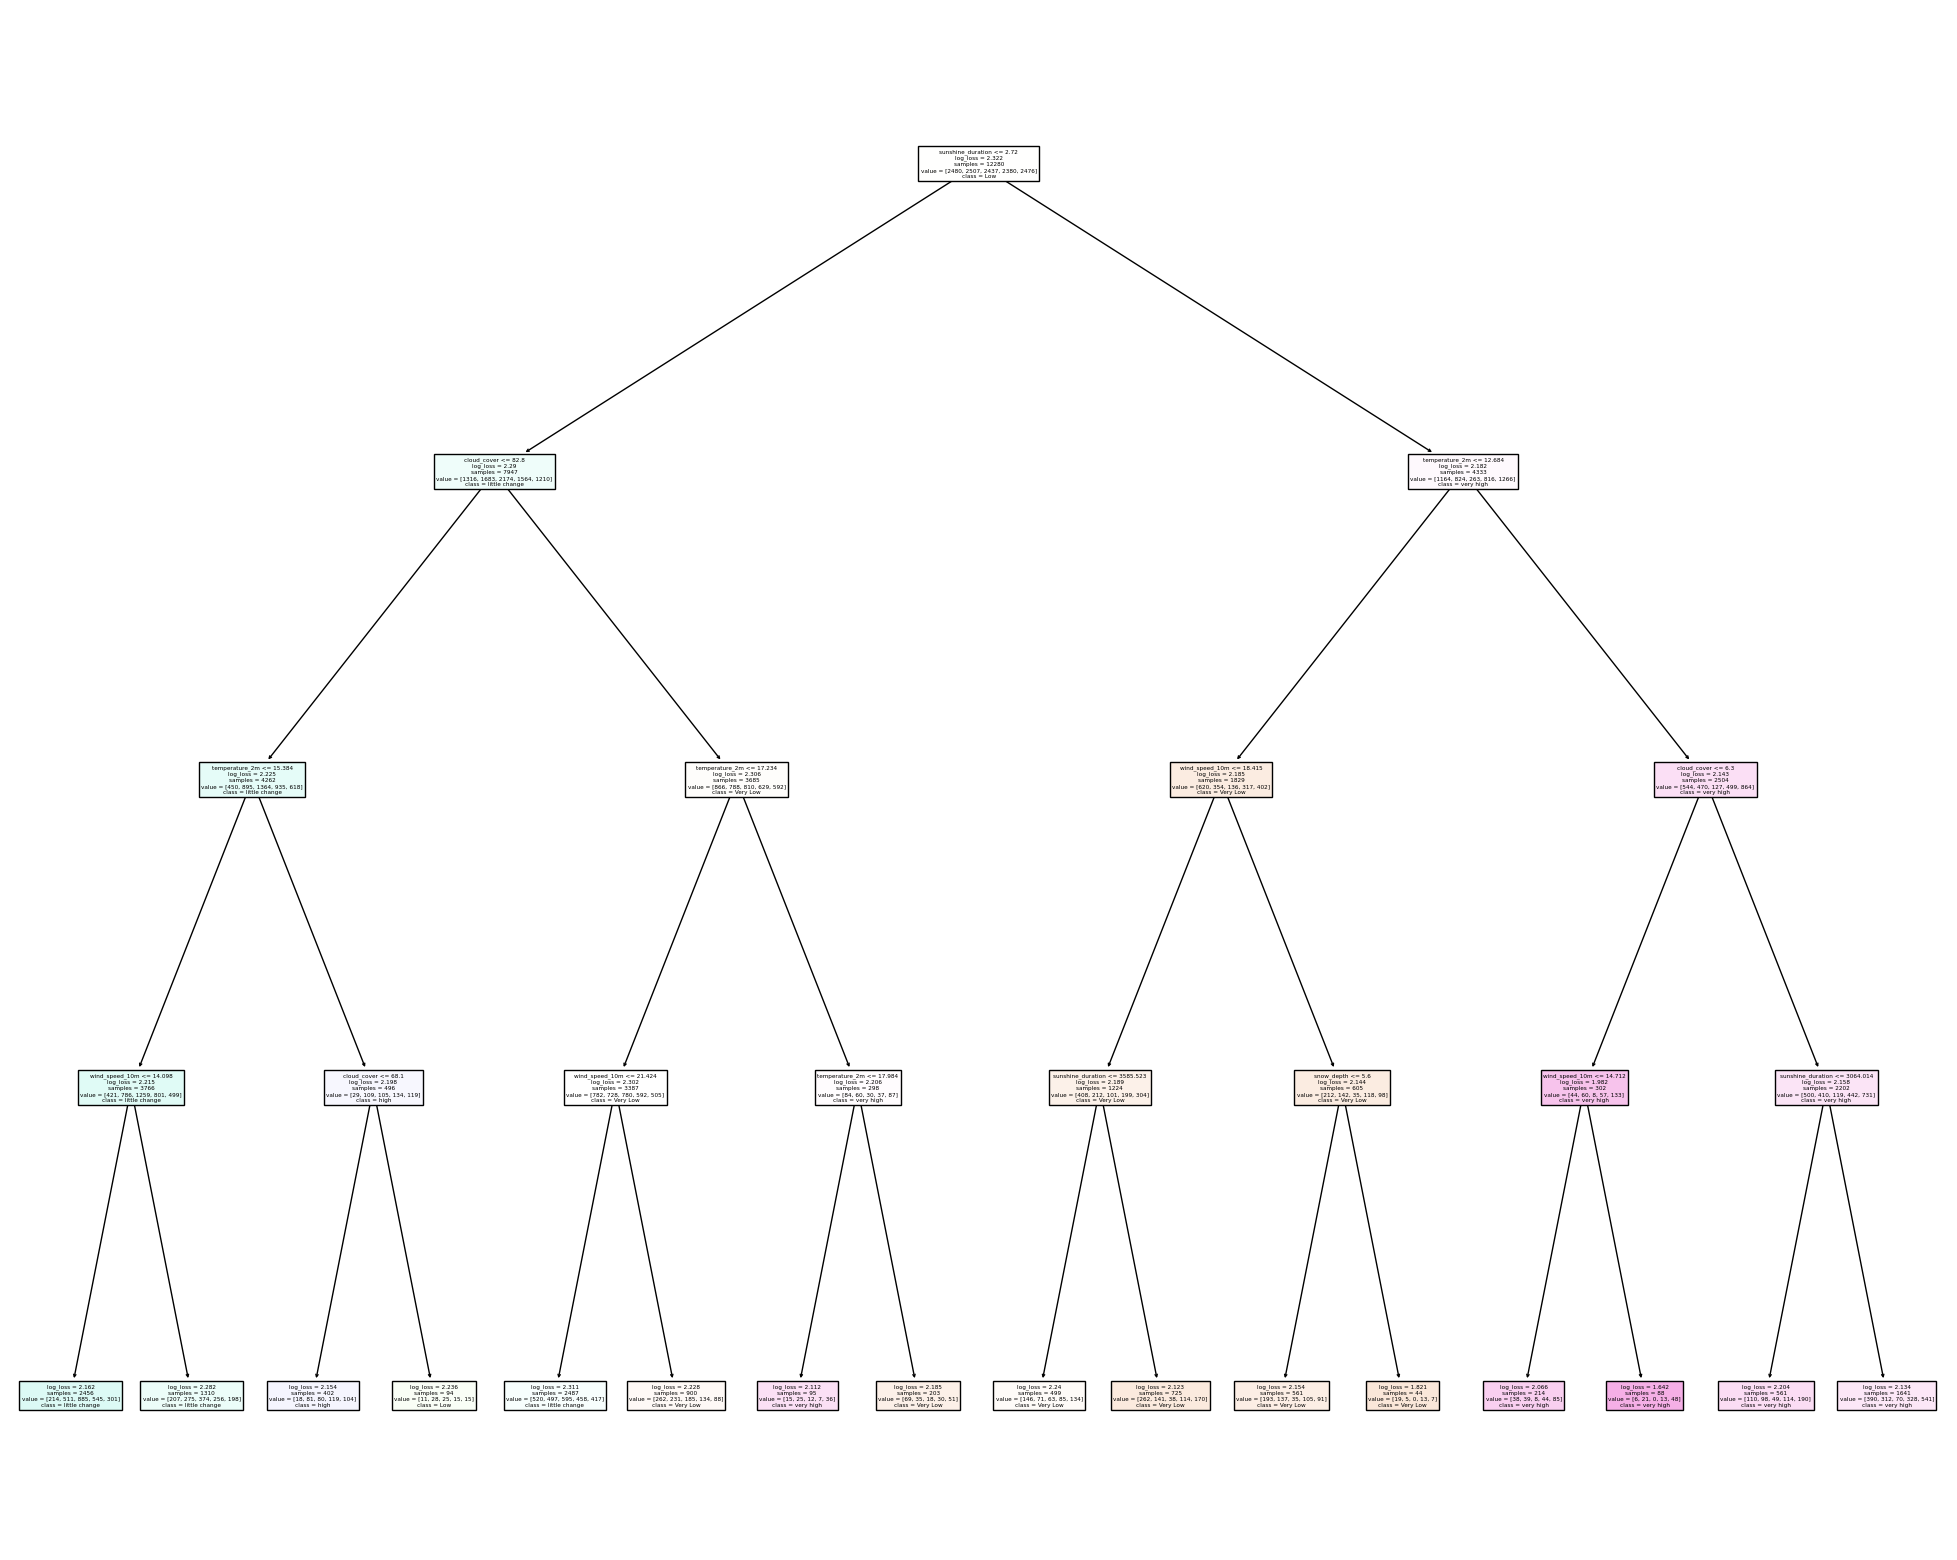

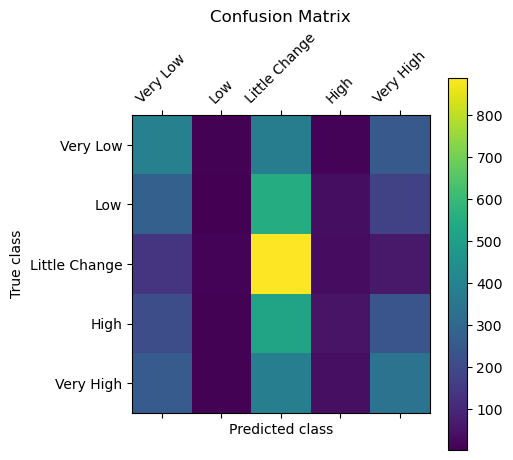

entropy Max Depth:  4


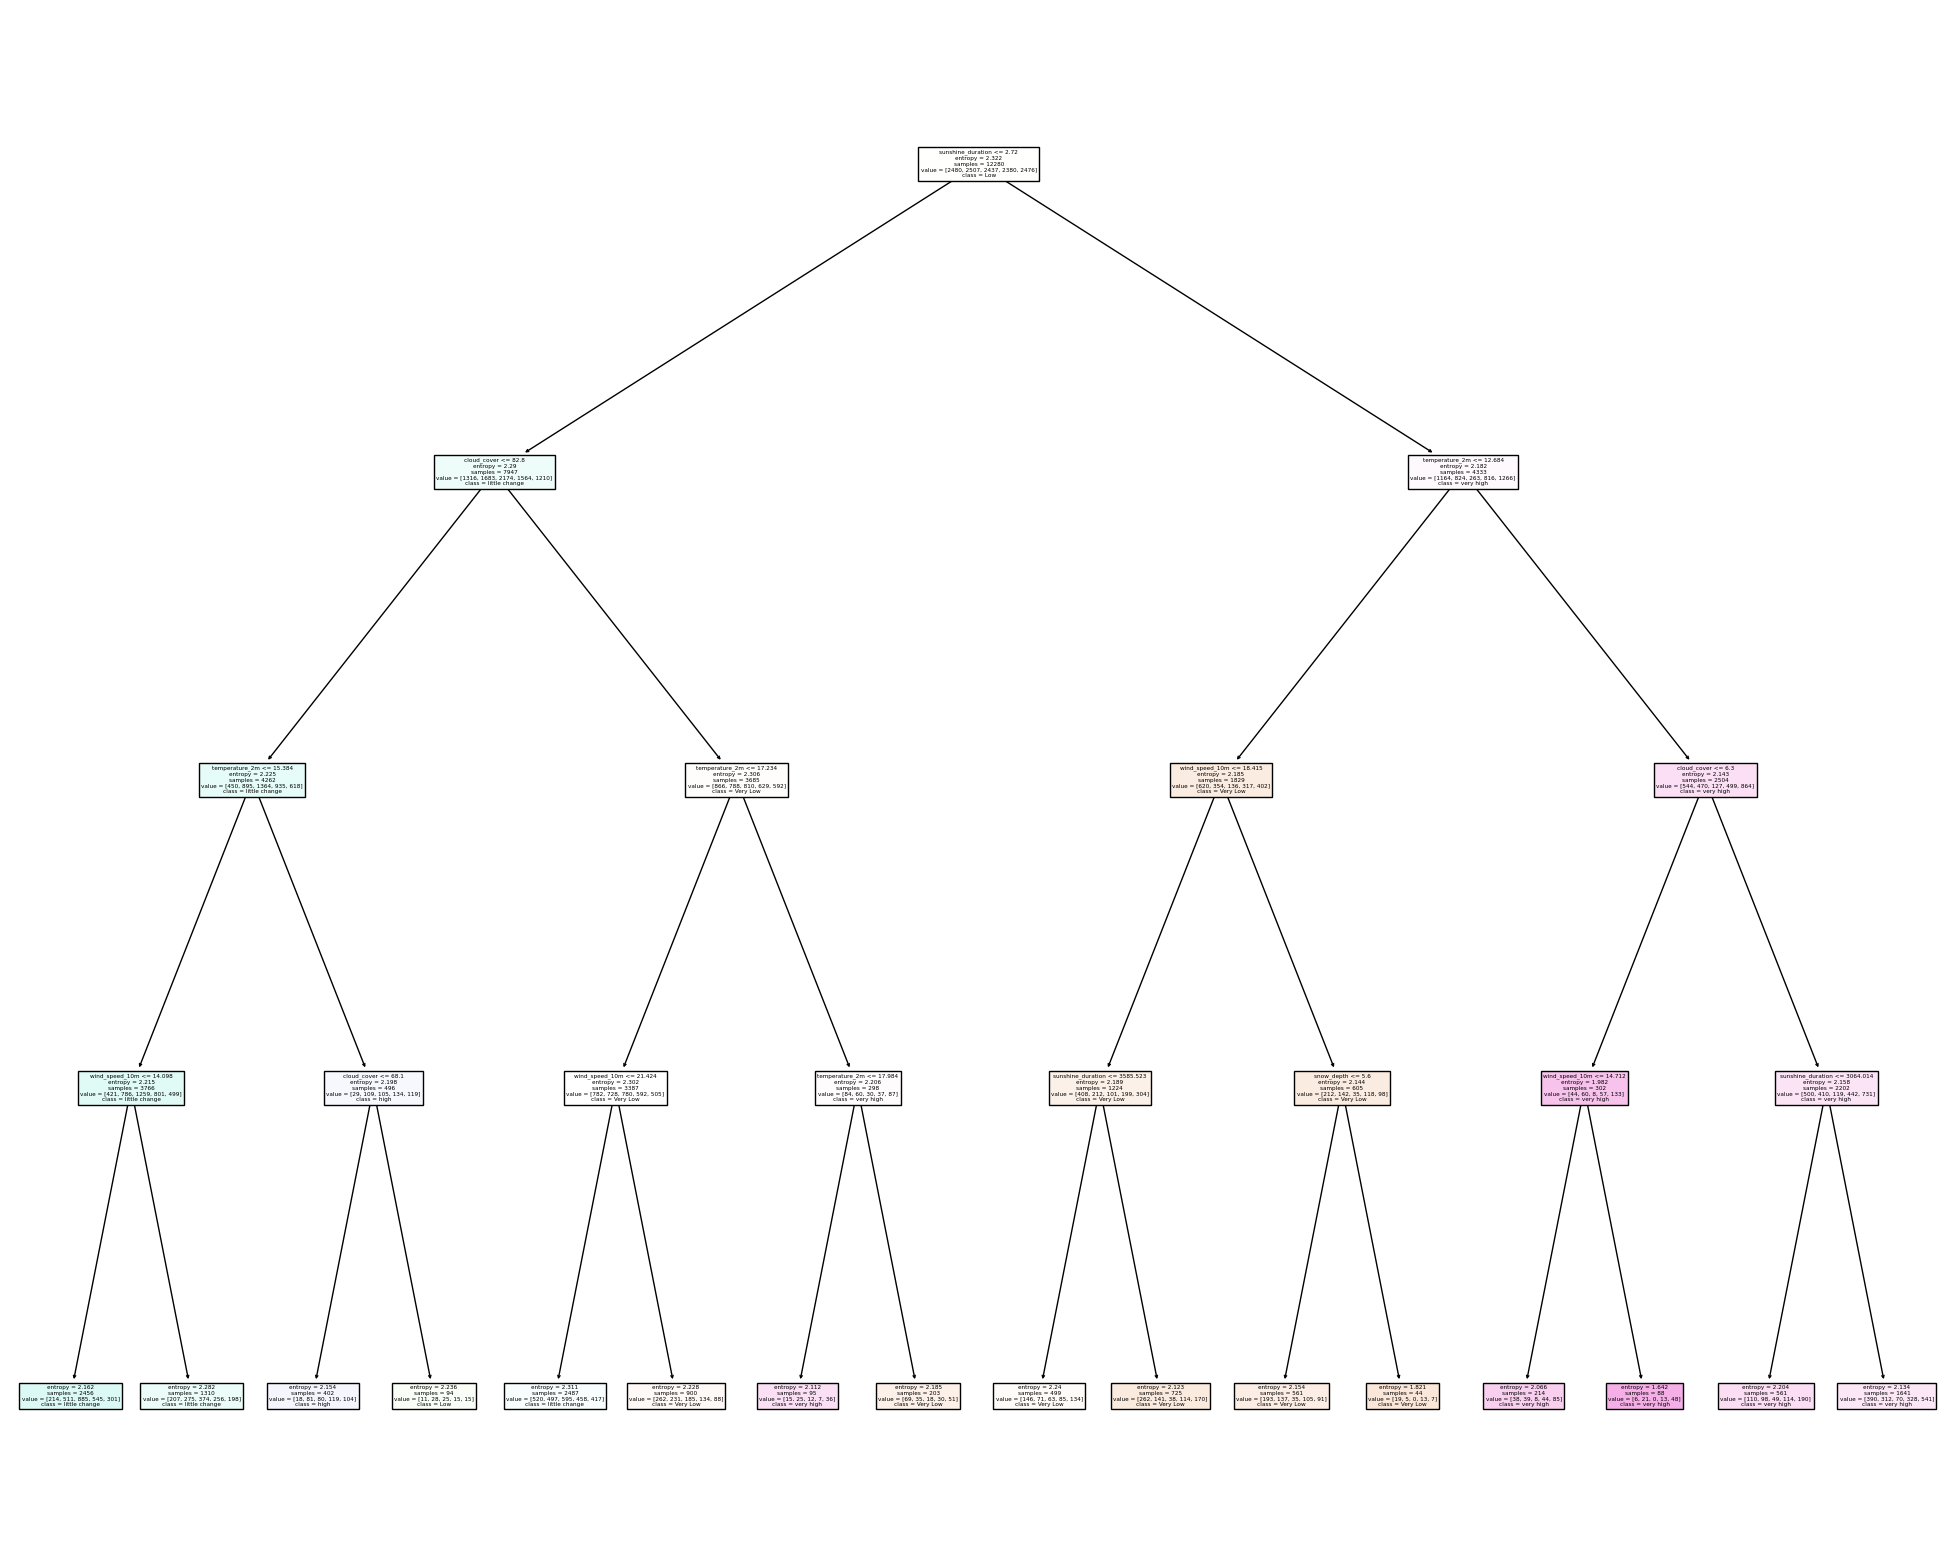

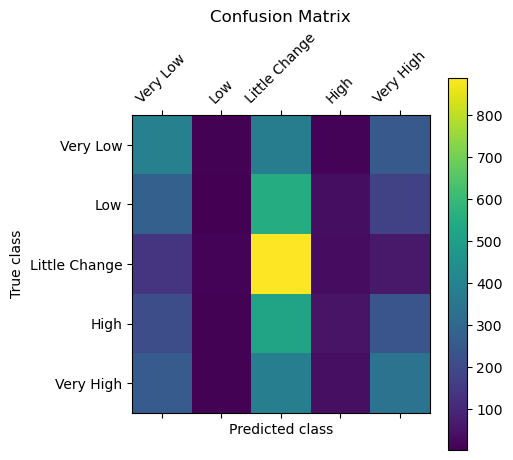

gini Max Depth:  5


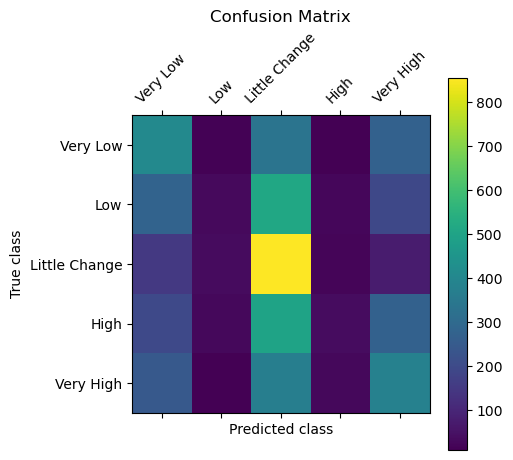

log_loss Max Depth:  5


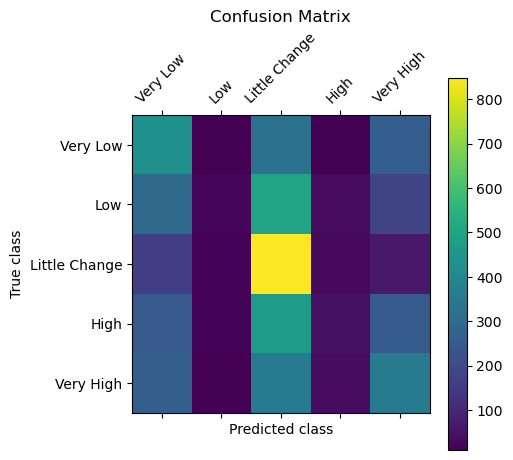

entropy Max Depth:  5


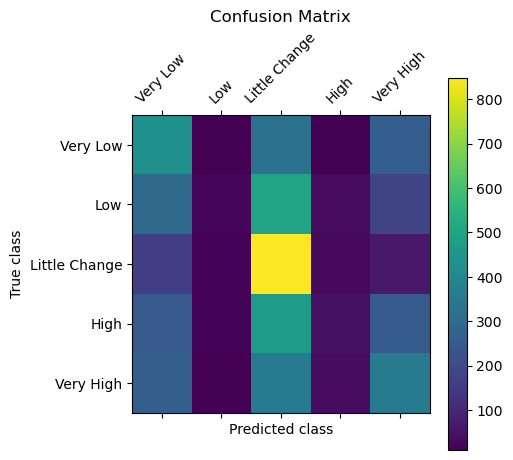

gini Max Depth:  6


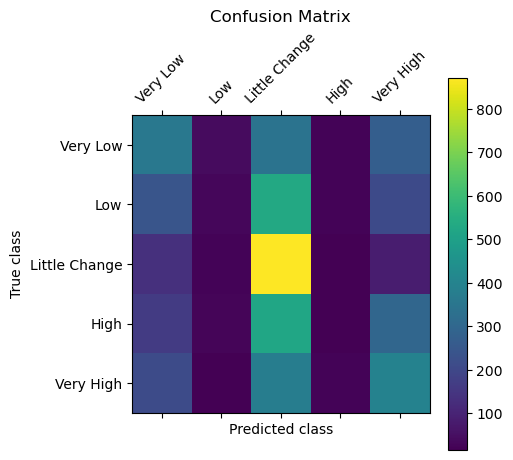

log_loss Max Depth:  6


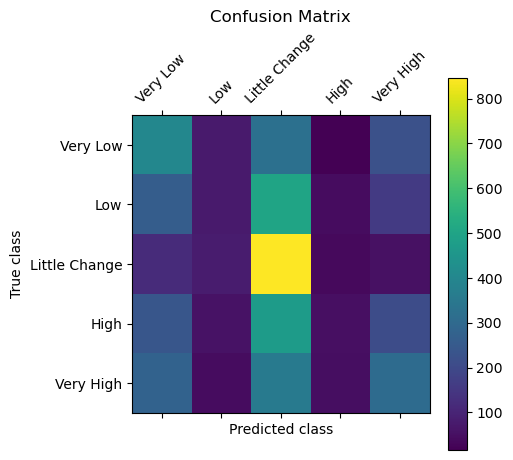

entropy Max Depth:  6


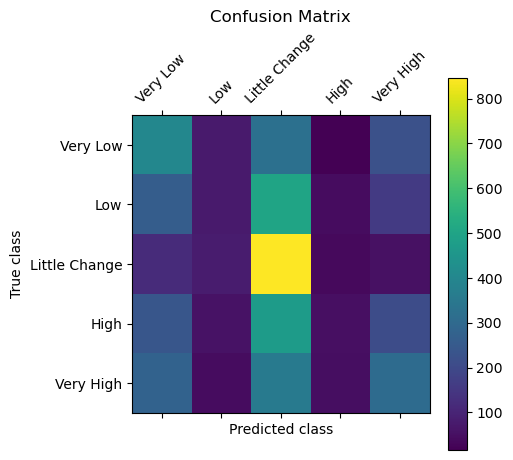

gini Max Depth:  7


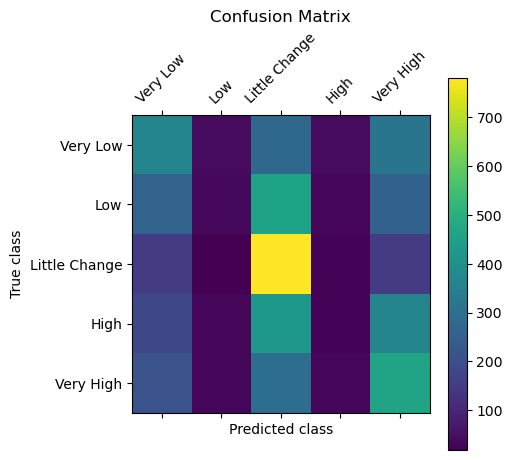

log_loss Max Depth:  7


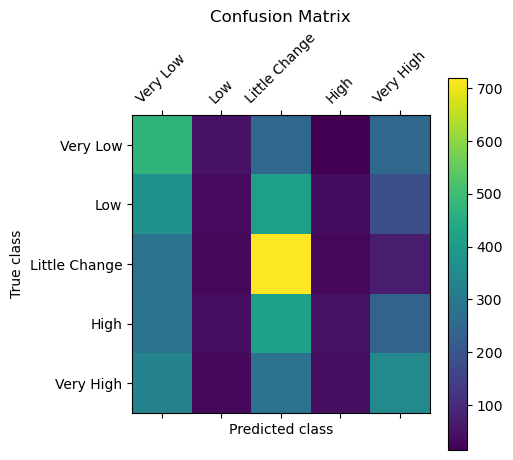

entropy Max Depth:  7


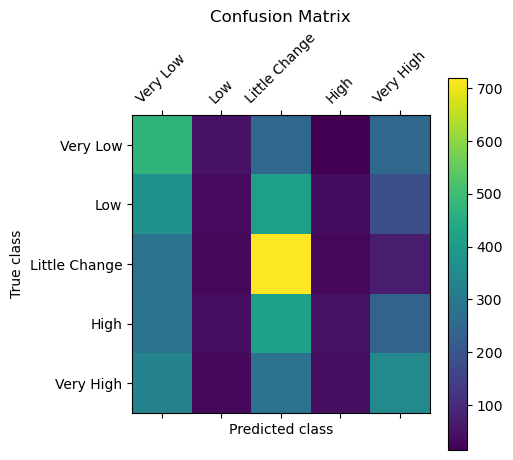

Machine_Learning_Algorithm    Recall  Precision  F1_Score  Run_time
0         entropyMax Depth: 7  0.307751   0.280385  0.253883  0.169078
1        log_lossMax Depth: 7  0.307751   0.280385  0.253883  0.169248
2            giniMax Depth: 7  0.316869   0.270189  0.254173  0.125776
3         entropyMax Depth: 6  0.319149   0.294128  0.266784  0.143276
4        log_lossMax Depth: 6  0.319149   0.294128  0.266784  0.141224
5            giniMax Depth: 6  0.317629   0.267806  0.248570  0.086367
6         entropyMax Depth: 5  0.323898   0.304368  0.258116  0.094720
7        log_lossMax Depth: 5  0.323898   0.304368  0.258116  0.058448
8            giniMax Depth: 5  0.324468   0.310377  0.258619  0.058924
9         entropyMax Depth: 4  0.317439   0.264434  0.246155  0.094295
10       log_lossMax Depth: 4  0.317439   0.264434  0.246155  0.088562
11           giniMax Depth: 4  0.315540   0.300071  0.249752  0.070677
12        entropyMax Depth: 3  0.295593   0.238868  0.238658  0.058699
13       log_lossMax Depth: 3  0.295593   0.238868  0.238658  0.056673
14           giniMax Depth: 3  0.313450   0.249028  0.234463  0.048205
15        entropyMax Depth: 2  0.295213   0.184995  0.221909  0.039552
16       log_lossMax Depth: 2  0.295213   0.184995  0.221909  0.032505
17           giniMax Depth: 2  0.295213   0.184147  0.222618  0.033404

In [217]:
Decision_Tree(x_train154,y_train154,x_test154,y_test154,Table1 ,True,feature_names1)

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


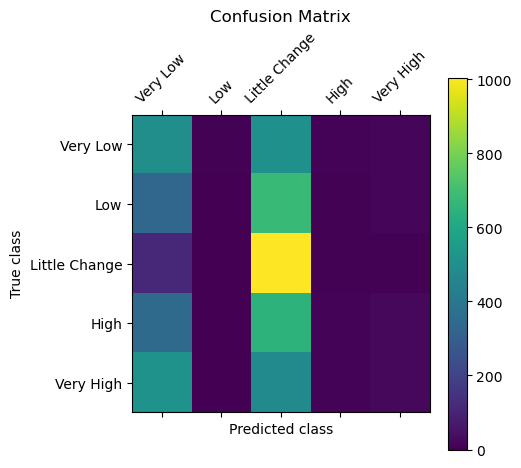

C:\Users\23510\AppData\Local\Temp\ipykernel_11968\1150479522.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Table = pd.concat([new_row,Table.loc[:]]).reset_index(drop=True)


Machine_Learning_Algorithm    Recall  Precision  F1_Score  Run_time
0             MPL Classifier  0.291793   0.263776  0.178553  1.522652

In [218]:
Perceptron(x_train154,y_train154,x_test154,y_test154,Table1 ,True)

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\23510\AppData\Local\Temp\ipykernel_11968\3240812348.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Table = pd.concat([new_row,Table.loc[:]]).reset_index(drop=True)


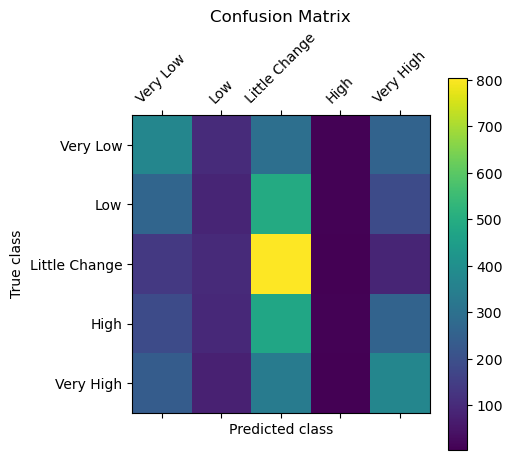

Machine_Learning_Algorithm   Recall  Precision  F1_Score  Run_time
0        Logistic Regression  0.31155    0.27541   0.25477  0.186568

In [219]:

Logistic_Regression(x_train154,y_train154,x_test154,y_test154,Table1 ,True)

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\AppData\Local\Temp\ipykernel_11968\3146881848.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Table = pd.concat([new_row,Table.loc[:]]).reset_index(drop=True)


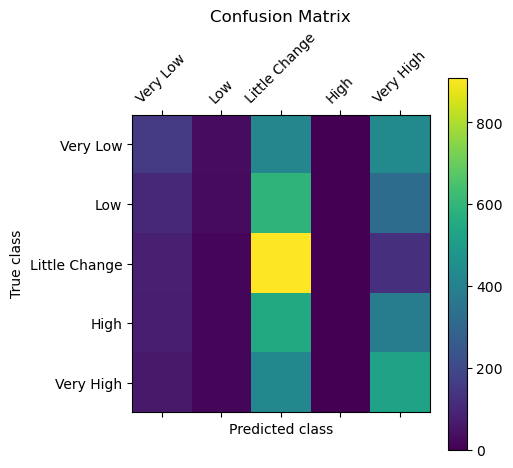

Machine_Learning_Algorithm    Recall  Precision  F1_Score  Run_time
0                Naive Bayes  0.306421   0.237994  0.218321  0.160721

In [220]:
Naive_Bayes(x_train154,y_train154,x_test154,y_test154,Table1 ,True)

# Comparison Table 

In [246]:
## For All stations
Table=pd.DataFrame(columns=['Machine_Learning_Algorithm',"Recall","Precision","F1_Score","Run_time"]) 
Table = Decision_Tree(x_train,y_train,x_test,y_test,Table ,False,feature_names1)
Table = Perceptron(x_train,y_train,x_test,y_test,Table ,False)
Table = Logistic_Regression(x_train,y_train,x_test,y_test,Table ,False)
Table = Naive_Bayes(x_train,y_train,x_test,y_test,Table, False)

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\AppData\Local\Temp\ipykernel_11968\278161069.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Table = pd.concat([new_row,Table.loc[:]]).reset_index(drop=True)
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [247]:
## For Station154
Table154=pd.DataFrame(columns=['Machine_Learning_Algorithm',"Recall","Precision","F1_Score","Run_time"]) 
Table154 =Decision_Tree(x_train154,y_train154,x_test154,y_test154,Table154,False,feature_names1)
Table154 =Perceptron(x_train154,y_train154,x_test154,y_test154,Table154, False)
Table154 =Logistic_Regression(x_train154,y_train154,x_test154,y_test154,Table154,False)
Table154 =Naive_Bayes(x_train154,y_train154,x_test154,y_test154,Table154 ,False)

C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\23510\AppData\Local\Temp\ipykernel_11968\278161069.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Table = pd.concat([new_row,Table.loc[:]]).reset_index(drop=True)
C:\Users\23510\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [252]:
Table=Table.sort_values(by='F1_Score', ascending=False)
Table=Table.reset_index(drop=True)

In [253]:
Table154=Table154.sort_values(by='F1_Score', ascending=False)
Table154=Table154.reset_index(drop=True)

In [254]:
Table

Machine_Learning_Algorithm    Recall  Precision  F1_Score  Run_time
0            giniMax Depth: 7  0.483067   0.491843  0.484303  0.214447
1         Logistic Regression  0.484018   0.483438  0.483153  0.250391
2        log_lossMax Depth: 7  0.478691   0.480384  0.473778  0.304405
3         entropyMax Depth: 7  0.478691   0.480384  0.473778  0.328856
4            giniMax Depth: 6  0.466514   0.474998  0.463269  0.264636
5         entropyMax Depth: 5  0.459285   0.453196  0.454605  0.313076
6        log_lossMax Depth: 5  0.459285   0.453196  0.454605  0.302200
7        log_lossMax Depth: 6  0.468607   0.471088  0.452856  0.324348
8         entropyMax Depth: 6  0.468607   0.471088  0.452856  0.306613
9            giniMax Depth: 5  0.459094   0.465551  0.447495  0.217463
10             MPL Classifier  0.450152   0.448461  0.433502  2.763683
11        entropyMax Depth: 3  0.415906   0.402436  0.398865  0.169955
12       log_lossMax Depth: 3  0.415906   0.402436  0.398865  0.166925
13           giniMax Depth: 4  0.440449   0.365720  0.395590  0.177431
14           giniMax Depth: 3  0.432458   0.372928  0.389253  0.125109
15       log_lossMax Depth: 4  0.429414   0.349119  0.383231  0.248076
16        entropyMax Depth: 4  0.429414   0.349119  0.383231  0.260185
17                Naive Bayes  0.414193   0.404290  0.374385  0.133737
18        entropyMax Depth: 2  0.379376   0.313464  0.336944  0.128173
19       log_lossMax Depth: 2  0.379376   0.313464  0.336944  0.114289
20           giniMax Depth: 2  0.383942   0.266795  0.299621  0.099165

In [255]:
Table154

Machine_Learning_Algorithm    Recall  Precision  F1_Score  Run_time
0        log_lossMax Depth: 6  0.319149   0.294128  0.266784  0.156842
1         entropyMax Depth: 6  0.319149   0.294128  0.266784  0.156413
2            giniMax Depth: 5  0.324468   0.310377  0.258619  0.093656
3        log_lossMax Depth: 5  0.323898   0.304368  0.258116  0.115262
4         entropyMax Depth: 5  0.323898   0.304368  0.258116  0.109344
5         Logistic Regression  0.311550   0.275410  0.254770  0.203120
6            giniMax Depth: 7  0.316869   0.270189  0.254173  0.140721
7        log_lossMax Depth: 7  0.307751   0.280385  0.253883  0.171824
8         entropyMax Depth: 7  0.307751   0.280385  0.253883  0.186040
9            giniMax Depth: 4  0.315540   0.300071  0.249752  0.078628
10           giniMax Depth: 6  0.317629   0.267806  0.248570  0.109300
11       log_lossMax Depth: 4  0.317439   0.264434  0.246155  0.093797
12        entropyMax Depth: 4  0.317439   0.264434  0.246155  0.086337
13       log_lossMax Depth: 3  0.295593   0.238868  0.238658  0.062662
14        entropyMax Depth: 3  0.295593   0.238868  0.238658  0.062627
15           giniMax Depth: 3  0.313450   0.249028  0.234463  0.050629
16           giniMax Depth: 2  0.295213   0.184147  0.222618  0.040411
17       log_lossMax Depth: 2  0.295213   0.184995  0.221909  0.048318
18        entropyMax Depth: 2  0.295213   0.184995  0.221909  0.047290
19                Naive Bayes  0.306421   0.237994  0.218321  0.142641
20             MPL Classifier  0.263298   0.262243  0.168712  1.490485

# Results

Both the regression and correlation analysis showed that weather is not a complete predictor of bike hiring, it at most can account for around 30-50% of the behaviour we see. Both methods struggle to pick apart the individual contributions of each of the variables given their high level of correlation interdependence and nonlinear behaviour, weather forecasting is notoriously hard in and of itself. 

The results for both are above, for the London wide data, the logistic regression and highly branched decision tree models fared well, correctly classifying around half the classes, with the logistic regression doing particularly well in at least making error to the order of adjacent classes. Again, this can be forgiven given the percentile nature of the boundaries. The other models however did not fair well and struggled to identify the overall behaviour. 
This became even more clear with station 154 data set. 

The linear Regression model faired overall best in the trials, at the local station level, there is too much variation from day to day and not enough volume for the laws of large numbers to take over. Thus is quite hard to predict on hourly timescales how much station hiring would go on.

The variation in Poisson distribution with lambda ~= 1 is commensurate with the variation from the weather.
The linear Regression faired best as the problem of weather is a linear one. Thus, the model fared well in this regard and more complex, models that work out relationships in non-linear or categorical way struggled to find the relationship. The linear regression model could usually predict the outcomes better than the others. 

The weather seems to have a largest impact on ridership, with natural variation becoming a big factor at small timescales. Any technological predictive advances would come to a natural limit as lambda approaches 1, at large spatial-temporal scales where the distribution is more normative and random variance is smaller, predictive models can be quite effective. 
At the macro level when all other random variables have been smoothed out the weather showed a linear response, and the linear models best captured the behaviour of the system. 

At micro levels, non-linear, categorical models also struggled with the poisson variation, assuming that the natural variation had some underlying causal relationship. It should be noted that these models are highly ineffective at characterizing behaviour as lambda approaches 1.


# Limitations

There are limitiations around processing power at the micro level and variation, but lack of accuracy at the higher level but with quicker processing and lower poisson variation. 
Limitations due to computational complexity affected how much this research could explore higher dimensional and non-linear relations at the micro level. These limitations include how other exogenous variables interact with weather, such as large sporting, concert events etc., bank holidays, tube strikes, road works. Does not properly include the impact of daylight (sunshine hours are included as a metric), non-weather-related seasonality, (school holidays). 
These models also do not consider any physical constraints about how weather interacts with its environment such as if nearby cycle routes, or the cycle station is sheltered, with respect to rain. 

Further to this, the precision of the data was only to the nearest hour, however at peak times the demand curve shows a non-linear response with respect to time, so the assumtions around precision will have an effect on how accurate it is, which could also explain some of the models difficulty in predicting behaviour. Perhaps time intervals of 15 minutes, even with the weather data not being as precise would better enhance the predictive power of the model.

# Further Work

Further work could seek to find the appropriate level of precision in the spatial-temporal dimension where natural variation is lower, computing time appropriate but the variable-to-variable interaction is not lost due to smoothing and large granularity. With this work I have found that averaging over all London per hour, certainly there is some causal losses, even if computationally efficient (i.e. it did not rain everywhere all at once). And when the spatio-dimension is narrowed down too much, computational demand is massively inflated, and random Poisson variation dominates anyway. 

# References 


Walsh, D., 2021. Investigating the Impact of Weather on Demand Prediction for Bike Sharing System (Doctoral dissertation, Dublin, National College of Ireland).

Lainjo, B., 2022. Application of Machine Learning in Predicting the Number of Bike Share Riders. International Journal of Business, Management and Economics, 3(4), pp.339-370.

Li, Y., Zheng, Y., Zhang, H. and Chen, L., 2015, November. Traffic prediction in a bike-sharing system. In Proceedings of the 23rd SIGSPATIAL international conference on advances in geographic information systems (pp. 1-10).

Chen, L., Zhang, D., Wang, L., Yang, D., Ma, X., Li, S., Wu, Z., Pan, G., Nguyen, T.M.T. and Jakubowicz, J., 2016, September. Dynamic cluster-based over-demand prediction in bike sharing systems. In Proceedings of the 2016 ACM International Joint Conference on Pervasive and Ubiquitous Computing (pp. 841-852).
